In [1]:
# For passwords & database access:
import psycopg2
import psycopg2.extras
import getpass

# For plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets

# For math
import numpy as np
import pandas as pd
from decam_utils import *
from scipy.optimize import curve_fit
from scipy.stats import linregress

import time

This notebook searches the extragalactic fields for candidates that (on their first night of detection) rose by at least 0.2 mag over at least 4 detections

**uses rbid=2**

In [2]:
# Logging in
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


#### The filter parameters

In [3]:
minnumdet = 4 # Minimum number of detections on the first night of data for the filter to consider a candidate

magamp = 0.0 # Minimum magnitude change throughout the candidates first night of detection

maxmgerr = 0.03 # max median error in detections

#### The filter

In [4]:
# Get a list of every MJD for which we have an image
query = ("SELECT e.mjd FROM exposures e "
         "WHERE (e.proposalid = '2021A-0113' "
         "OR e.proposalid = '2021B-0149') "
         "AND (e.ra < 50 "
         "OR e.dec > 0) "
         "LIMIT 10000000")
cursor.execute( query, )

datesquery = np.array(cursor.fetchall())

In [5]:
# Make a list of every observing night (by rounding to the nearest MJD)
odatesrd = np.unique( np.round( datesquery ) )
datemsks = [np.where(np.abs(datesquery-i) < 0.5) for i in odatesrd]
odates = np.array([np.mean(datesquery[i]) for i in datemsks])

In [6]:
def lin(x,m,b):
    return m*x + b

In [7]:
fr = []
frdates = []
filidx = []
fitpararr = []
amps = []
maxmags = []
medmgerrs = []
slopeerrs = []
numdets = []

t1 = time.time() # should be about 30 seconds

goodfnms = good_fnms(cursor)[0] # Pulls all the exposure IDs of science images 

for field in ["COSMOS", "ELIAS"]:
    for fil in ["g","r","i"]:
        tempfr = [] # List for the names of fast-rising candidates
        tempfrdates = [] # List for the dates on which fast riser behavior was observed
        
        oldcands = np.array( [] ) # used to check if candidates have been detected before

        for i in range(len(odatesrd)):
            # Loop through each observing night
            # Grab all detections within a day of the night in question
            lodate = odatesrd[i] - 0.5
            hidate = odatesrd[i] + 0.5
            if field == "COSMOS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=2 "
                         "WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            elif field == "ELIAS":
                query = ("SELECT o.candidate_id, o.id, e.mjd, o.mag, rbs.rb, e.id, o.magerr FROM objects o "
                         "JOIN subtractions s ON s.id=o.subtraction_id "
                         "JOIN exposures e on s.exposure_id = e.id "
                         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=2 "
                         "WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) "
                         "AND rbs.rb > 0.4 "
                         "AND e.mjd > %s "
                         "AND e.mjd < %s "
                         "AND e.filter = %s "
                         "AND (e.proposalid = '2021A-0113' "
                         "OR e.proposalid = '2021B-0149') "
                         "LIMIT 10000000")
            cursor.execute( query, ( lodate, hidate, fil, ) )

            # Store that nights detections in an array
            tempres = np.array( cursor.fetchall(), dtype=str ).transpose()

            if len( tempres ) > 0: # Takes care of errors from gaps in the observations by skipping empty nights
                # print(field, fil, i)
                # Cut out duplicate objects
                dupearr = np.array( [tempres[0], tempres[2], tempres[3], tempres[4], tempres[5], tempres[6]] ).transpose()
                dupearr = [ " ".join(j) for j in dupearr ]
                dupearr, ind = np.unique( dupearr, return_index=True )

                # Rejoin the array without the duplicates
                uarr = np.array( [ i.split(" ") for i in dupearr ] ).transpose()
                res = np.array( [uarr[0], tempres[1][ind], uarr[1], uarr[2], uarr[3], uarr[4], uarr[5]] )
                
                # Cut out non-science images
                msk = np.isin(res[5], goodfnms)
                res = np.array([i[msk] for i in res])
                
                # Create an array of each unique candidate detected that night
                ucands, uind, ucounts = np.unique( res[0], return_counts=True, return_index=True )
                
                # Isolate those with at least numdet detections
                goodcands = ucands[ ucounts >= minnumdet ]


                # Make an array of detections for each of those candidates, store all of those arrays in "arr"
                arr = np.ones( len( goodcands ), dtype=object )
                for j in range( len( goodcands ) ):
                    arr[j] = res[:,res[0,:] == goodcands[j]]
                
                # Mask out those that 
                # A) Don't change by at least magamp mags
                # B) Have a median mag error of > 0.03
                # C) Have a non-negative slope (slope+slopeerr > 0) 
                good = np.ones( len( arr ), dtype=bool )
                for j in range( len( arr ) ):
                    # A)
                    amp = np.max( arr[j][3].astype(float) ) - np.min( arr[j][3].astype(float) )
                    if amp < magamp:
                        good[j] = False
                    else:
                        ntmjds  = arr[j][2].astype(float)
                        ntmags  = arr[j][3].astype(float)
                        ntmgerr = arr[j][6].astype(float)
                        msk1 = ~np.isnan(ntmags)
                        msk2 = ~np.isnan(ntmgerr)
                        msk = msk1 & msk2
                        # print(np.unique([msk,msk1]))
                        ntmjds, ntmags, ntmgerr  = ntmjds[msk], ntmags[msk], ntmgerr[msk]
                        
                        maxmag = np.min(ntmags)
                        medmgerr = np.median(ntmgerr)
                        
                        # B
                        if medmgerr > maxmgerr:
                            good[j] = False
                        
                        # C
                        else:
                            # Using scipy curve_fit
                            # fitpars = curve_fit(lin, ntmjds, ntmags, sigma=ntmgerr )
                            # slope, intercept, slopeerr = fitpars[0][0], fitpars[0][1], fitpars[1][0][0]
                            # if slope + np.abs(slopeerr) > 0:
                            #     good[j]=False

                            # Using np.polyfit, weights, and error in params:
                            fitpars = np.polyfit(ntmjds, ntmags, 1, w=1/ntmgerr, cov=True)
                            slope, intercept = fitpars[0]
                            slopeerr = fitpars[-1][0][0]
                            numdet = len(ntmjds)
                            # if slope + np.abs(slopeerr) > 0:
                            #     good[j] = False
                            if False:
                                pass

                            # Using linregress and Pearson:
                            # fitpars = linregress(ntmjds, ntmags)
                            # slope, intercept, pearson = fitpars[0], fitpars[1], fitpars[2]
                            # if (pearson > -0.5) | (np.isnan(pearson)):
                            #     good[j] = False

                            else:
                                fitpararr.append([slope,intercept])
                                amps.append(amp)
                                maxmags.append(maxmag)
                                medmgerrs.append(medmgerr)
                                slopeerrs.append(slopeerr)
                                numdets.append(numdet)
                    
                # Apply those cuts and append the candidates that passed to fr and frdates
                for j in range( len( arr[good] ) ):
                    tempfr.append( arr[good][j][0][0] )
                    tempfrdates.append( [lodate, hidate] )
            
            # Make a note of all candidates detected this night (for cutting out things that have been previously detected)
            try:
                oldcands = np.append( oldcands, ucands )
            except NameError:
                pass
            fr.append(tempfr)
            frdates.append(tempfrdates)
        filidx.append([len(j) for j in fr][-1])
        
x = []
y = []
ind = np.unique(fr, return_index=True)[1]
for i in [fr[ind] for ind in sorted(ind)]:
    x.extend(i)
for i in [frdates[ind] for ind in sorted(ind)]:
    y.extend(i)
fr = x
frdates = y

fitpararr = np.array(fitpararr)
amps = np.array(amps)
maxmags = np.array(maxmags)

t2 = time.time()
print(t2-t1)

del x, y, ind

36.78441882133484


/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
len(fr)

4894

#### Determine if the filter was passed on a candidates first or only night in a filter

In [9]:
fn = []
on = []
for i in range(len(fr)):
    query = ("SELECT o.mag, e.mjd FROM objects o "
             "JOIN subtractions s ON s.id=o.subtraction_id "
             "JOIN exposures e on s.exposure_id = e.id "
             "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
             "WHERE rbs.rb > 0.4 "
             "AND (e.proposalid = '2021A-0113' "
             "OR e.proposalid = '2021B-0149') "
             "AND o.candidate_id = %s "
             "ORDER BY e.mjd "
             "LIMIT 10000000")
    cursor.execute( query, ( fr[i], ) )
    tempres = np.array( cursor.fetchall(), dtype=float ).transpose()
    if len(tempres) == 0:
        fn.append(False)
        on.append(False)
    else:
        lastnight = float(tempres[1][-1])
        firstnight = float(tempres[1][0])
        if firstnight < frdates[i][0]:
            fn.append(False)
            on.append(False)
        else:
            fn.append(True)
            if lastnight > frdates[i][1]:
                on.append(False)
            else:
                on.append(True)


#### Combine all that info into a dataframe

In [10]:
df = pd.DataFrame(index = range(len(fr)), columns = ["CandID", "Field", "Filter", "Night", "DelMag", "PeakMag", "FirstNight", "OnlyNight", "Slope", "Intercept", "MedErr", "SlopeErr", "NumDet", "SlopeSig"])

for i in range(len(fr)):
    df["CandID"][i] = fr[i]
    if i < sum(filidx[:3]):
        df["Field"][i] = "COSMOS"
    else: 
        df["Field"][i] = "ELAIS"
    df["Night"][i] = frdates[i][0]+0.5
    df["Slope"][i] = fitpararr[i][0]
    df["Intercept"][i] = fitpararr[i][1]
    df["DelMag"][i] = amps[i]
    df["PeakMag"][i] = maxmags[i]
    df["MedErr"][i] = medmgerrs[i]
    df["FirstNight"][i] = fn[i]
    df["OnlyNight"][i] = on[i]
    df["SlopeErr"][i] = np.sqrt(slopeerrs[i])
    df["NumDet"][i] = numdets[i]
    if i < filidx[0]:
        df["Filter"][i] = "g"
    elif (i >= filidx[0]) & (i < sum(filidx[:2])):
        df["Filter"][i] = "r"
    elif (i >= sum(filidx[:2])) & (i < sum(filidx[:3])):
        df["Filter"][i] = "i"
    elif (i >= sum(filidx[:3])) & (i < sum(filidx[:4])):
        df["Filter"][i] = "g"
    elif (i >= sum(filidx[:4])) & (i < sum(filidx[:5])):
        df["Filter"][i] = "r"
    elif (i >= sum(filidx[:5])): #& (i < sum(filidx[:6])):
        df["Filter"][i] = "i"
        
### This takes care of duplicates that arise from having observations closer together than usual
df = df.drop_duplicates(subset=["CandID", "Field", "Filter", "DelMag", "PeakMag"])
try:
    df = df.reset_index(drop=True)
except ValueError:
    pass
fr = df["CandID"]
frdates = [[df["Night"][i]-0.5,df["Night"][i]+0.5] for i in range(len(fr))]

In [11]:
df["SlopeSig"] = np.abs(df["Slope"])/df["SlopeErr"]

In [12]:
### Summary of Results:
print("There were %s total fast risers" % len(df))
print("Spread over %s candidates" % len(np.unique(df["CandID"])))
print("%s in g, %s in r, and %s in i" % (len(df[df["Filter"]=="g"]), len(df[df["Filter"]=="r"]), len(df[df["Filter"]=="i"])))
print("%s in COSMOS, %s in ELAIS" % (len(df[df["Field"]=="COSMOS"]), len(df[df["Field"]=="ELAIS"])))
print("%s of these rose quickly on their first night" % len(df[df["FirstNight"]==True]))
print("%s of those were only detected on one night" % len(df[df["OnlyNight"]==True]))

There were 4894 total fast risers
Spread over 1181 candidates
1205 in g, 3078 in r, and 611 in i
3830 in COSMOS, 1064 in ELAIS
600 of these rose quickly on their first night
63 of those were only detected on one night


In [13]:
# plt.hist(df["Night"][(df["FirstNight"]==True) & (df["Night"]!=59356)], bins=100)
# plt.hist(df["Night"], bins=100)
# plt.axvline(59357, color='black', alpha = 0.5)
# plt.ylabel("number of 'fast riser' cands")
# plt.xlabel("MJD")

#### How accurately do intra-night slopes predict inter-night ones?

In [32]:
numsig=3
print("We can confidently ({} sigma) identify intra-night"
      " rises/falls for {} percent of candidate-nights with >4 "
      "detections".format(numsig, (len(df[df["SlopeSig"]>numsig])/len(df) * 100)))

We can confidently (3 sigma) identify intra-night rises/falls for 9.276665304454434 percent of candidate-nights with >4 detections


In [33]:
t1 = time.time()
pred = []
act = []
predsgn = []
actsgn = []
for i in df[(df["SlopeSig"]>numsig) & (df["OnlyNight"]==False)][:100].index:
    arr = plotlc(df["CandID"][i], cursor, show_plot=False)
    if df["Filter"][i] == "g":
        arr = [i[0] for i in arr]
    elif df["Filter"][i] == "r":
        arr = [i[1] for i in arr]
    elif df["Filter"][i] == "i":
        arr = [i[2] for i in arr]
    night = df["Night"][i]
    ind = int(np.where(np.round(arr[0])==night)[0])+1
    try:
        act.append(arr[1][ind])
        pred.append(lin(arr[0][ind],df["Slope"][i], df["Intercept"][i]))
        actsgn.append(np.sign(arr[1][ind] - arr[1][ind-1]))
        predsgn.append(np.sign(df["Slope"][i]))
    except: # Takes care of cand-nights that are the last in a series 
        print("Last night")
        act.append(np.NaN)
        pred.append(np.NaN)
        actsgn.append(np.NaN)
        predsgn.append(np.NaN)
t2 = time.time()
print(t2-t1)

109.01585221290588


In [34]:
correct = np.array([predsgn[i]==actsgn[i] for i in range(len(predsgn))]).astype(int)
print("Confident intranight slopes predict the sign of internight slopes {}% of the time".format(sum(correct)/len(correct)*100))
correct = [predsgn[i]==actsgn[i] for i in range(len(predsgn))]

Confident intranight slopes predict the sign of internight slopes 57.99999999999999% of the time


In [35]:
plt.hist(correct.astype(int))

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
resid = np.abs(np.array(pred) - np.array(act))
plt.hist(resid[resid<40], bins=30)
plt.ylabel("Number of cand-nights")
plt.xlabel("Residual of slope vs actual change (mags)")
plt.xlim(0,40);

In [ ]:
np.unique(df["CandID"][(df["SlopeSig"]>numsig) & (df["OnlyNight"]==False)], return_counts=True)[1]

#### Distributions of slopes

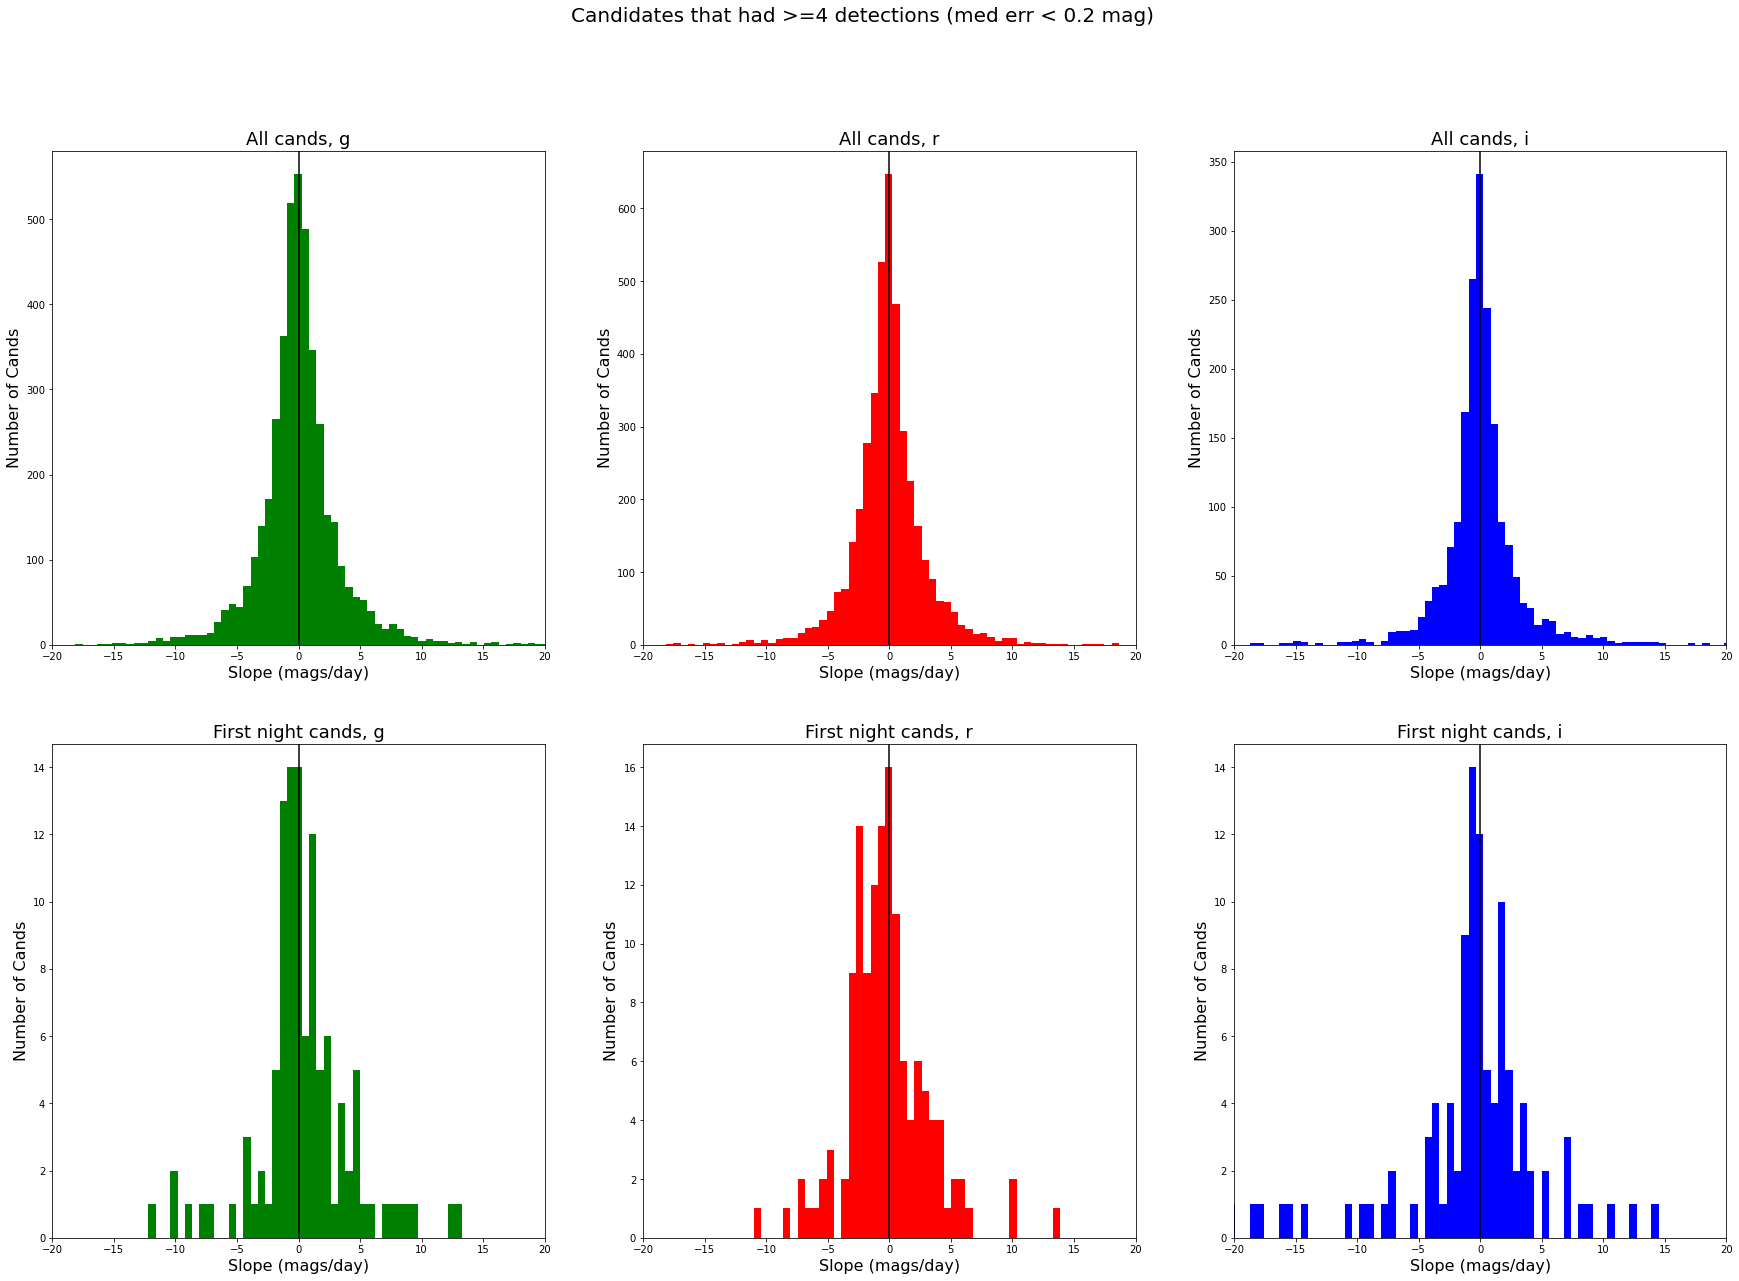

In [12]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']

fig, ax = plt.subplots(2,3, figsize=(30,20), sharex=True)
n, bins = np.histogram(df["Slope"], bins=200)
for i in range(3):
    fil = all_filters[i]
    ax[0,i].hist(df["Slope"][df["Filter"]==fil], bins=bins, color=all_fcolors[i])
    ax[0,i].set_xlabel("Slope (mags/day)", fontsize=16)
    ax[0,i].set_ylabel("Number of Cands", fontsize=16)
    ax[0,i].set_title("All cands, %s" % (fil), fontsize=18)
    ax[0,i].tick_params(labelbottom=True)
    ax[0,i].axvline(0, c="black")
    ax[1,i].hist(df["Slope"][(df["FirstNight"]==True) & (df["Filter"]==fil) & (df["Night"]!=59356)], bins=bins, color=all_fcolors[i])
    ax[1,i].set_xlim(-20,20)
    ax[1,i].set_xlabel("Slope (mags/day)", fontsize=16)
    ax[1,i].set_ylabel("Number of Cands", fontsize=16)
    ax[1,i].set_title("First night cands, %s" % (fil), fontsize=18)
    ax[1,i].axvline(0, c="black")
fig.suptitle("Candidates that had >=4 detections (med err < %s mag)" % (maxmgerr), fontsize=20);
plt.savefig("slope_distribution_egal")

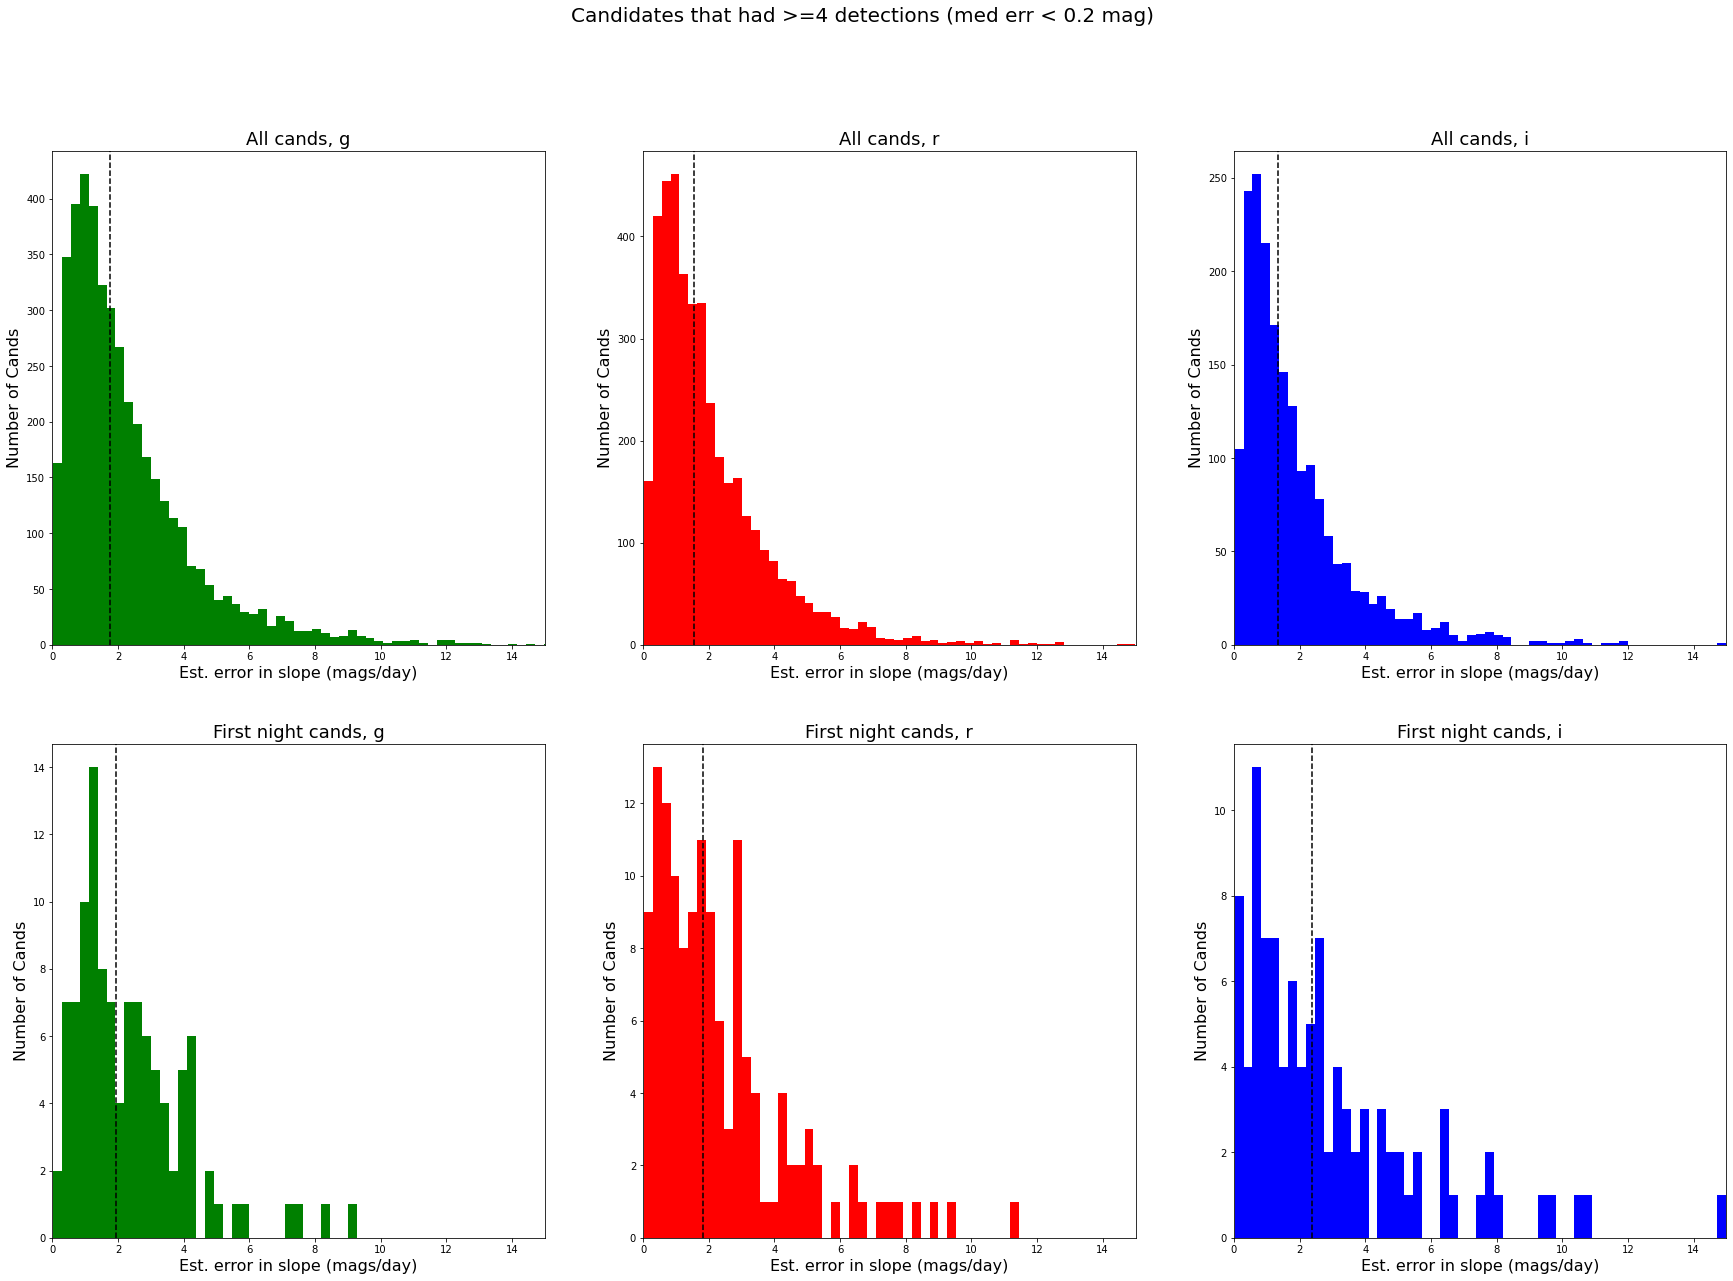

In [13]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']

fig, ax = plt.subplots(2,3, figsize=(30,20), sharex=True)
n, bins = np.histogram(df["SlopeErr"], bins=100)
for i in range(3):
    fil = all_filters[i]
    ax[0,i].hist(df["SlopeErr"][df["Filter"]==fil], bins=bins, color=all_fcolors[i])
    ax[0,i].axvline(np.median(df["SlopeErr"][df["Filter"]==fil]), color="black", ls ='--')
    ax[0,i].set_xlabel("Est. error in slope (mags/day)", fontsize=16)
    ax[0,i].set_ylabel("Number of Cands", fontsize=16)
    ax[0,i].set_title("All cands, %s" % (fil), fontsize=18)
    ax[0,i].tick_params(labelbottom=True)
    ax[1,i].hist(df["SlopeErr"][(df["FirstNight"]==True) & (df["Filter"]==fil) & (df["Night"]!=59356)], bins=bins, color=all_fcolors[i])
    ax[1,i].axvline(np.median(df["SlopeErr"][(df["FirstNight"]==True) & (df["Filter"]==fil) & (df["Night"]!=59356)]), color="black", ls ='--')
    
    ax[1,i].set_xlim(0,15)
    ax[1,i].set_xlabel("Est. error in slope (mags/day)", fontsize=16)
    ax[1,i].set_ylabel("Number of Cands", fontsize=16)
    ax[1,i].set_title("First night cands, %s" % (fil), fontsize=18)
fig.suptitle("Candidates that had >=4 detections (med err < %s mag)" % (maxmgerr), fontsize=20);
plt.savefig("slopeerr_distribution_egal")

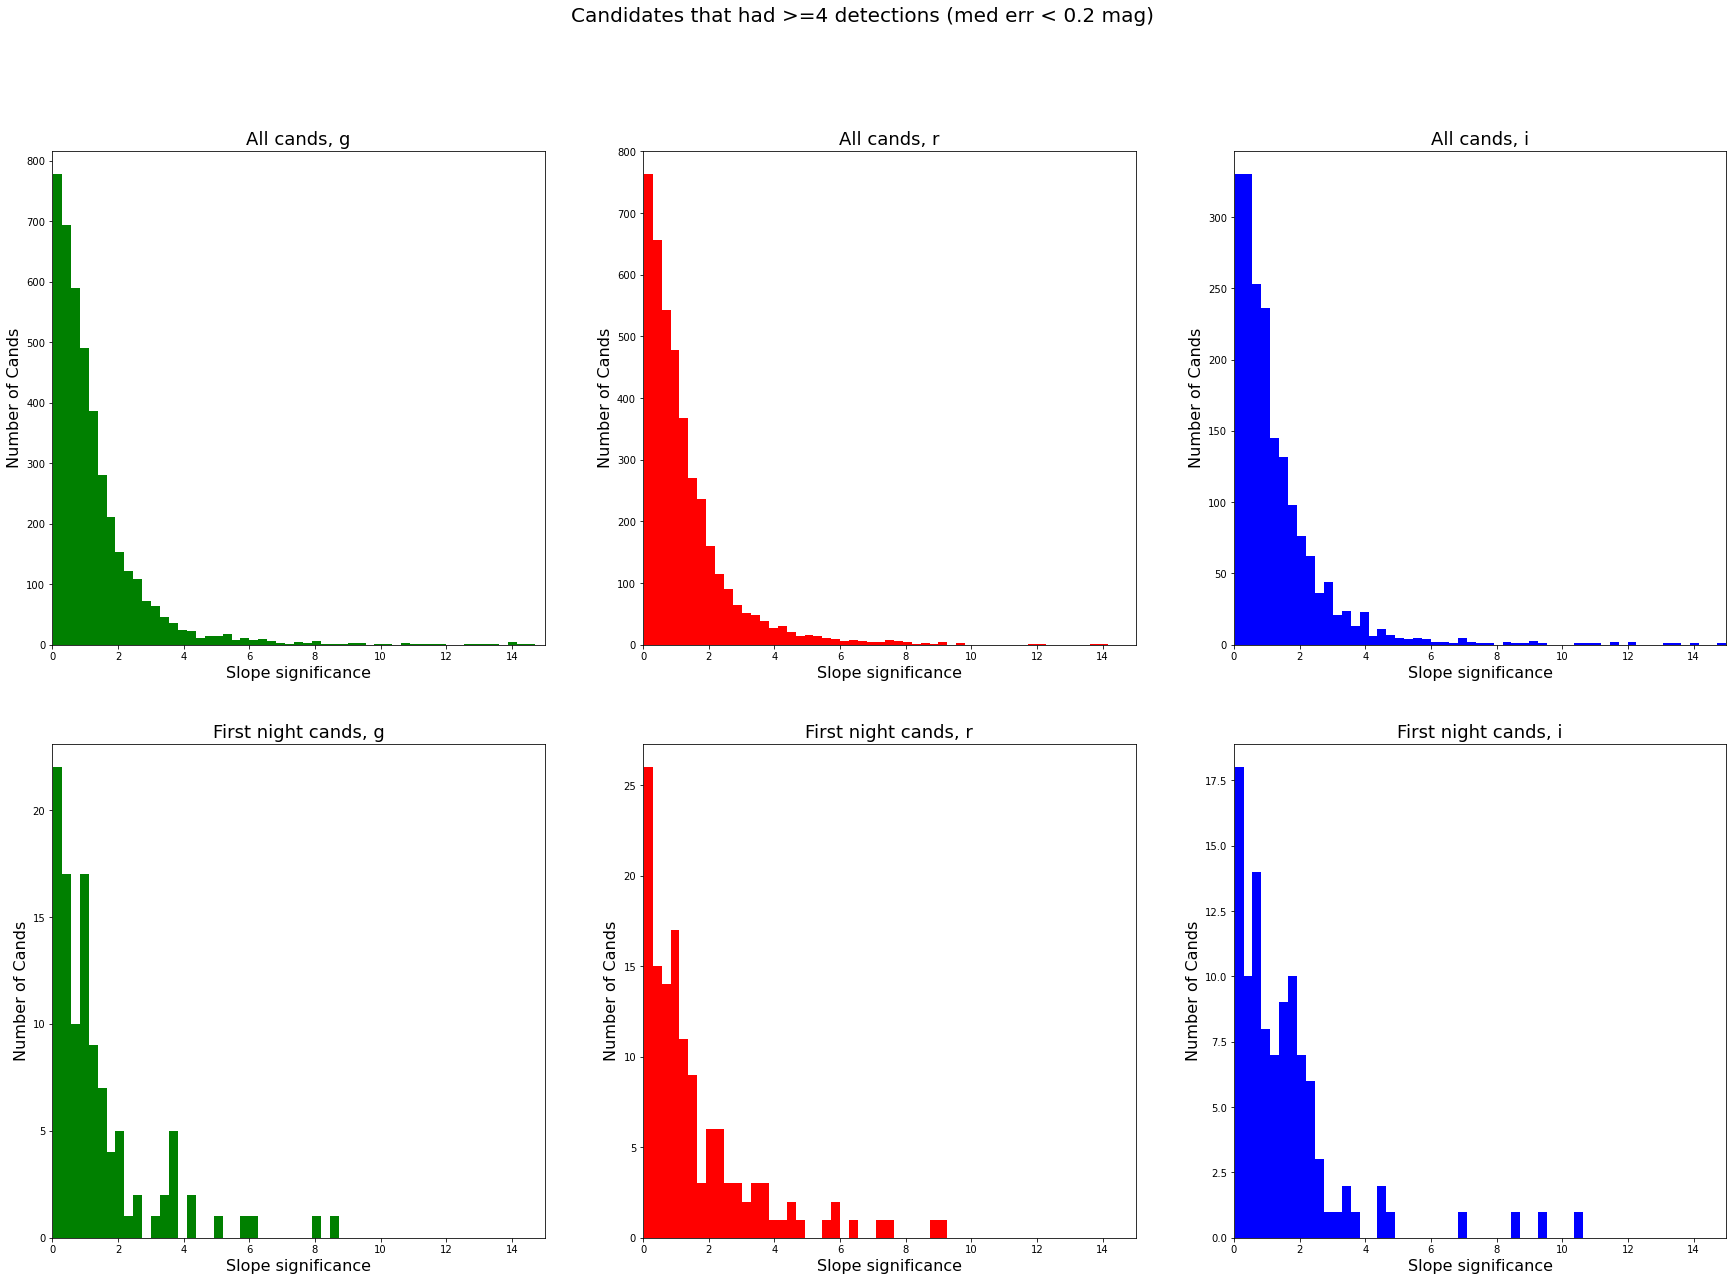

In [57]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']

fig, ax = plt.subplots(2,3, figsize=(30,20), sharex=True)
n, bins = np.histogram(df["SlopeErr"], bins=100)
for i in range(3):
    fil = all_filters[i]
    ax[0,i].hist(df["SlopeSig"][df["Filter"]==fil], bins=bins, color=all_fcolors[i])
    ax[0,i].set_xlabel("Slope significance", fontsize=16)
    ax[0,i].set_ylabel("Number of Cands", fontsize=16)
    ax[0,i].set_title("All cands, %s" % (fil), fontsize=18)
    ax[0,i].tick_params(labelbottom=True)
    ax[1,i].hist(df["SlopeSig"][(df["FirstNight"]==True) & (df["Filter"]==fil) & (df["Night"]!=59356)], bins=bins, color=all_fcolors[i])
    ax[1,i].set_xlim(0,15)
    ax[1,i].set_xlabel("Slope significance", fontsize=16)
    ax[1,i].set_ylabel("Number of Cands", fontsize=16)
    ax[1,i].set_title("First night cands, %s" % (fil), fontsize=18)
fig.suptitle("Candidates that had >=4 detections (med err < %s mag)" % (maxmgerr), fontsize=20);
plt.savefig("slopesig_distribution_egal")

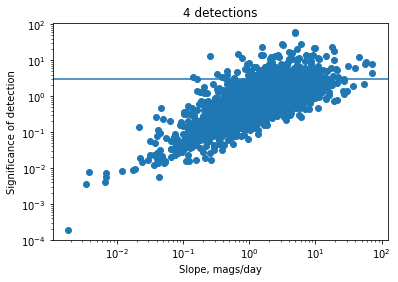

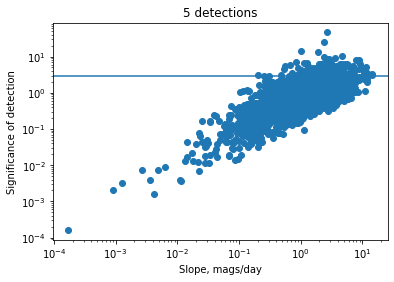

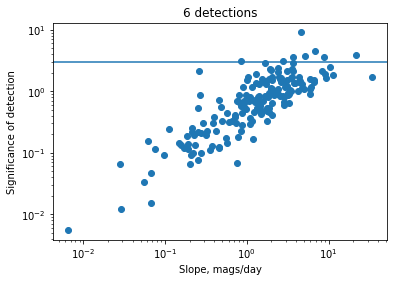

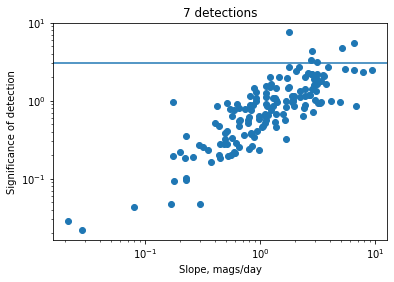

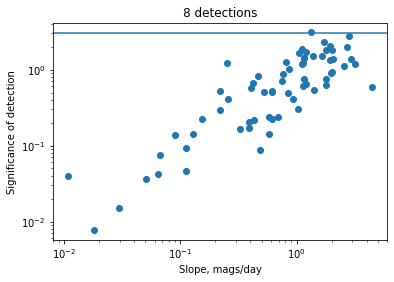

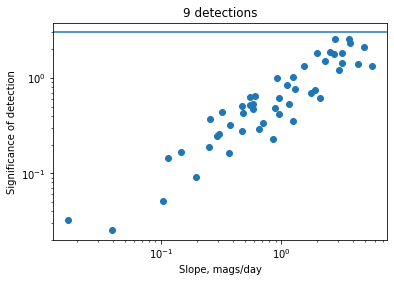

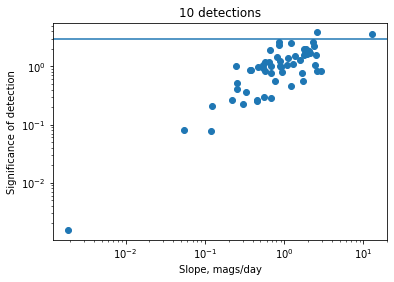

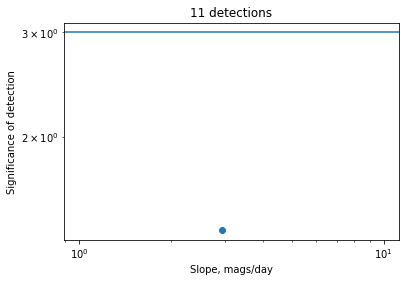

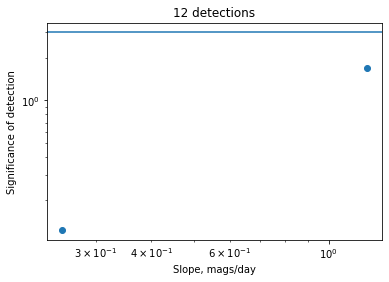

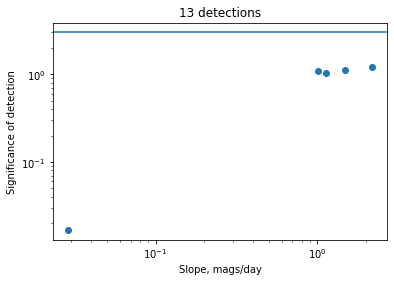

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [99]:
for i in np.unique(df["NumDet"]):
    fil='g'
    plt.scatter(np.abs(df["Slope"][(df["Filter"]==fil) & (df["NumDet"]==i) ]),\
                np.abs(df["SlopeSig"][(df["Filter"]==fil) & (df["NumDet"]==i)]), alpha=1)
    plt.axhline(3)
    plt.yscale('log')
    plt.xscale('log')
    plt.title("{} detections".format(i))
    plt.xlabel("Slope, mags/day")
    plt.ylabel("Significance of detection")
    plt.show()

In [30]:
# plt.hist2d(np.abs(df["MedErr"]), df["SlopeErr"], bins=100)
# # plt.xlim(0,10)
# plt.ylim(0,6)
# plt.show()

# plt.hist2d(df["NumDet"], df["SlopeErr"], bins=30);
# plt.ylim(0,10)
# plt.xlim(4,10)

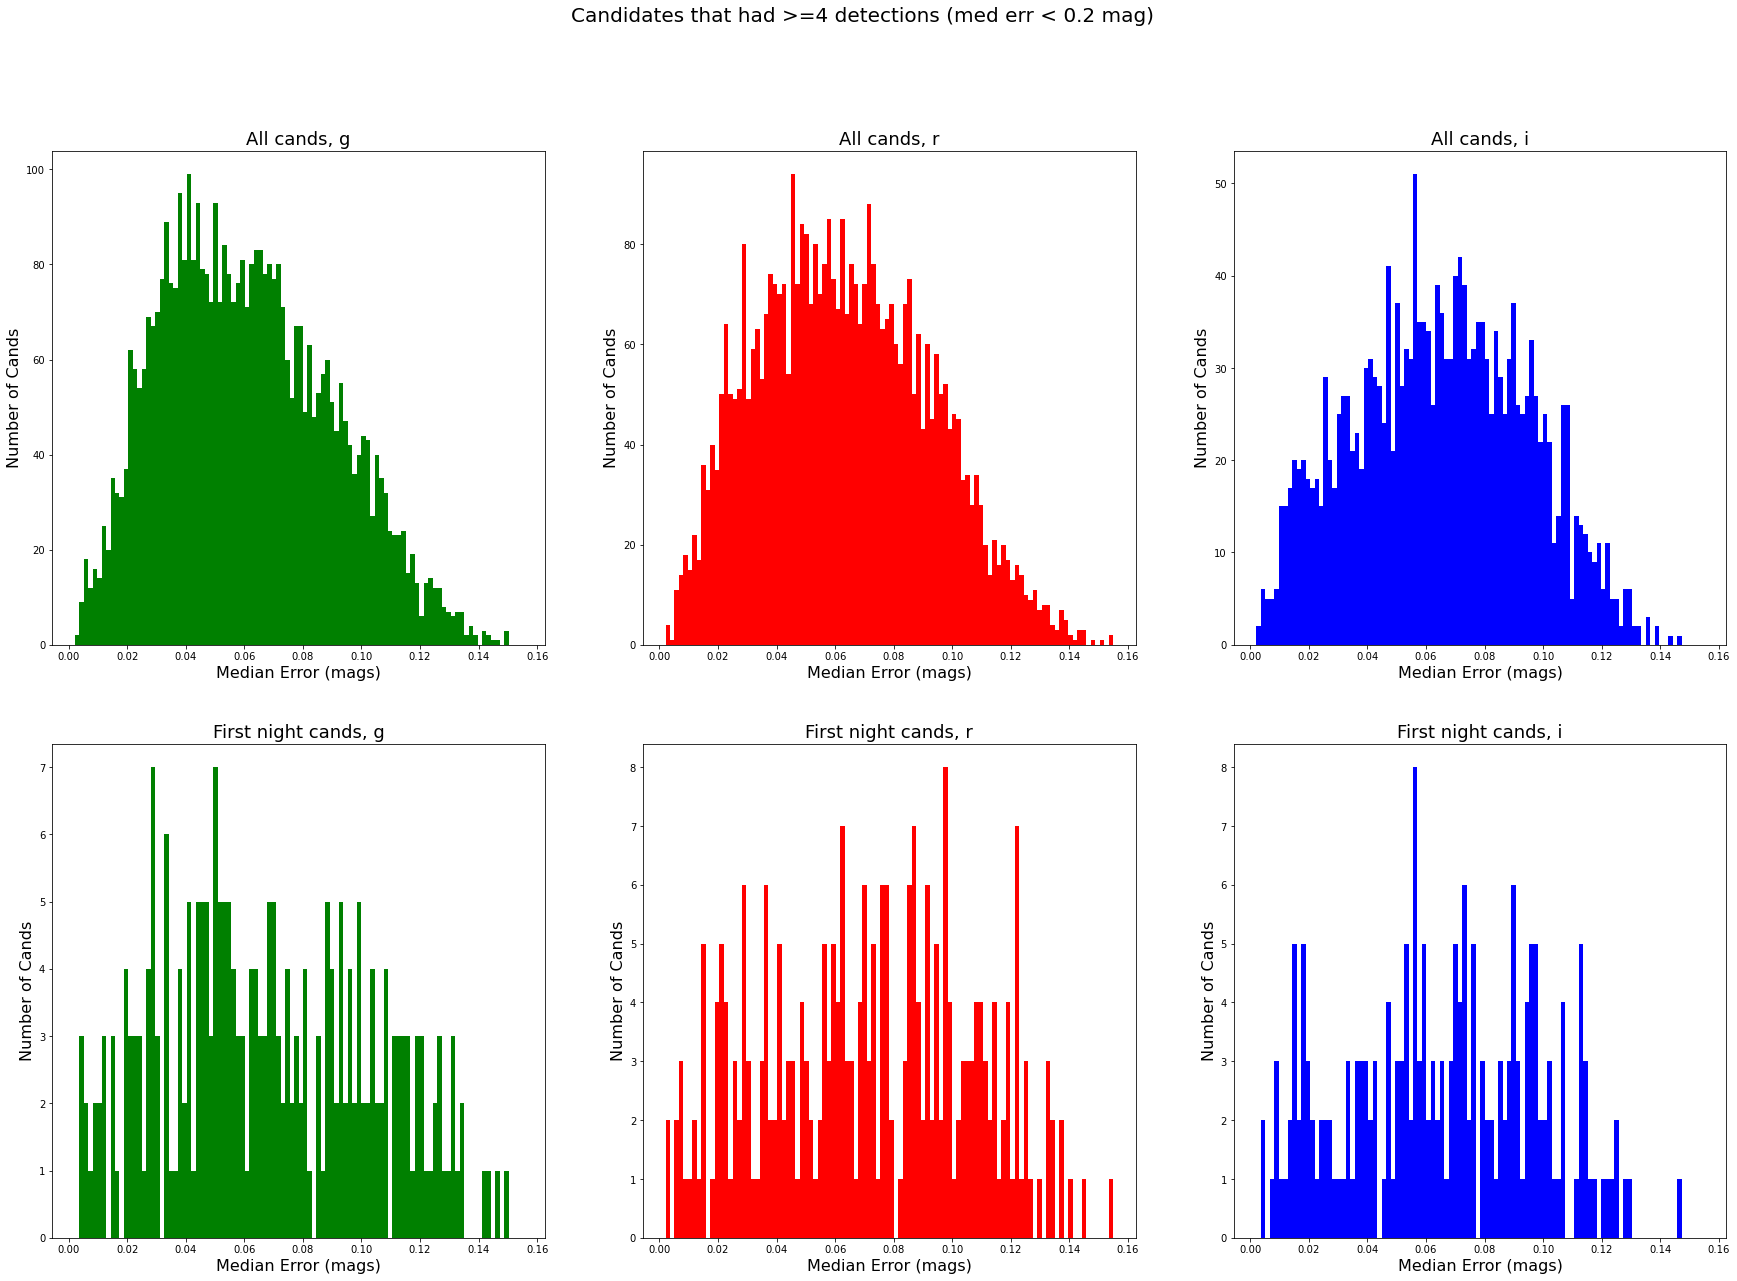

In [15]:
fig, ax = plt.subplots(2,3, figsize=(30,20), sharex=True)
n, bins = np.histogram(df["MedErr"], bins=100)
for i in range(3):
    fil = all_filters[i]
    ax[0,i].hist(df["MedErr"][df["Filter"]==fil], bins=bins, color=all_fcolors[i])
    # ax[0,i].set_xlim(-20,20)
    ax[0,i].set_xlabel("Median Error (mags)", fontsize=16)
    ax[0,i].set_ylabel("Number of Cands", fontsize=16)
    ax[0,i].set_title("All cands, %s" % (fil), fontsize=18)
    ax[0,i].tick_params(labelbottom=True)
    ax[1,i].hist(df["MedErr"][(df["FirstNight"]==True) & (df["Filter"]==fil)], bins=bins, color=all_fcolors[i])
    # ax[1,i].set_xlim(-20,20)
    ax[1,i].set_xlabel("Median Error (mags)", fontsize=16)
    ax[1,i].set_ylabel("Number of Cands", fontsize=16)
    ax[1,i].set_title("First night cands, %s" % (fil), fontsize=18)
fig.suptitle("Candidates that had >=4 detections (med err < %s mag)" % (maxmgerr), fontsize=20);

#### How much did the fast risers rise in a night?

In [245]:
# fig, ax = plt.subplots(3, sharex=True, figsize=[7,15])
# bins = ax[0].hist(
#     [df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="COSMOS")).dropna(),
#     df["DelMag"].where((df["Filter"]=="g") & (df["Field"]=="ELAIS")).dropna()],
#     color=["darkgreen","limegreen"], 
#     stacked=True)[1]
# ax[0].set_xlabel("Amplitude")
# ax[0].set_ylabel("Number")
# ax[0].set_title("g")
# ax[0].tick_params(labelbottom=True)

# ax[1].hist(
#     [df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="COSMOS")).dropna(),
#     df["DelMag"].where((df["Filter"]=="r") & (df["Field"]=="ELAIS")).dropna()],
#     color=["red","darkorange"],
#     bins=bins,
#     stacked=True)
# ax[1].set_xlabel("Amplitude")
# ax[1].set_ylabel("Number")
# ax[1].set_title("r")
# ax[1].tick_params(labelbottom=True)

# ax[2].hist(
#     [df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="COSMOS")).dropna(),
#     df["DelMag"].where((df["Filter"]=="i") & (df["Field"]=="ELAIS")).dropna()],
#     color=["brown","peru"],
#     bins=bins,
#     stacked=True)
# ax[2].set_xlabel("Amplitude")
# ax[2].set_ylabel("Number")
# ax[2].set_title("i");

In [246]:
# fig, ax = plt.subplots(3, sharex=True, figsize=[7,15])
# bins = ax[0].hist(
#     [df["PeakMag"].where((df["Filter"]=="g") & (df["Field"]=="COSMOS")).dropna(),
#     df["PeakMag"].where((df["Filter"]=="g") & (df["Field"]=="ELAIS")).dropna()],
#     color=["darkgreen","limegreen"], 
#     stacked=True)[1]
# ax[0].set_xlabel("Peak Brightness (mag)")
# ax[0].set_ylabel("Number")
# ax[0].set_title("g")
# ax[0].tick_params(labelbottom=True)

# ax[1].hist(
#     [df["PeakMag"].where((df["Filter"]=="r") & (df["Field"]=="COSMOS")).dropna(),
#     df["PeakMag"].where((df["Filter"]=="r") & (df["Field"]=="ELAIS")).dropna()],
#     color=["red","darkorange"],
#     bins=bins,
#     stacked=True)
# ax[1].set_xlabel("Peak Brightness (mag)")
# ax[1].set_ylabel("Number")
# ax[1].set_title("r")
# ax[1].tick_params(labelbottom=True)

# ax[2].hist(
#     [df["PeakMag"].where((df["Filter"]=="i") & (df["Field"]=="COSMOS")).dropna(),
#     df["PeakMag"].where((df["Filter"]=="i") & (df["Field"]=="ELAIS")).dropna()],
#     color=["brown","peru"],
#     bins=bins,
#     stacked=True)
# ax[2].set_xlabel("Peak Brightness (mag)")
# ax[2].set_ylabel("Number")
# ax[2].set_title("i");

#### Menagerie Plot

10


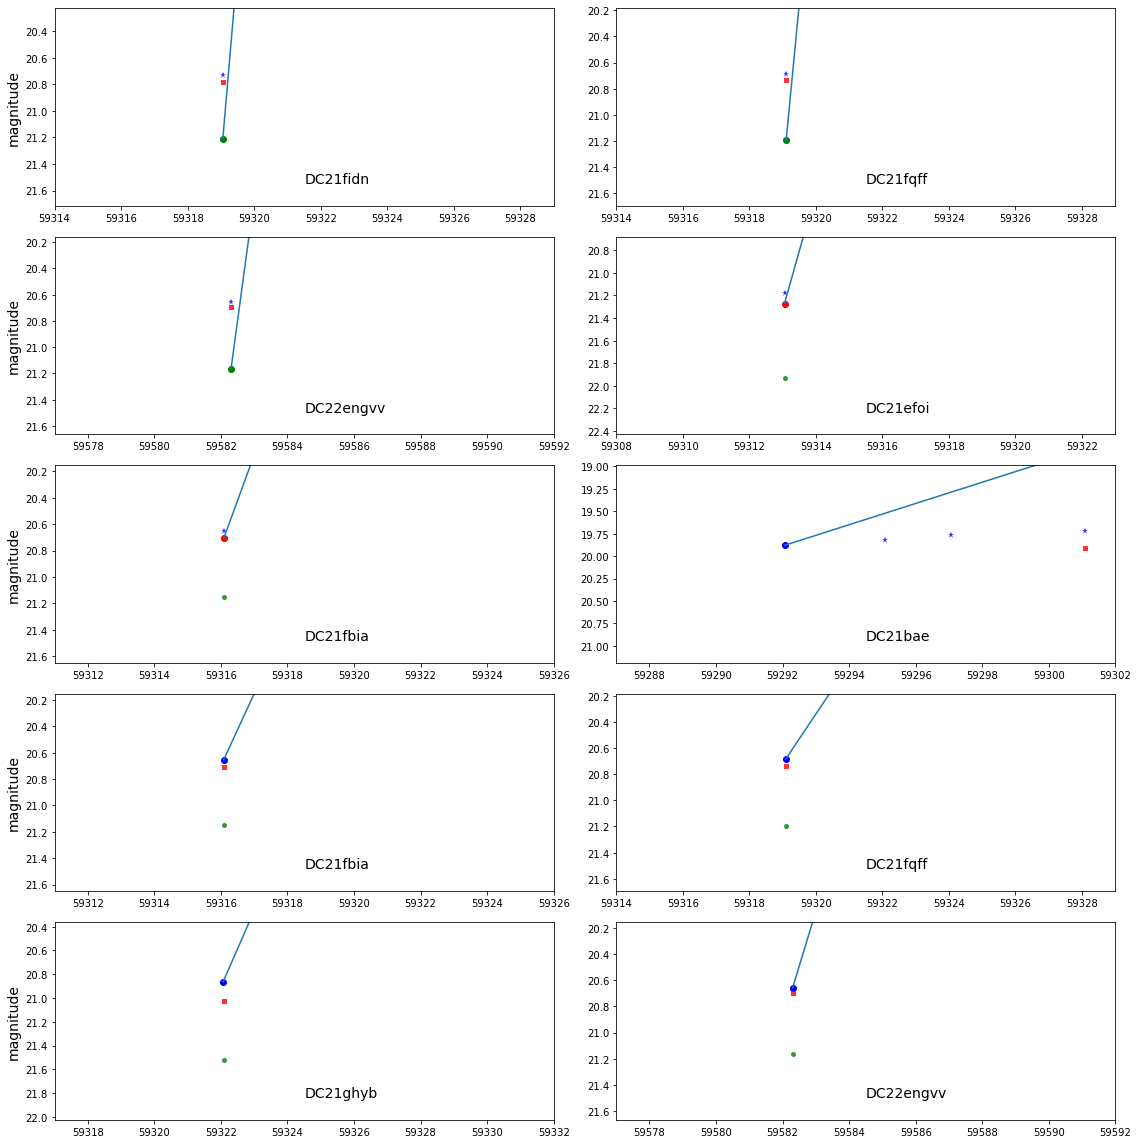

In [24]:
### Colors to use for COSMOS-g, -r, -i and ELAIS-g, -r, -i
clr = ['darkgreen', 'firebrick', 'saddlebrown', 'limegreen', 'orange', 'lightcoral']

all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','*']
all_fsizes  = [5, 5, 7]
ncols = 2

tx = np.array(df[(df["FirstNight"]==True) & (df["Night"] != 59356)].index)

print(len(tx))
fig, ax = plt.subplots( int(np.ceil(len(tx) / ncols)), ncols, figsize=(16,(int(np.ceil(len(tx) / ncols)))/5*16), sharex=False, sharey=False )

t = 0
for i in range(int(np.ceil(len(tx) / ncols))):
    ax[i,0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncols):
        if t < len(tx):
            cand = fr[tx].values[t]  
            cmjds, cmags, cmagerrs = plotlc(cand, cursor, show_plot=False)
            mjd = df["Night"][tx].values[t] + 10 
            mjdstart = mjd-15
            f = df["Filter"][tx[t]]
            if f=='g':
                f = 0
            elif f=='r':
                f=1
            elif f=="i":
                f=2
            start = np.min(cmjds[f])
            xarr = np.linspace(start, mjd, 100)
            for k in [0,1,2]:
                
                if len(cmjds[k]) > 0:
                    ax[i,j].plot(np.array(cmjds[k]), cmags[k], all_fshapes[k], ms=all_fsizes[k], mew=0, alpha=0.8, color=all_fcolors[k], label=all_filters[k])
                    if k == f:
                        ax[i,j].scatter(np.array(cmjds[k])[0], cmags[k][0], color=all_fcolors[k])
            ax[i,j].set_xlim(mjdstart,mjd)
            ylims = np.array(ax[i,j].dataLim)
            ax[i,j].plot(xarr,lin(xarr,df["Slope"][tx[t]],df["Intercept"][tx[t]]))
            ax[i,j].set_ylim(ylims[0][1]-0.5, ylims[1][1]+0.5)
            
            # ax[i,j].axvline(59357)
            ax[i,j].invert_yaxis()
            ax[i,j].text(0.50, 0.10, cand, fontsize=14, color='black', 
                         verticalalignment='bottom', horizontalalignment='left',  transform=ax[i,j].transAxes)
            t += 1
        else:
            fig.delaxes(ax[i,j])
            for k in range(j):
                ax[i,k].set_xlabel('MJD-59300', fontsize=14)
            for k in range(ncols-j):
                ax[i-1,k+j].set_xlabel('MJD-59300', fontsize=14)
                

plt.tight_layout()
plt.savefig("fastriser_menagerie")
plt.show()

#### Plotting lightcurves/cutouts next to dataframe printout

In [248]:
### Plotting up each of the identified fast risers
### To plot some subset, replace the following line with "for i in df[CONDITION].index:", i.e. "for i in df[df["OnlyNight"]==True].index:"
### would plot only candidates that passed on their only detected night

# # for i in range( len( fr ) ):    
# for i in df[df["OnlyNight"]==True].index:
# # for i in df[df["CandID"]=="DC22eatpq"].index:
#     ### Plotting the lightcurves
#     query = ('SELECT c.id, e.mjd, o.mag, o.magerr, e.filter, o.ra FROM objects o '
#              'JOIN candidates c ON c.id=o.candidate_id '
#              'JOIN subtractions s ON s.id=o.subtraction_id '
#              'JOIN exposures e ON e.id=s.exposure_id '
#              'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
#              'WHERE c.id=%s '
#              'AND rbs.rb > 0.4')
#     cursor.execute( query, ( fr[i], ) )
    
#     array = np.array( cursor.fetchall() ).transpose()
#     gmsk = array[4] == 'g'
#     rmsk = array[4] == 'r'
#     imsk = array[4] == 'i'
    
    
#     # Color consistency
#     if df["Field"][i] == "COSMOS": c = ["darkgreen","red","brown"]
#     elif df["Field"][i] == "ELAIS": c = ["limegreen","darkorange","peru"]
    
    
#     plt.errorbar( ( array[1][gmsk] ).astype(float), 
#                  ( array[2][gmsk] ).astype(float), 
#                  yerr=array[3][gmsk].astype(float), 
#                  fmt='o', 
#                  markersize=5, 
#                  ls= '', 
#                  color=c[0], 
#                  label='g' )
#     plt.errorbar( ( array[1][rmsk] ).astype(float), 
#                  ( array[2][rmsk] ).astype(float), 
#                  yerr=array[3][rmsk].astype(float), 
#                  fmt='o', 
#                  markersize=5, 
#                  ls= '', 
#                  color=c[1], 
#                  label='r' )
#     plt.errorbar( ( array[1][imsk] ).astype(float), 
#                  ( array[2][imsk] ).astype(float), 
#                  yerr=array[3][imsk].astype(float), 
#                  fmt='o', 
#                  markersize=5, 
#                  ls= '', 
#                  color=c[2], 
#                  label='i' )
    
#     ### Indicating the interesting part of the light curve
#     plt.axvline( float( frdates[i][0] - 0.5 ) )
#     plt.axvline( float( frdates[i][1] + 0.5 ) )
    
#     # plt.xlim(float(frdates[i][0] - 0.5), float( frdates[i][1] + 0.5))
    
    
#     plt.title( array[0][0]+" ("+df["Field"][i]+")")
#     plt.gca().invert_yaxis()
#     plt.legend()
#     plt.show()
#     ### Cutouts
#     query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
#               'INNER JOIN objects o ON c.object_id=o.id '
#               'INNER JOIN candidates cand ON o.candidate_id=cand.id '
#               'INNER JOIN subtractions s ON o.subtraction_id=s.id '
#               'INNER JOIN exposures e ON s.exposure_id=e.id '
#               'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
#               'WHERE cand.id=%s '
#               'AND rbs.rb > 0.4 '
#               'ORDER BY e.mjd '
#               'LIMIT 1')
#     cursor.execute( query, ( fr[i], ) )
#     for row in cursor:
#         label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
#         newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
#         refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
#         subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
#         box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
#         display( box )
    
#     ### Details
#     print(df.loc()[i])

#### Close-ups of fast rising nights w/ entire lightcurve

In [14]:
clmtmgs, elmtmgs = lmt_mgs(cursor)

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
df[(df["SlopeSig"]>3) & (df["OnlyNight"]==False)][:100].index

Int64Index([   0,   15,   24,   39,   40,   43,   46,   50,   56,   76,   79,
              83,   87,   97,  103,  104,  118,  126,  133,  148,  157,  167,
             172,  189,  195,  196,  211,  227,  248,  253,  255,  286,  289,
             290,  291,  339,  341,  355,  357,  405,  406,  407,  409,  421,
             453,  460,  461,  466,  515,  561,  576,  580,  582,  583,  606,
             614,  615,  618,  625,  631,  662,  666,  679,  739,  762,  793,
             812,  814,  817,  825,  835,  844,  847,  882,  884,  912,  914,
             918,  919,  934,  940,  947,  949,  951,  954,  957,  960,  961,
             971,  972,  977,  981,  993,  996, 1001, 1004, 1008, 1023, 1032,
            1034],
           dtype='int64')

148.292256899814 1.59890441919864
3.3765296775498577


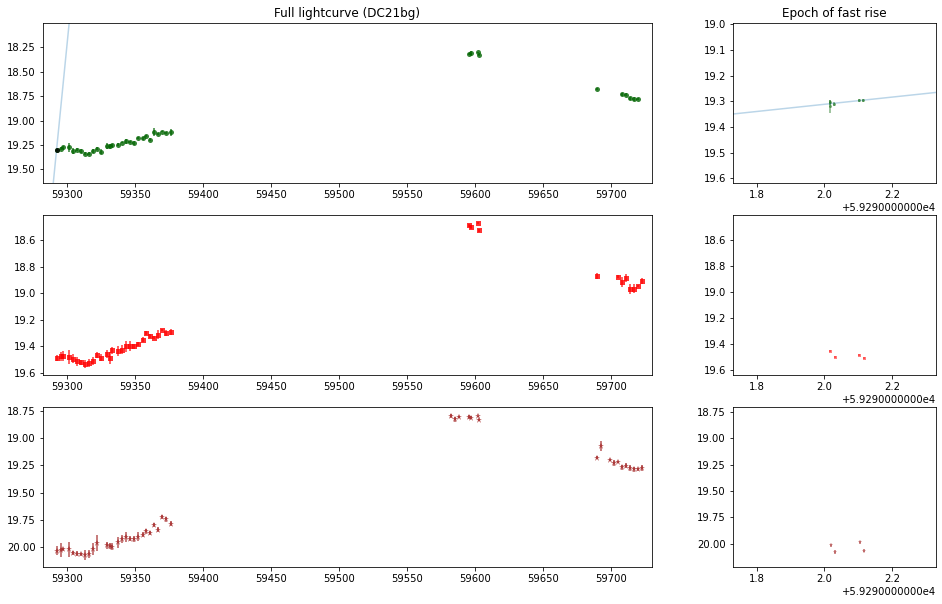

151.106470269117 2.38029222590548
7.507003881688327


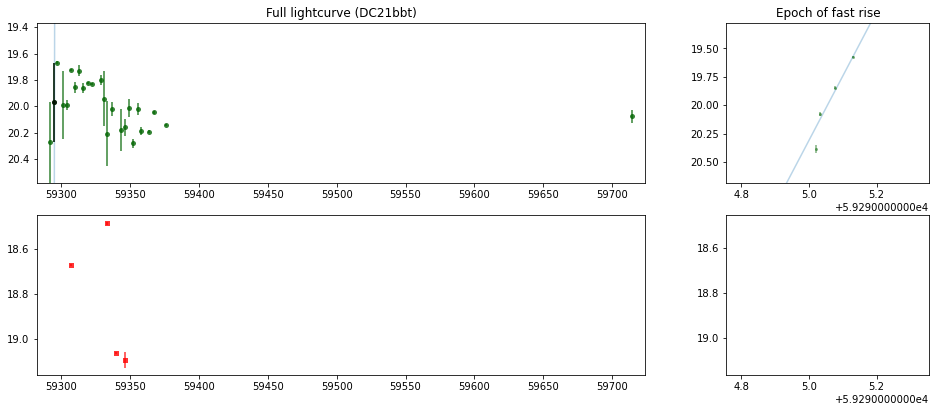

150.659437735959 1.62959743015293
12.578183832950918


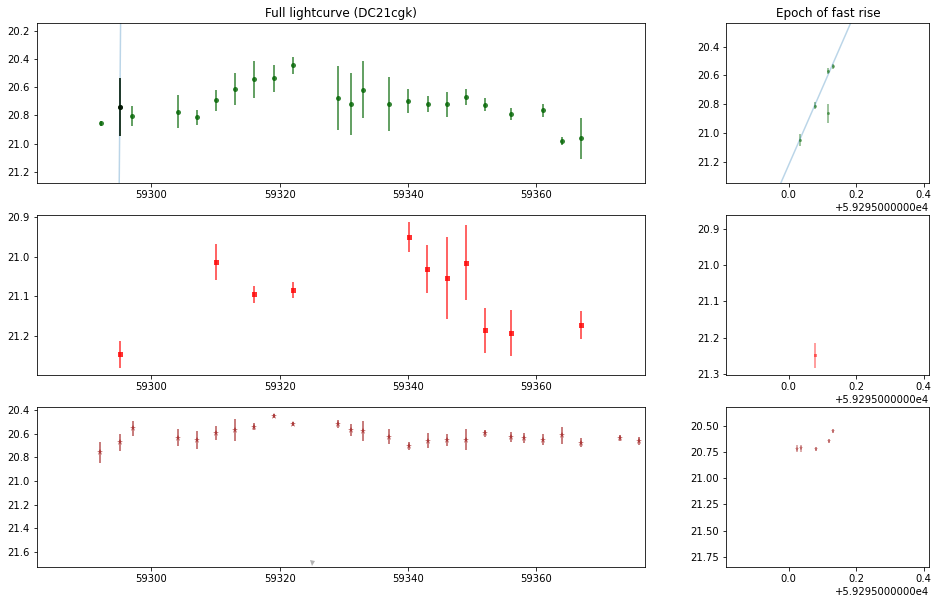

150.614471435729 2.45263397111162
4.181931334294629


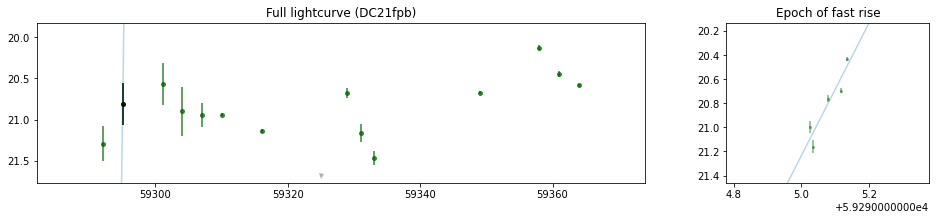

149.872811770218 3.18374540533403
3.0663140663301585


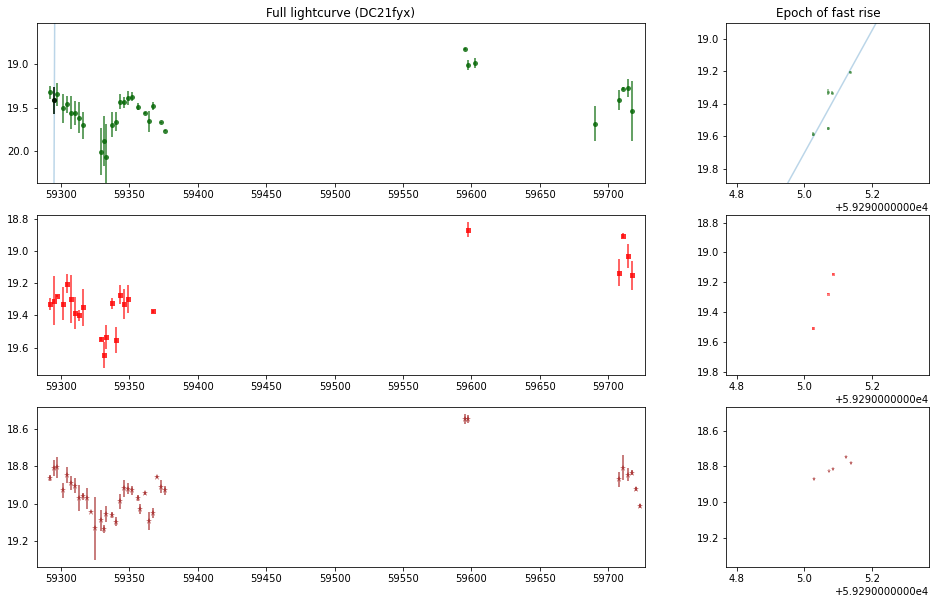

149.622425427163 1.5401656985385
3.1233453207516813


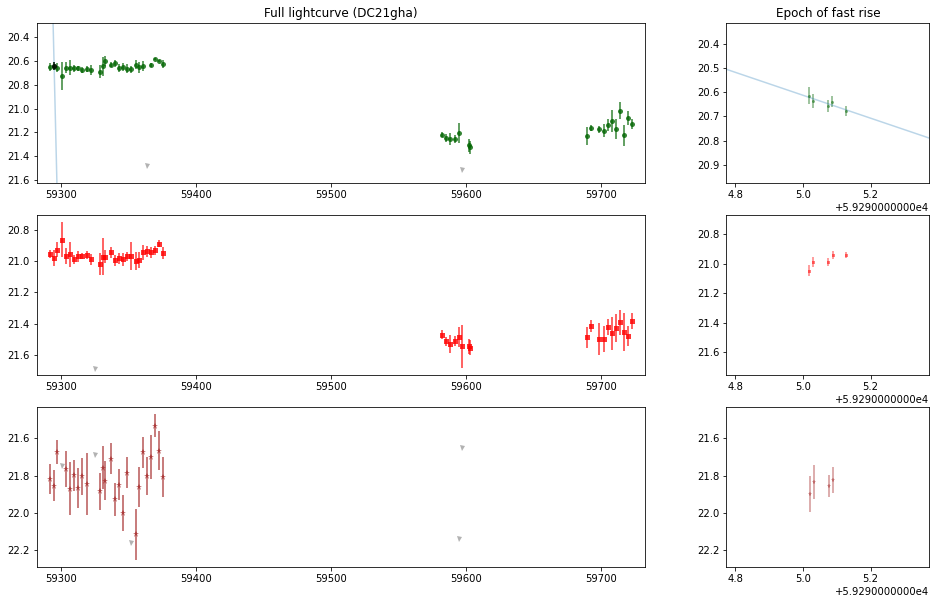

150.050535490839 1.22237545961567
5.488708172495493


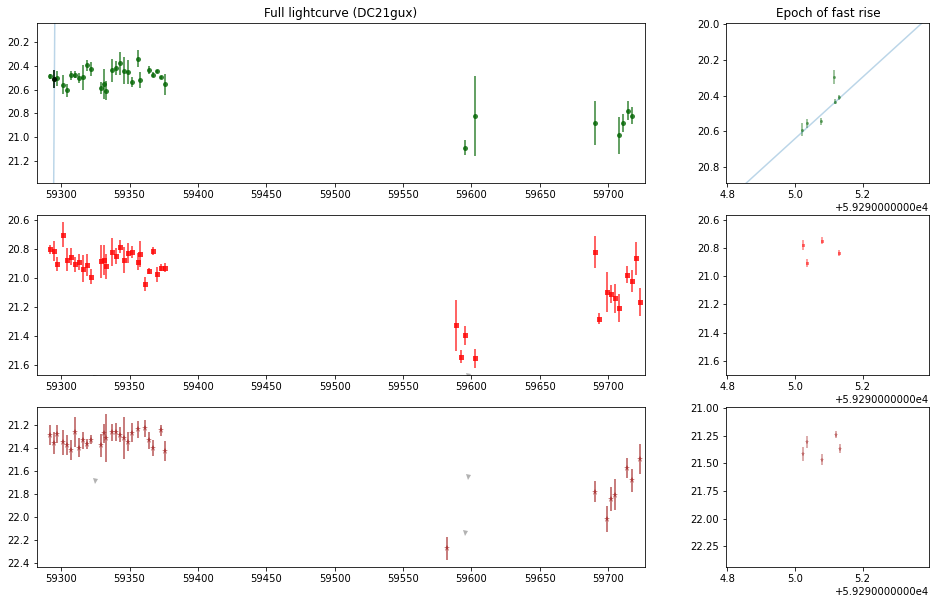

150.919084560817 3.38799019066906
5.370893811337236


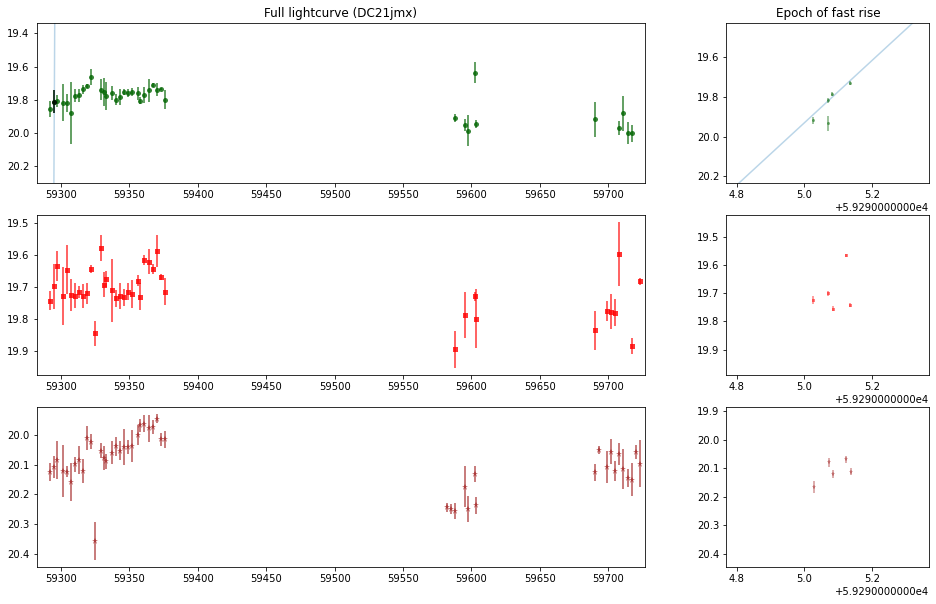

151.38128451412 1.15586638074914
5.437418395640359


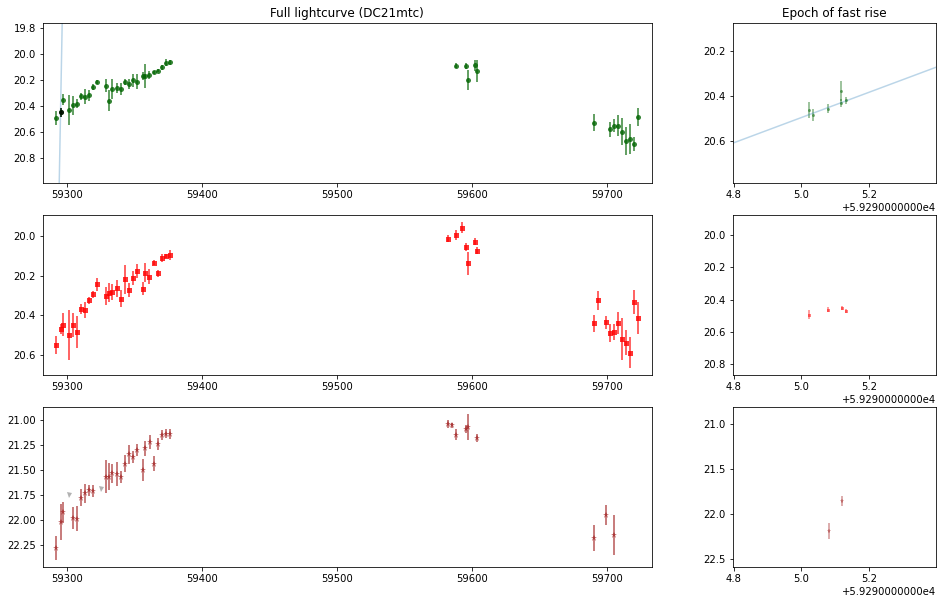

150.176622954608 2.47612388237575
5.640362593384585


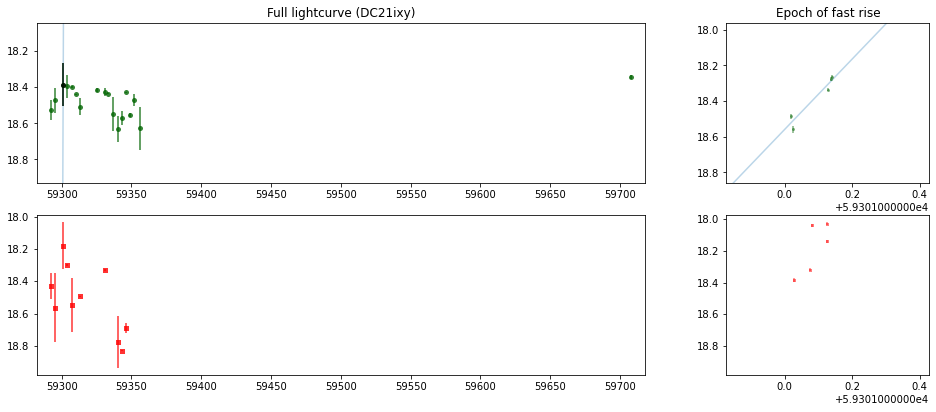

150.809733922557 2.66766244773284
3.908782710253717


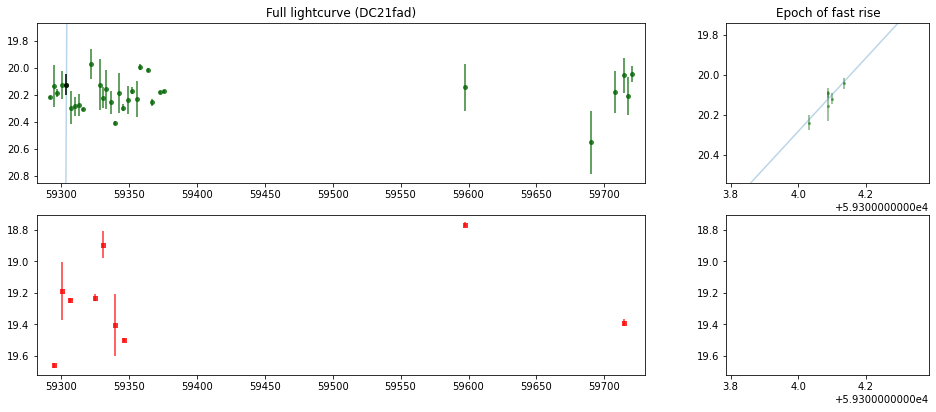

150.176622954608 2.47612388237575
3.395729221957431


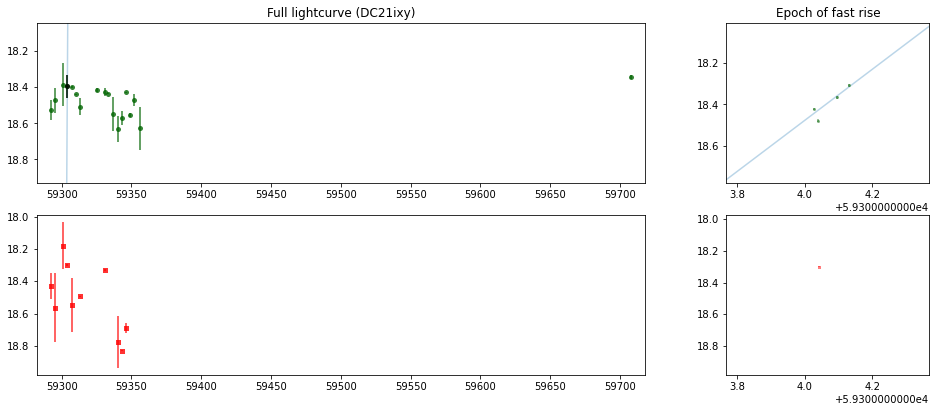

149.361207994526 1.93234551048092
6.7745682939976115


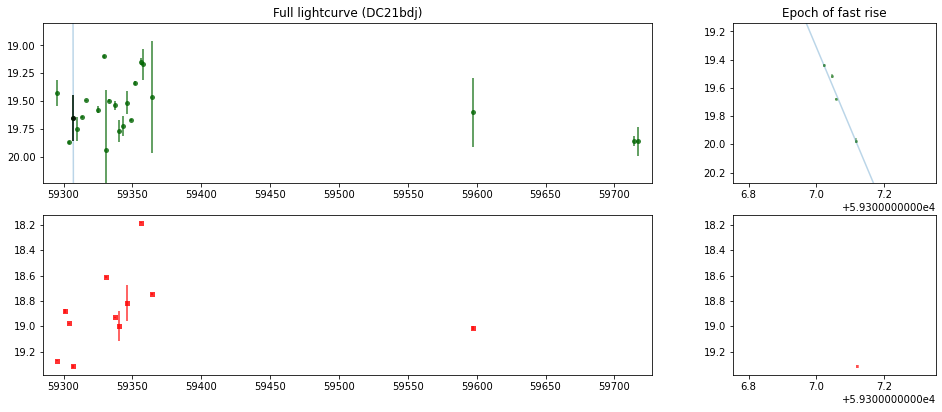

150.235599773046 1.22195047960736
4.811696064430503


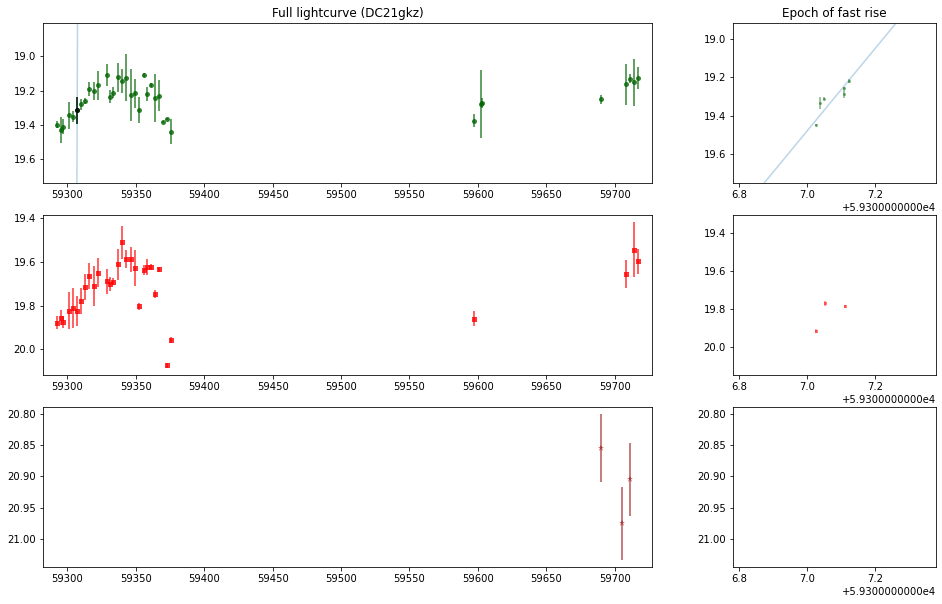

150.022280161697 3.83519713771283
3.4422632117714107


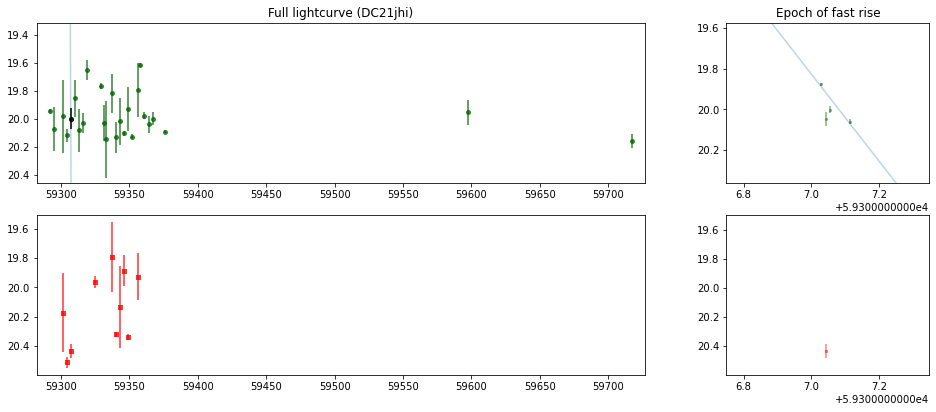

150.018432543545 3.84500240883476
3.9610455140802308


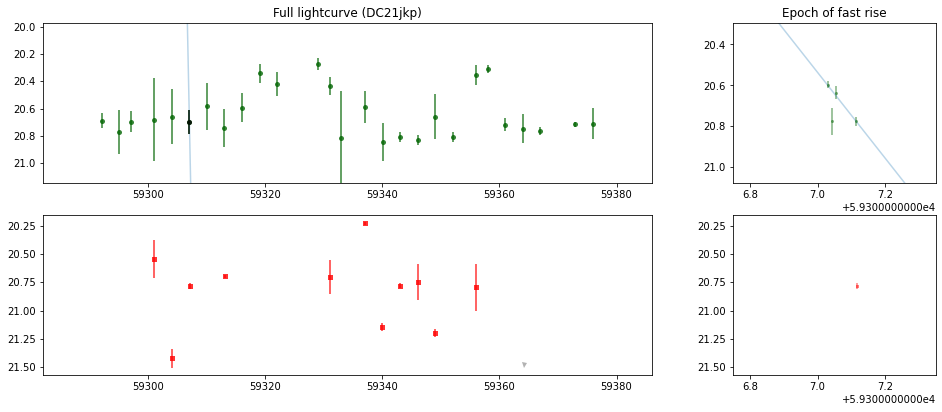

149.952576159222 2.22975683371827
5.667981389909098


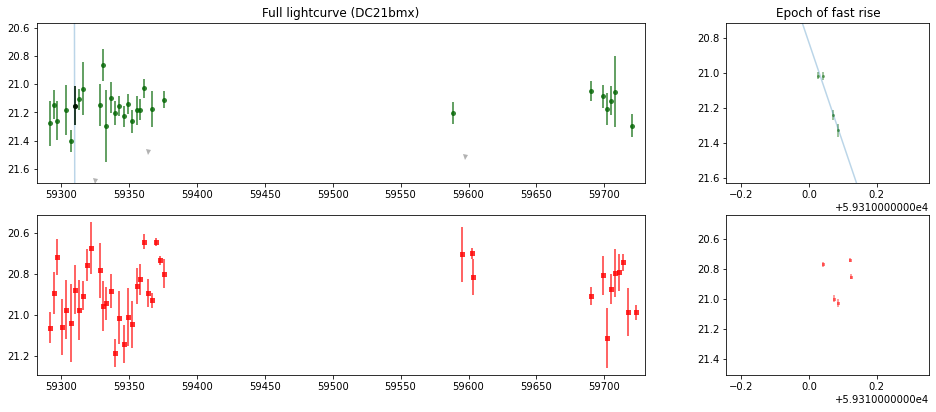

149.976035823178 1.92838296047832
4.0769944732810215


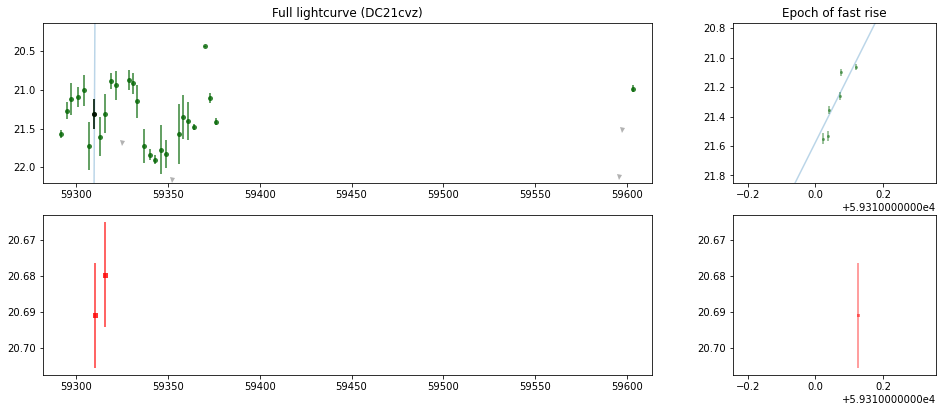

149.140728205265 3.38294049602752
4.239834966070905


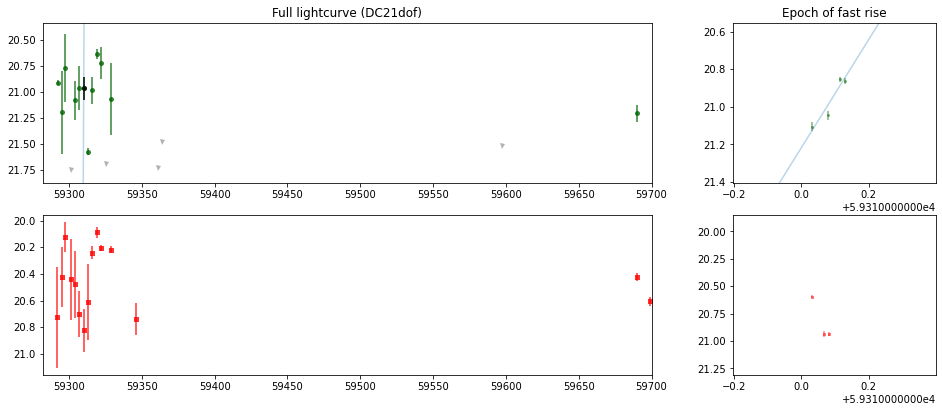

149.176385423376 2.09843986582877
3.9968269894799437


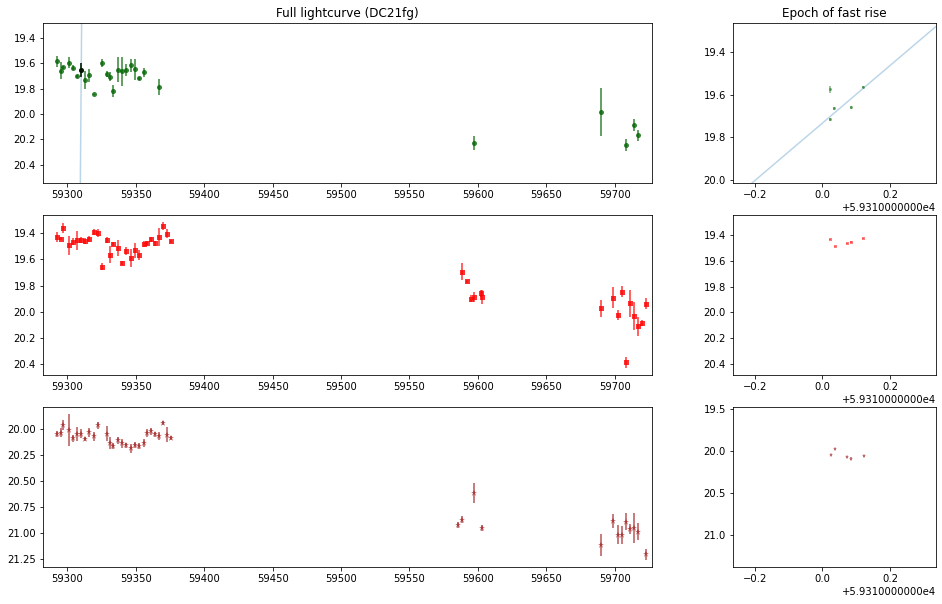

150.605532155715 3.41447452037441
3.328121481109172


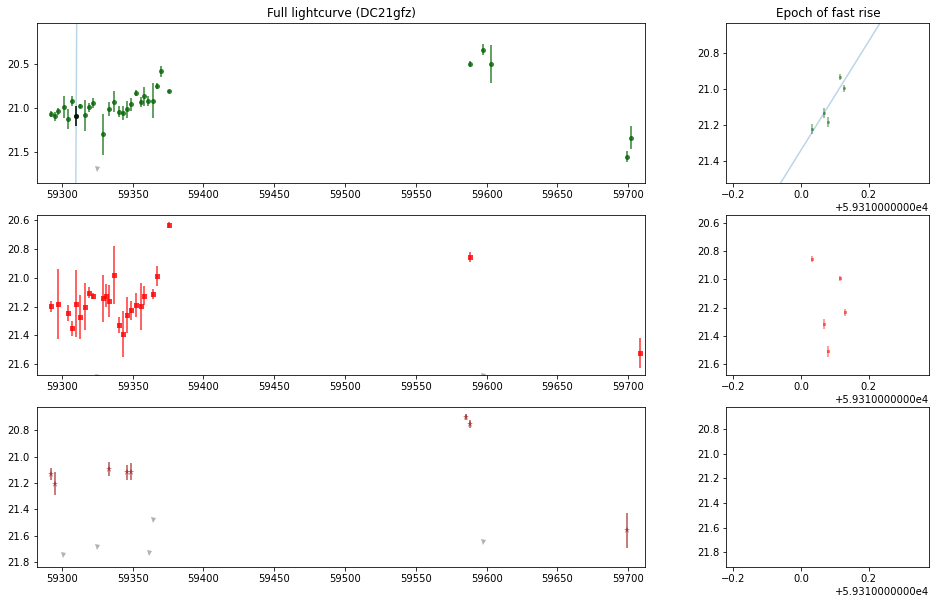

148.425893848204 1.64640310304622
3.288228813747397


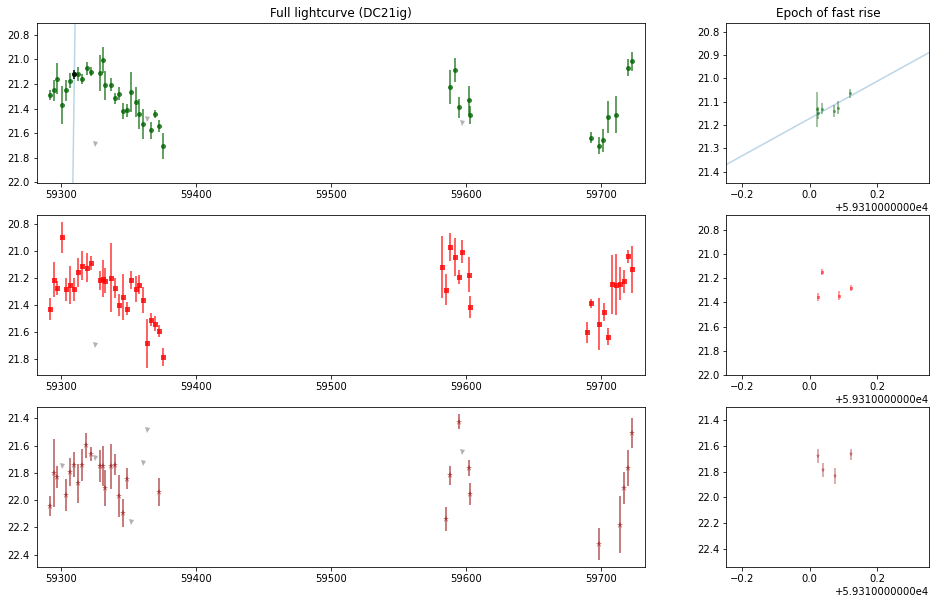

149.679691560402 1.34937001446612
6.75262511426545


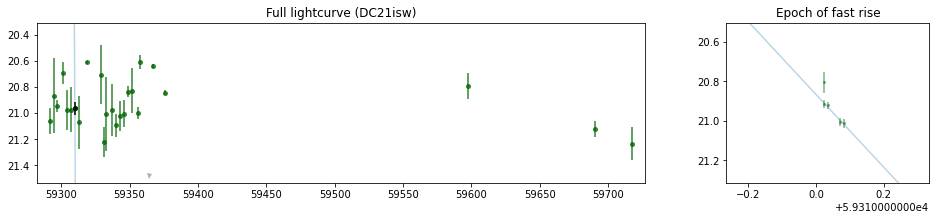

149.35048437706 1.13698256551118
3.5944810879913716


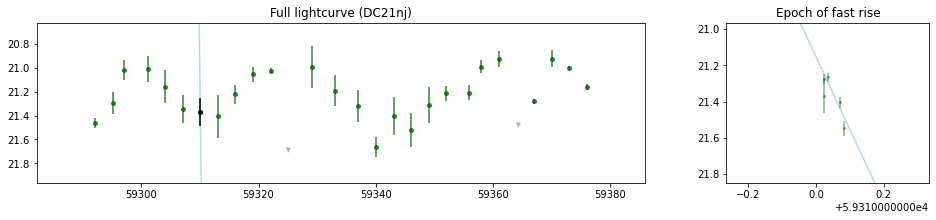

151.27341560085 2.21436338336554
3.1794999090333134


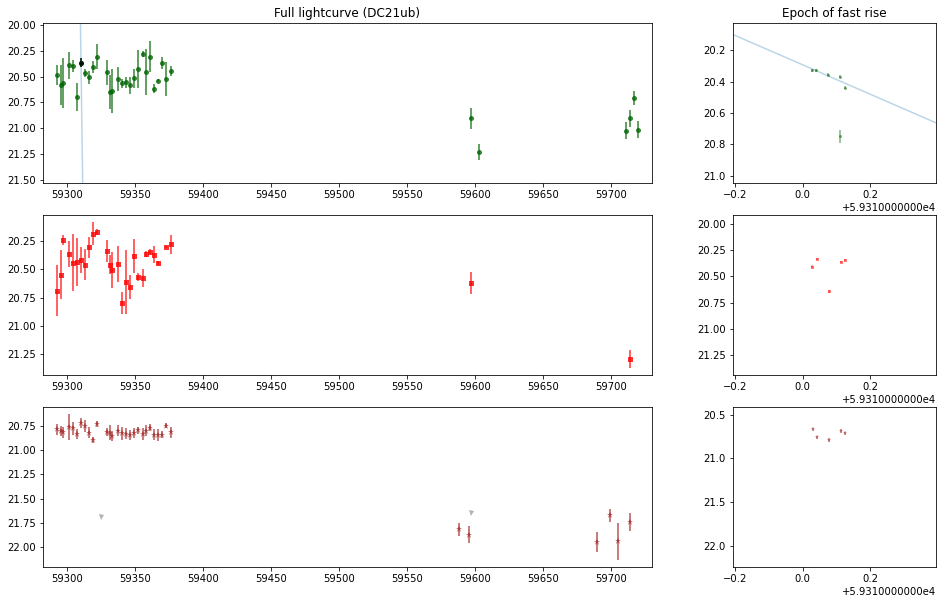

149.50384994345 2.01851133522174
3.951306293332917


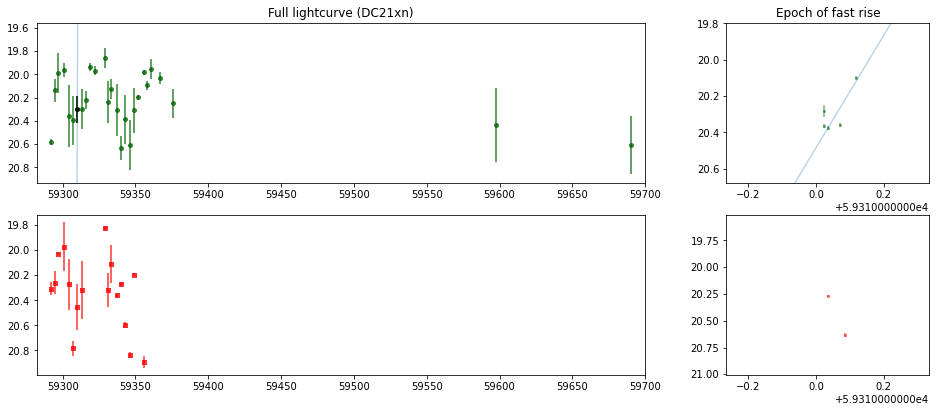

149.627647781016 2.49761287526819
3.4654003531004522


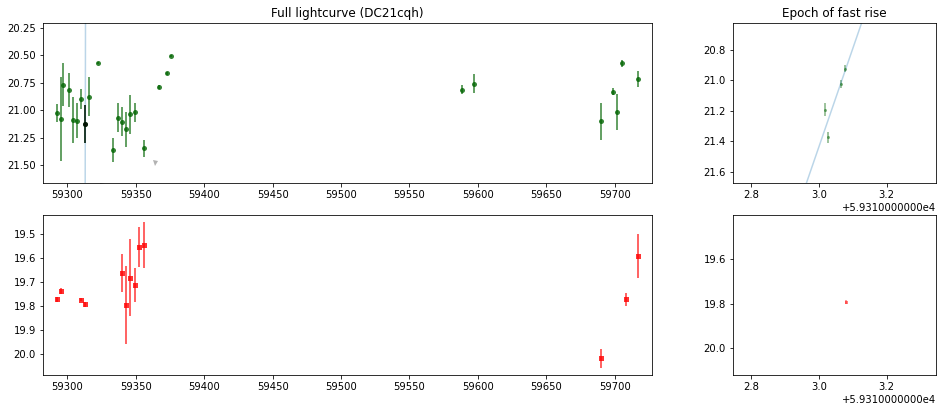

149.176385423376 2.09843986582877
3.1256742220403324


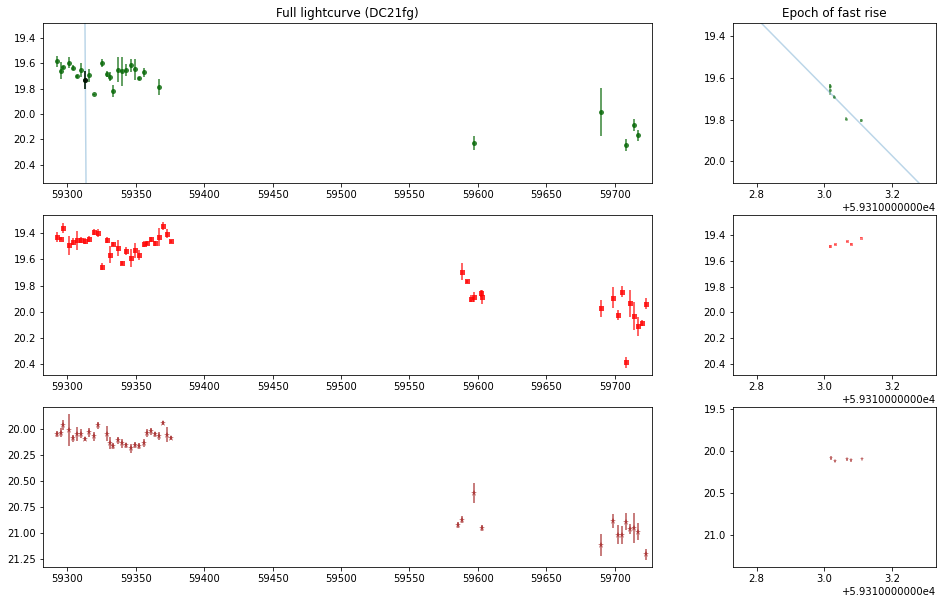

150.288184528885 2.56271155791764
4.284099139976587


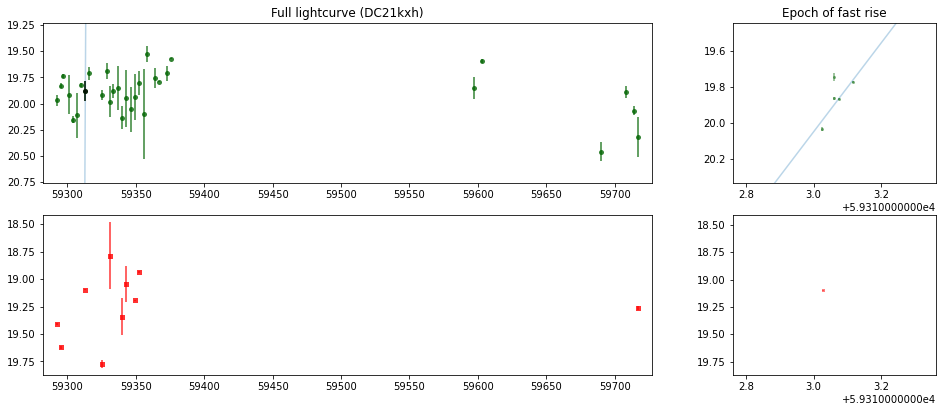

150.074651471593 3.55989648813894
3.6734520004919706


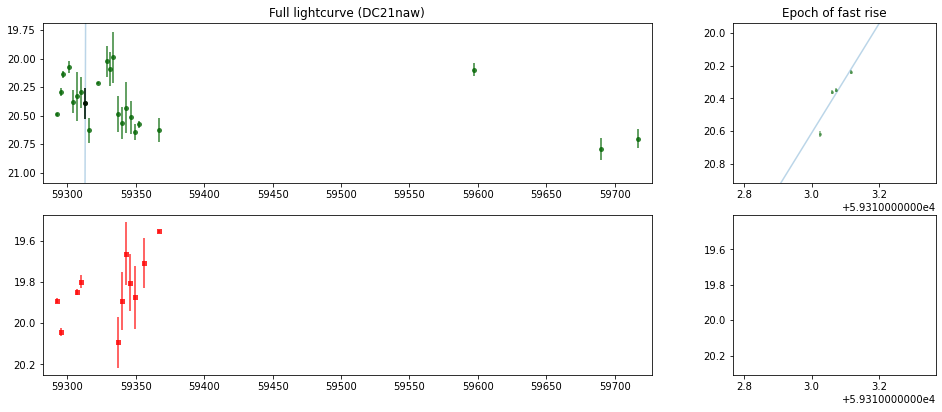

149.35048437706 1.13698256551118
4.528143719397973


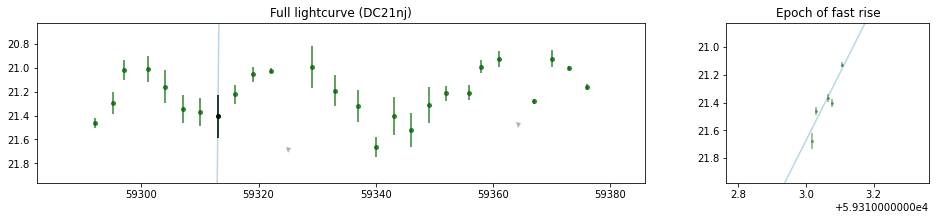

149.835433314985 3.89233708145792
4.333797562816637


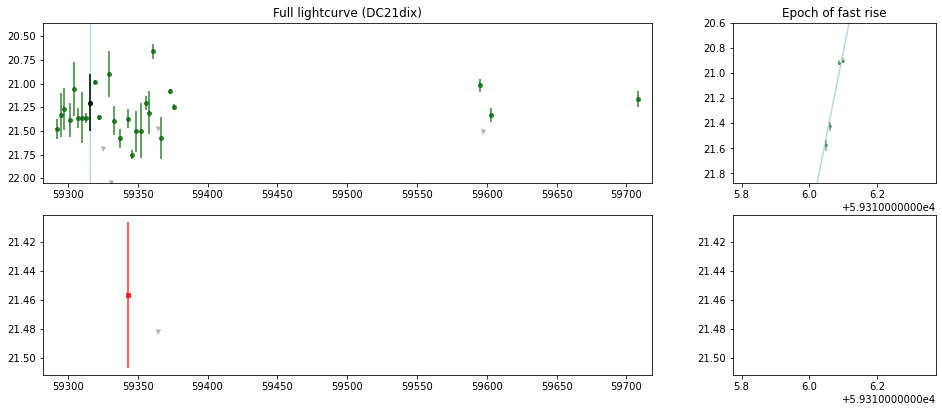

150.495950221365 2.9927074836154
3.6772613258603077


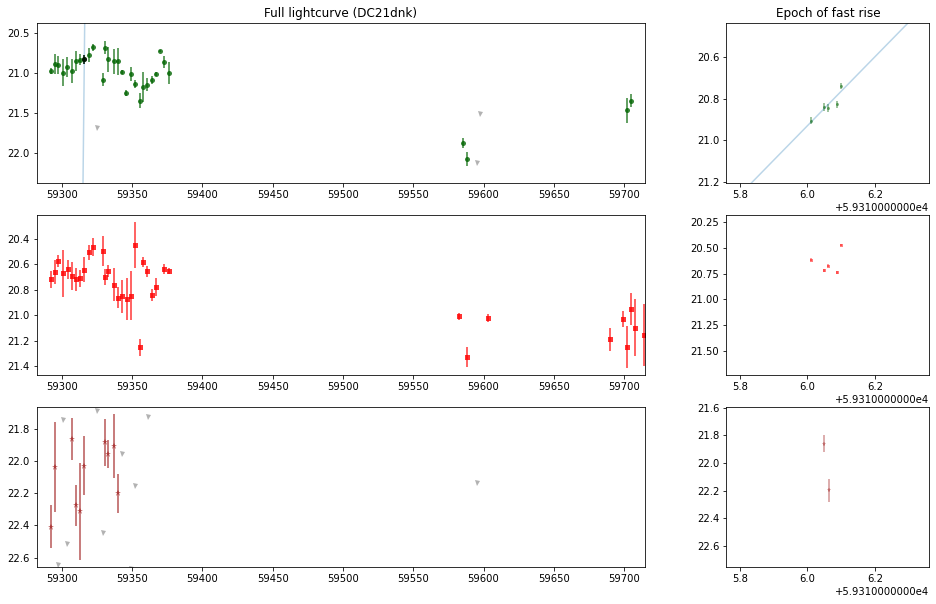

149.140728205265 3.38294049602752
3.2866556452638487


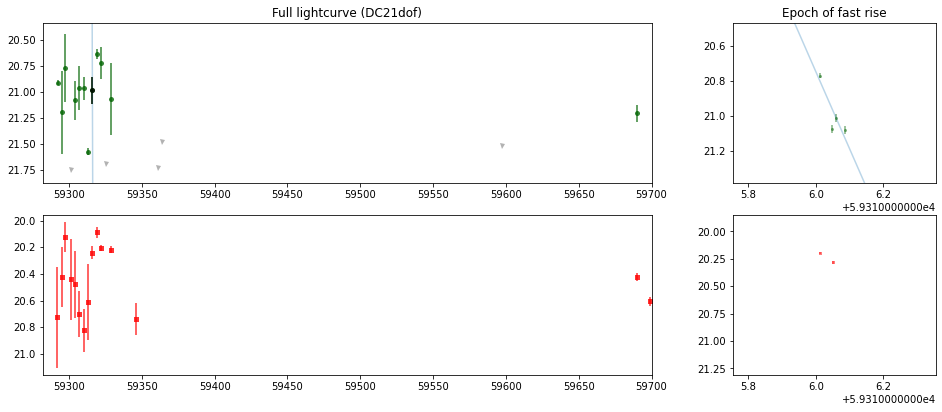

150.48206751482 2.99118636403027
12.414996494800686


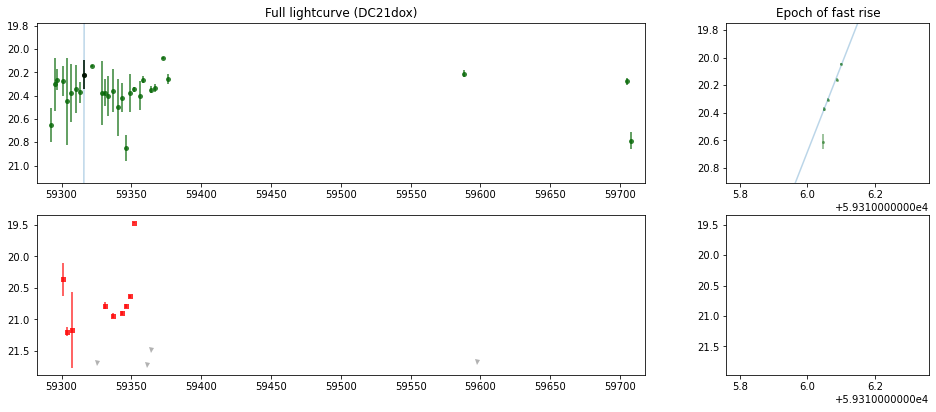

149.117872961373 2.81672960235096
15.999380639690159


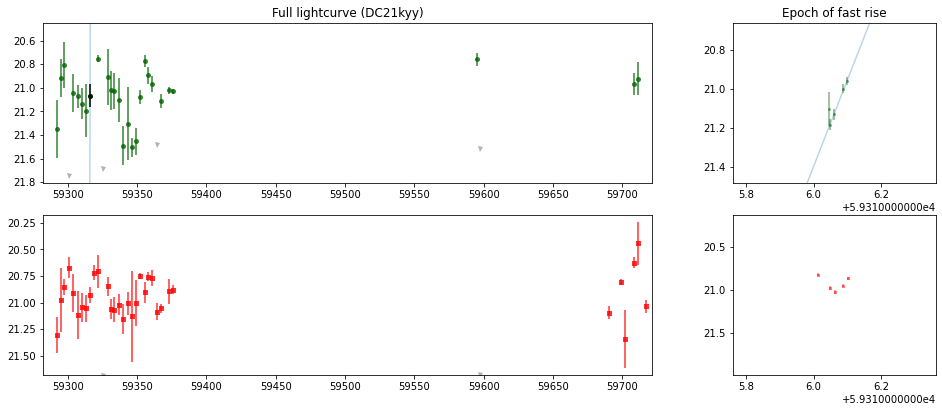

150.334752236455 3.22098999496976
3.4528764743907514


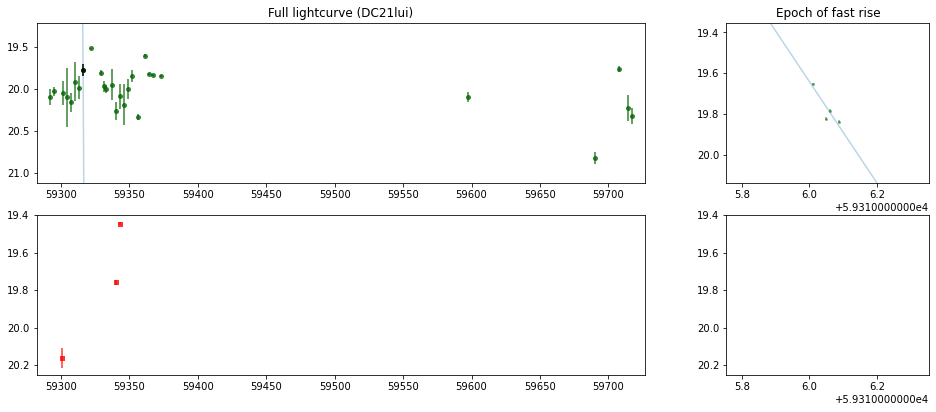

149.761544005505 2.31842918749783
3.598118265041073


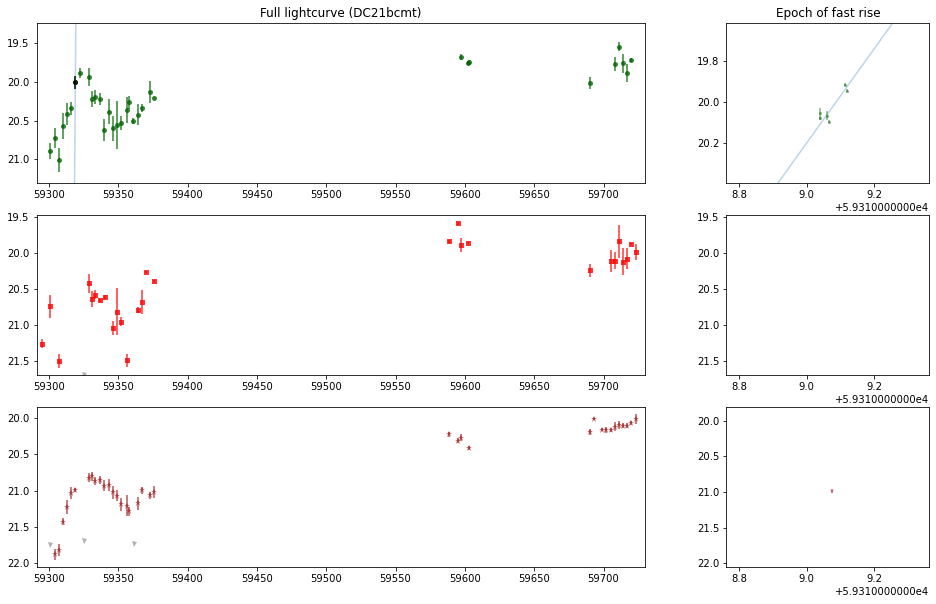

150.081420719431 1.99053726412057
3.575501600945094


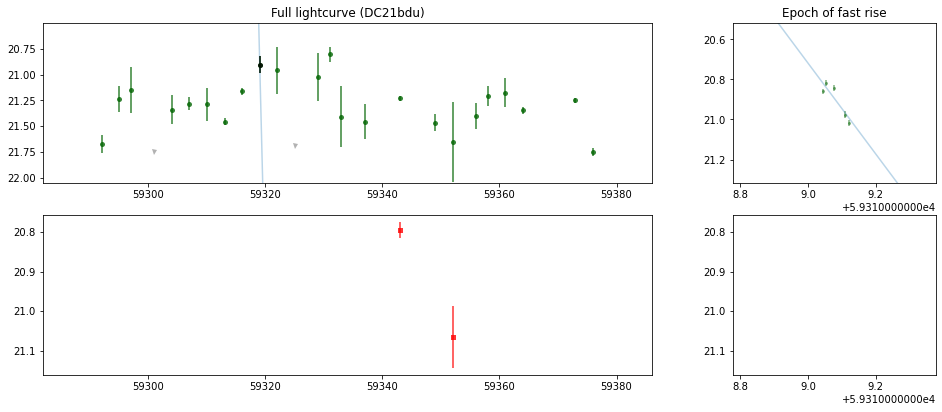

149.622425427163 1.5401656985385
7.270284216634129


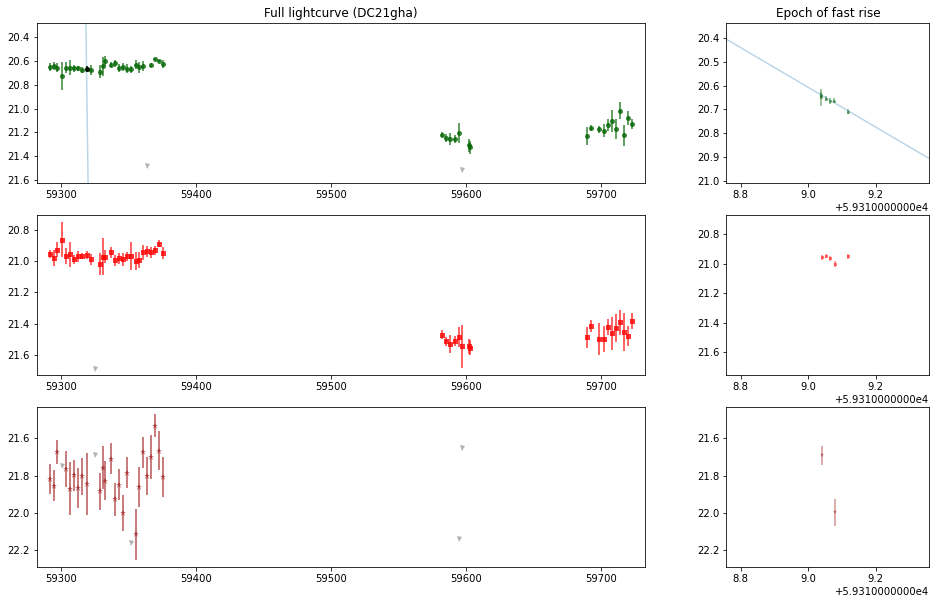

151.642340656559 1.96868293668636
3.3940151715629554


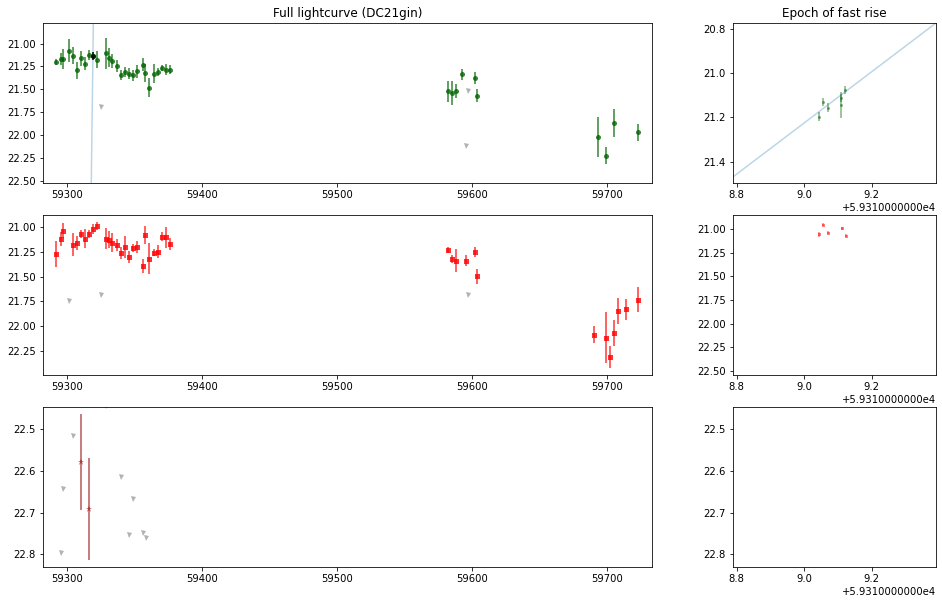

151.184742411599 1.68418881282175
3.178791953983499


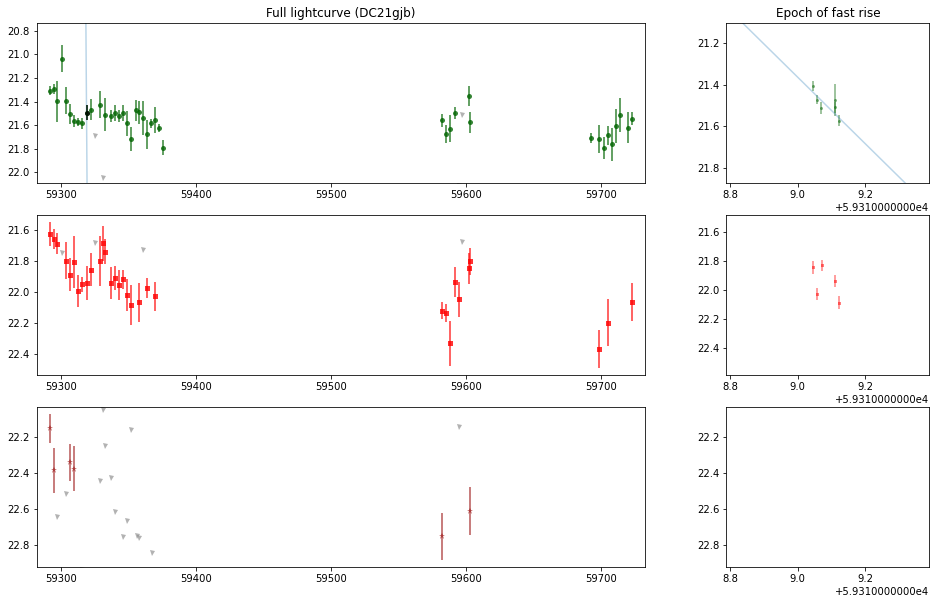

150.235599773046 1.22195047960736
3.4058742497854007


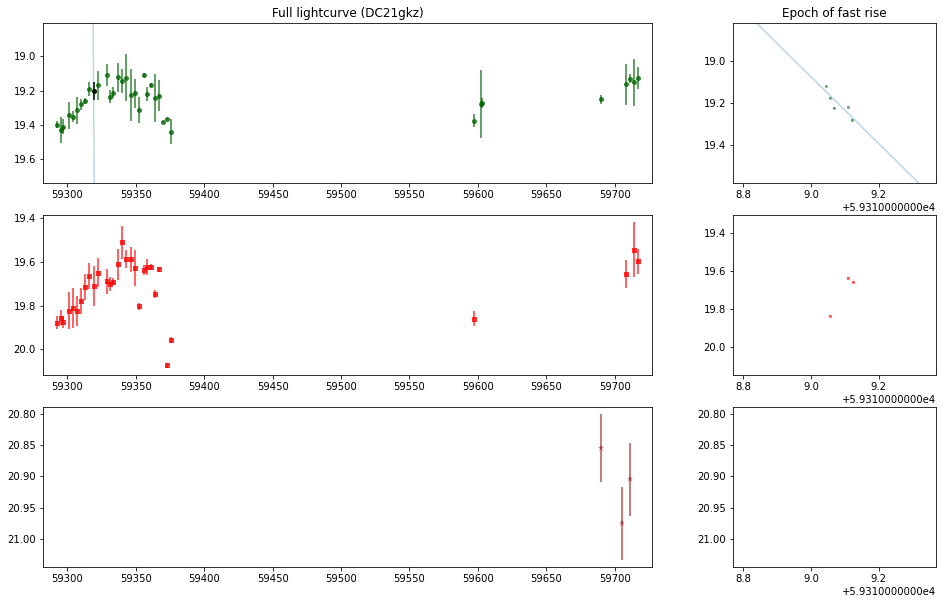

150.431050485749 1.93525905481042
3.677063542100805


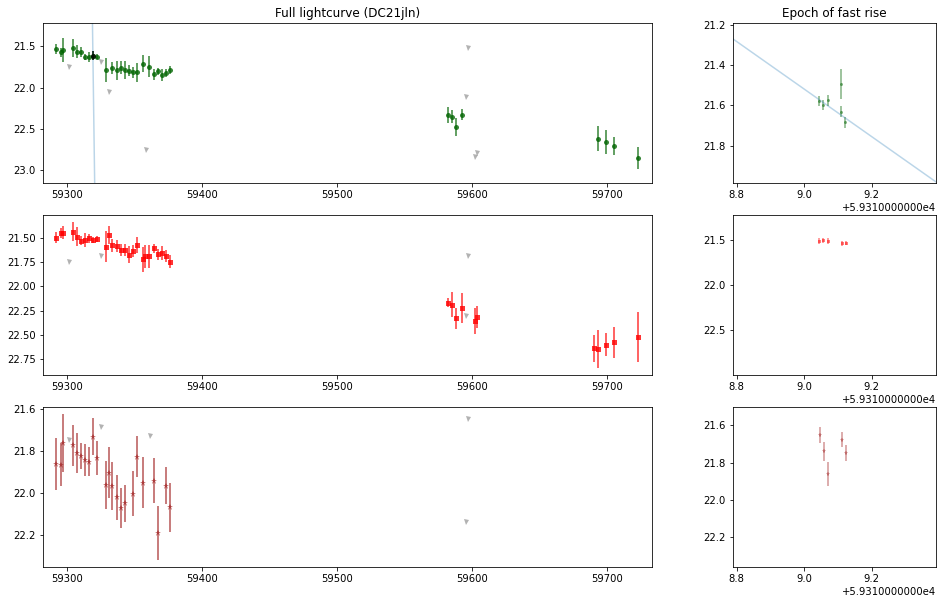

151.178375777174 2.06323962834823
4.653709574277378


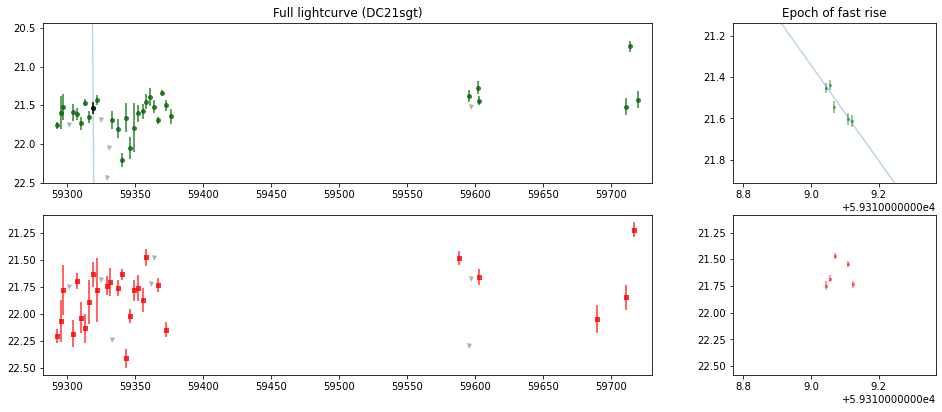

149.50384994345 2.01851133522174
6.591862572987764


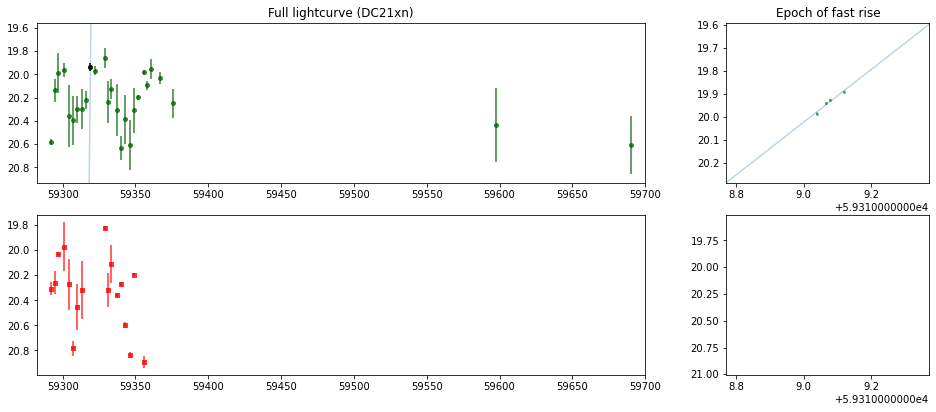

149.761544005505 2.31842918749783
3.788795832678083


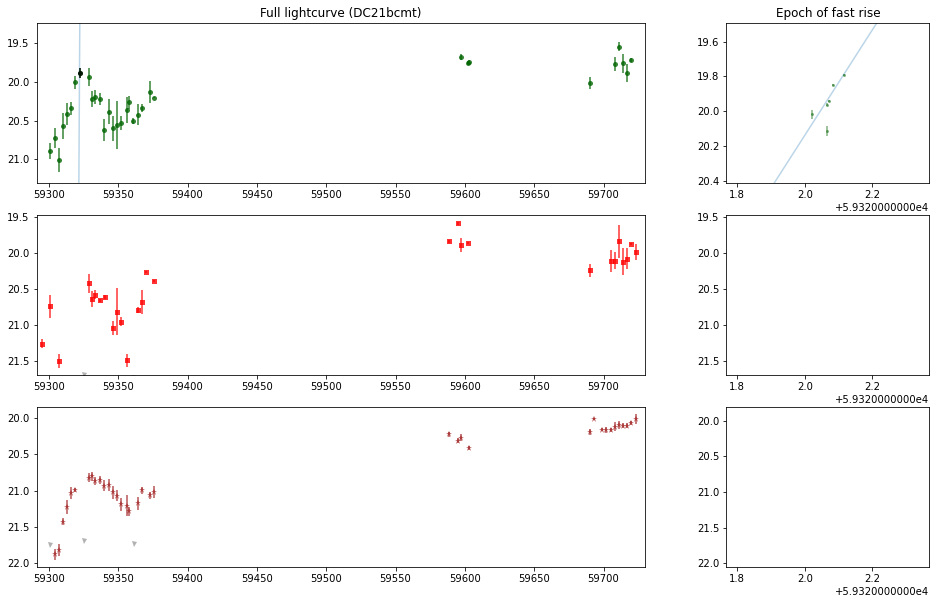

150.762173898723 1.86900871152144
3.1829971712144123


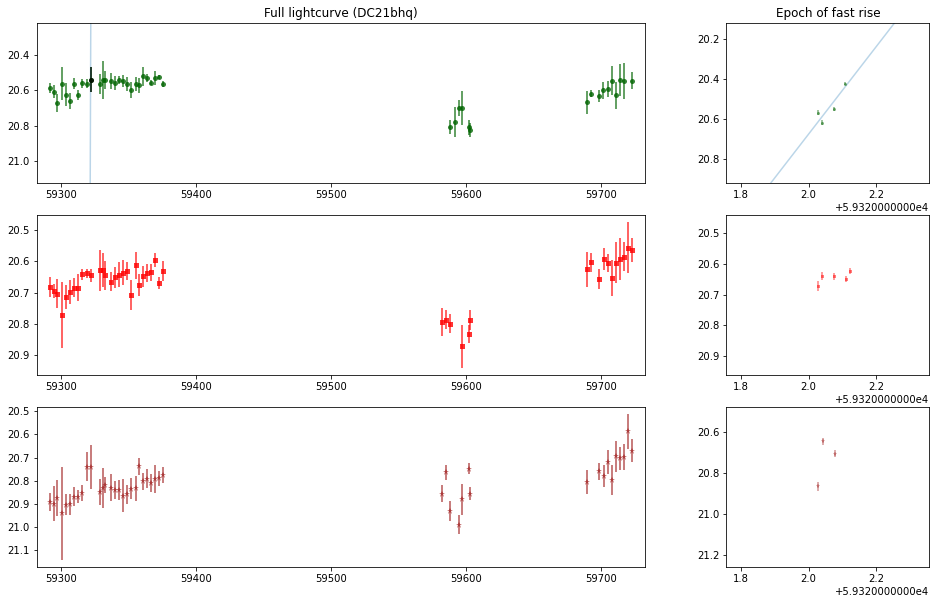

150.901565860547 2.34536820683541
5.293591870989969


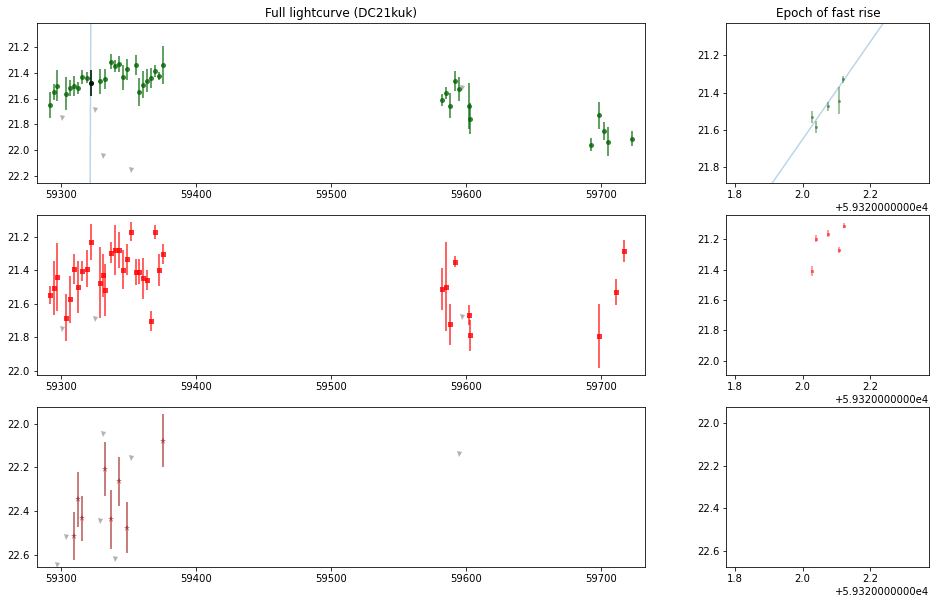

151.505316207659 1.32248878090574
3.0195834745208976


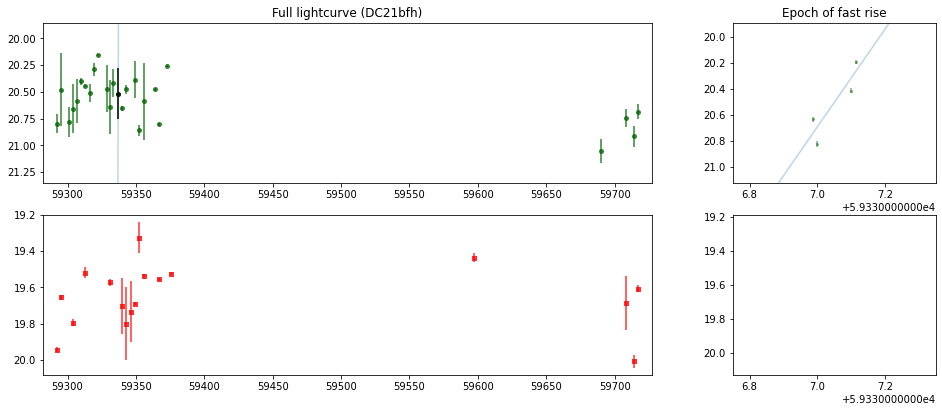

149.394333505306 2.68548874455788
6.937420840782595


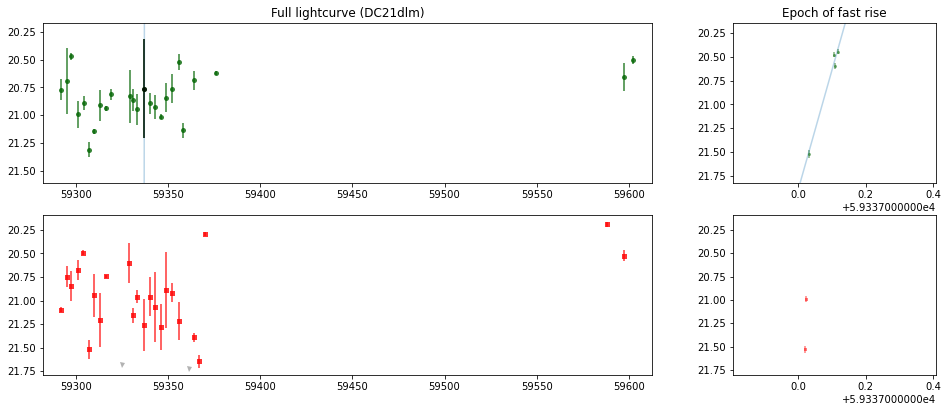

149.303916121536 3.57793223638818
6.2956166481974245


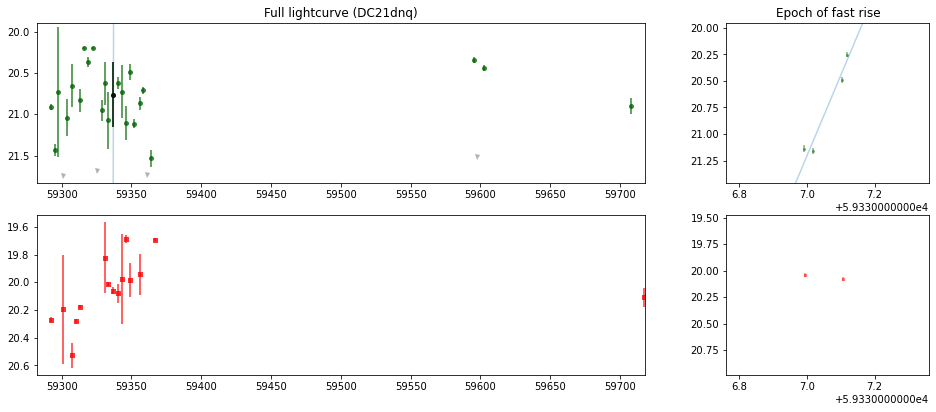

149.479519864096 2.80181023790451
4.080397329096281


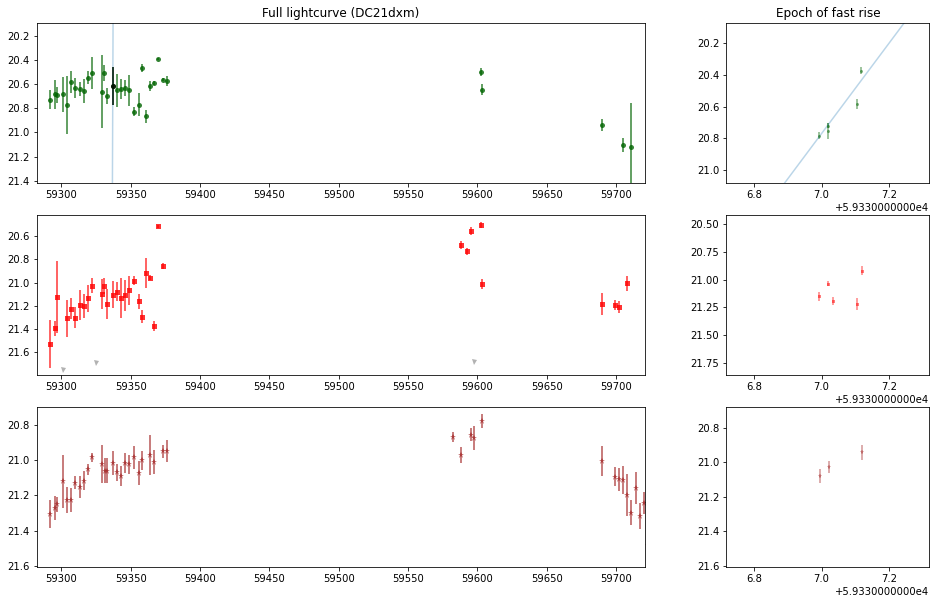

149.515796687487 2.55721072608448
3.4062712773048114


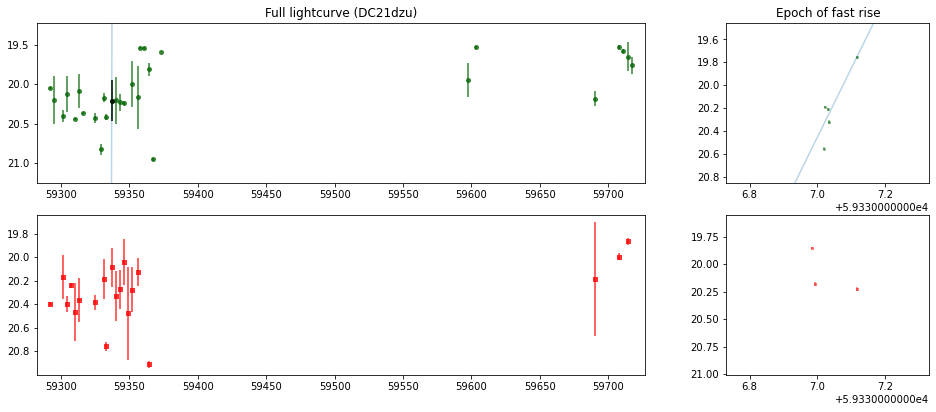

149.14070455081 3.38293549090955
6.248564794889991


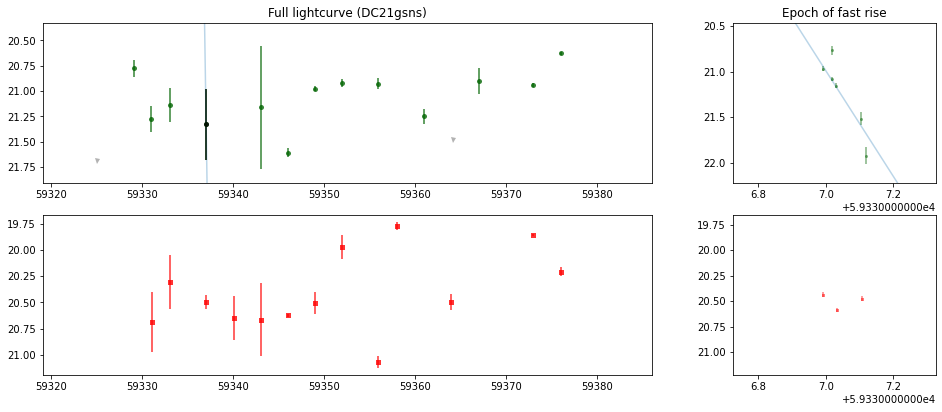

150.022280161697 3.83519713771283
4.2803542501023015


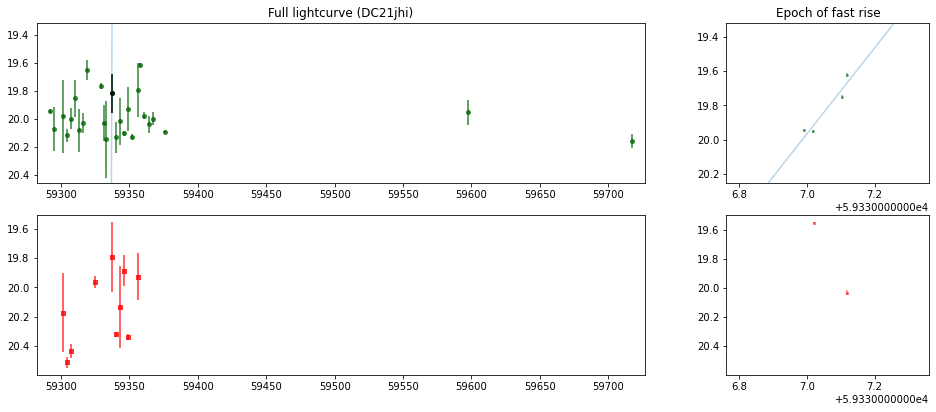

150.018432543545 3.84500240883476
9.793038858535486


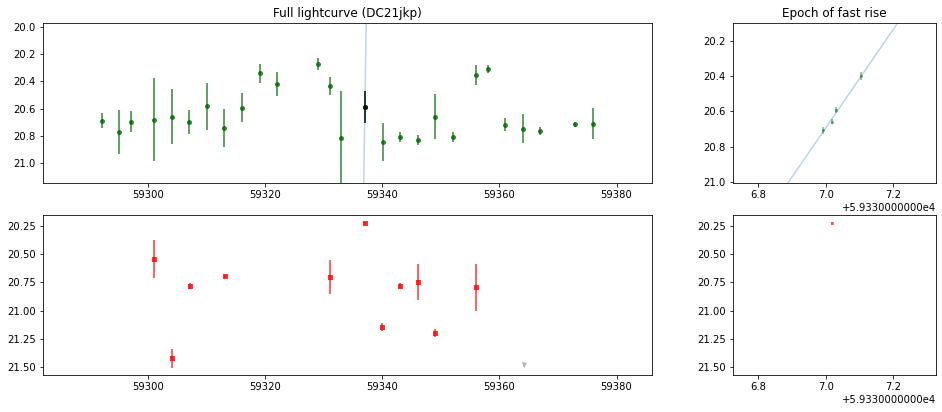

149.325618683114 2.50399332064946
3.458991690947604


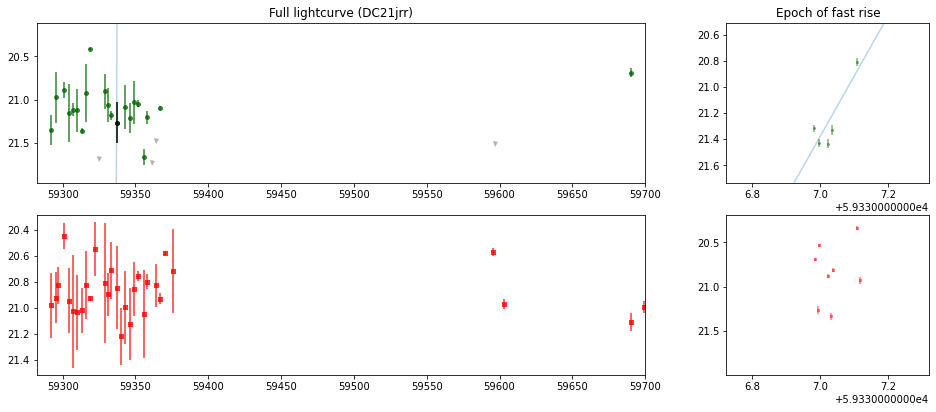

149.660508035641 2.53428859833873
7.178893166397671


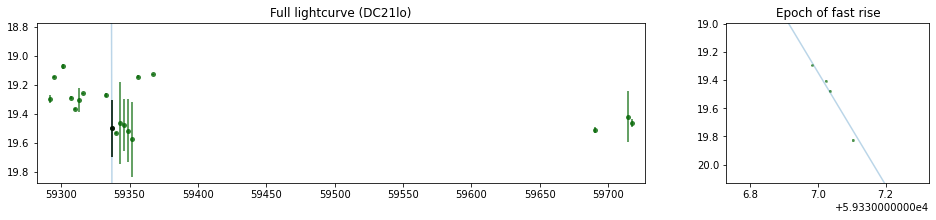

151.390216925963 2.14597786037645
5.606620643722974


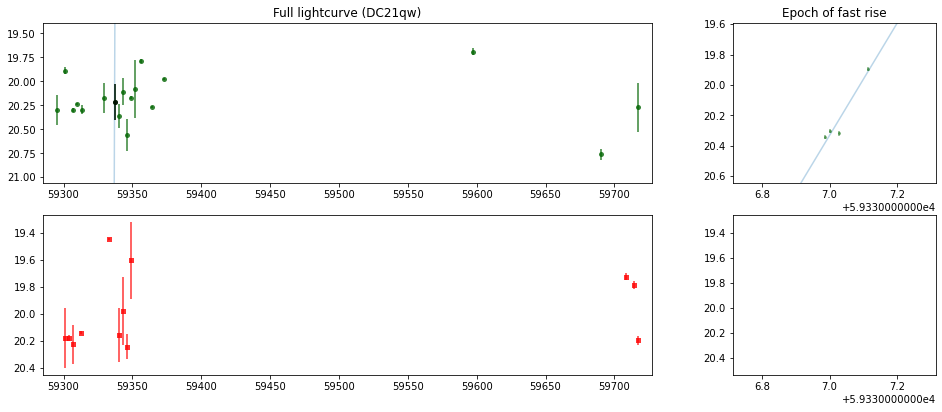

149.097478194545 2.0710407308876
14.761691691038818


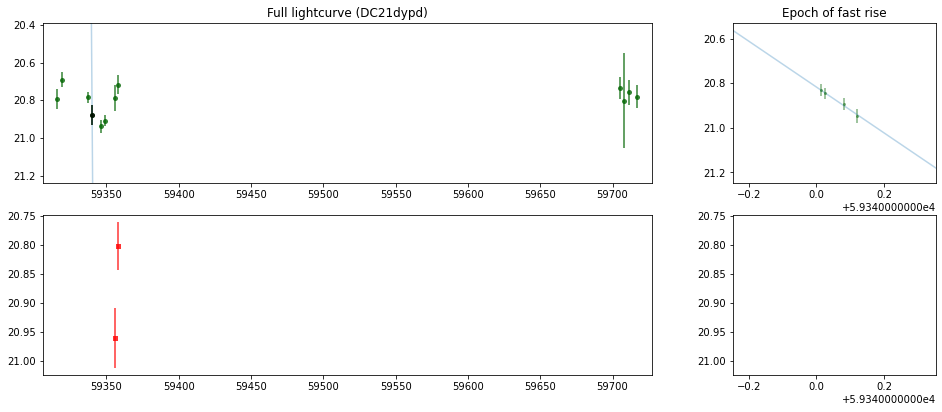

149.180021571229 3.07441943659
6.0961112560562505


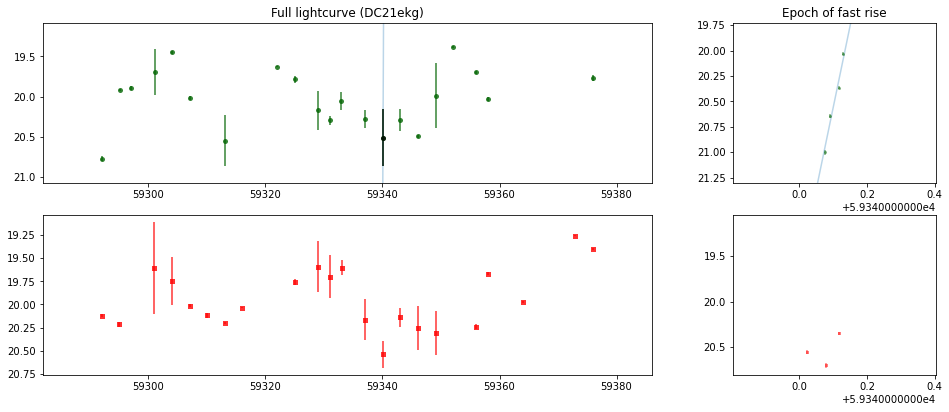

150.004903248609 3.25002416623346
7.910101575498482


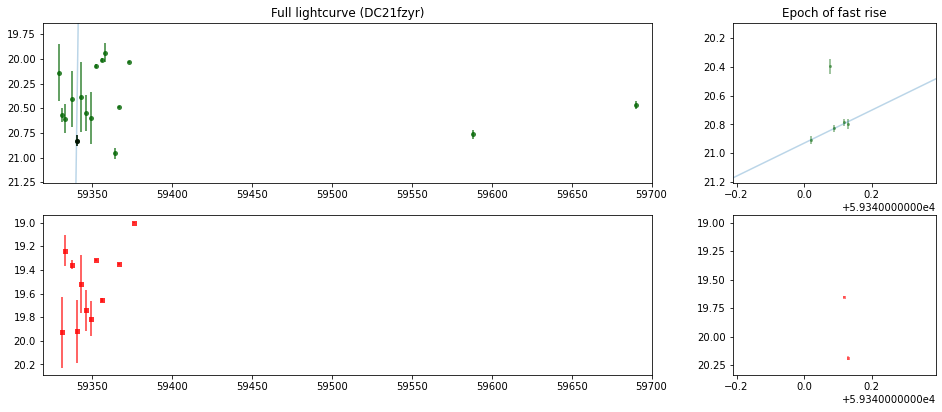

149.240262242496 2.12225448477888
7.882449540708911


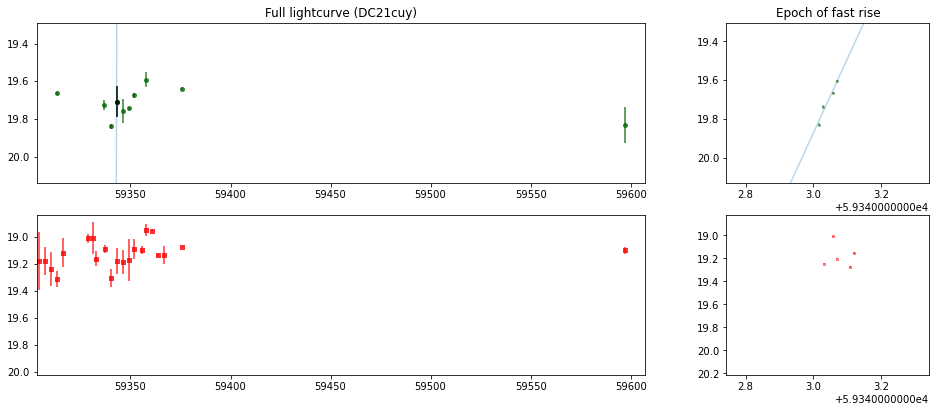

149.048521762603 2.50030518712432
3.027826960571938


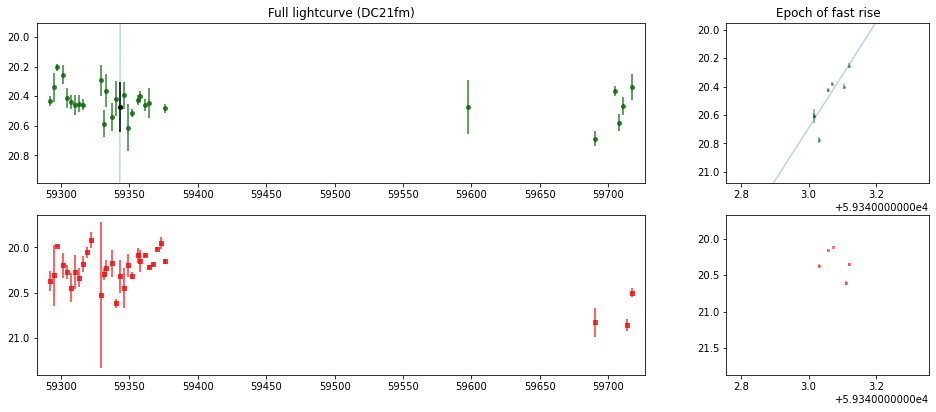

149.67128862982 2.53339847081247
3.056059280483086


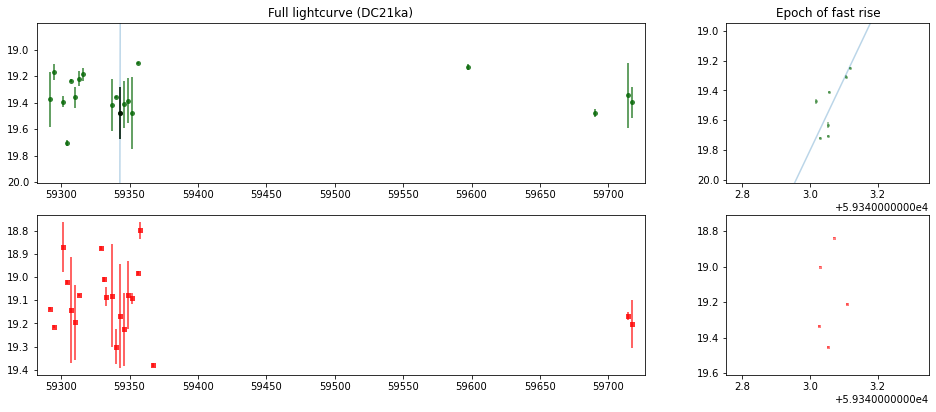

149.50384994345 2.01851133522174
4.33456272964455


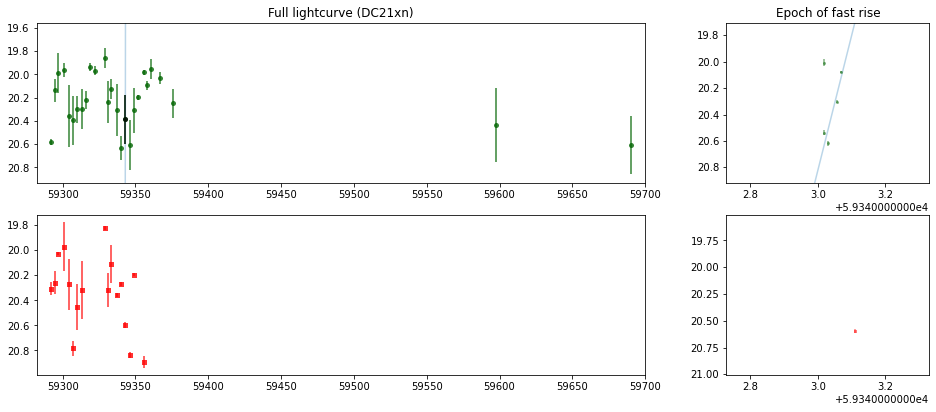

149.761544005505 2.31842918749783
7.529917726791221


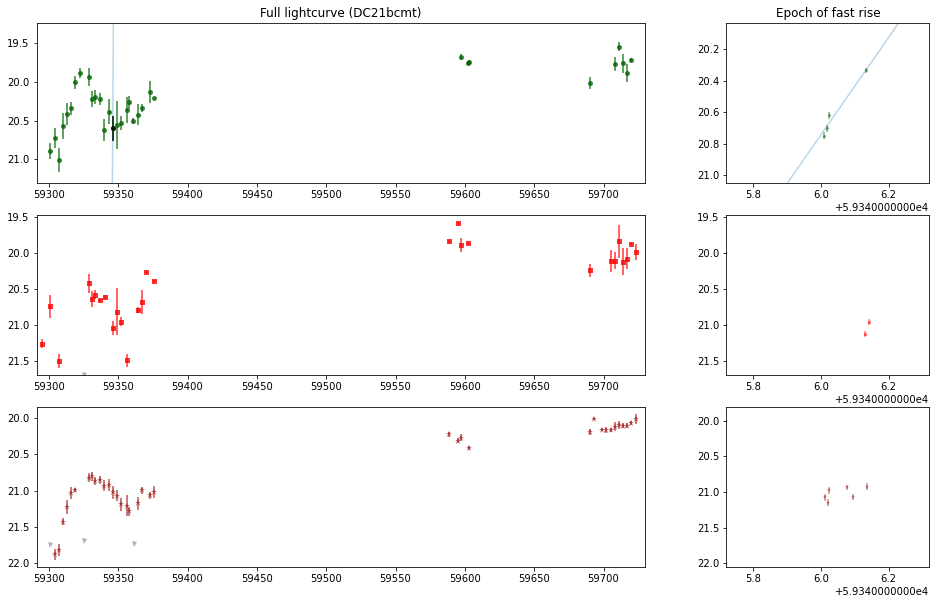

150.762173898723 1.86900871152144
4.459163432447036


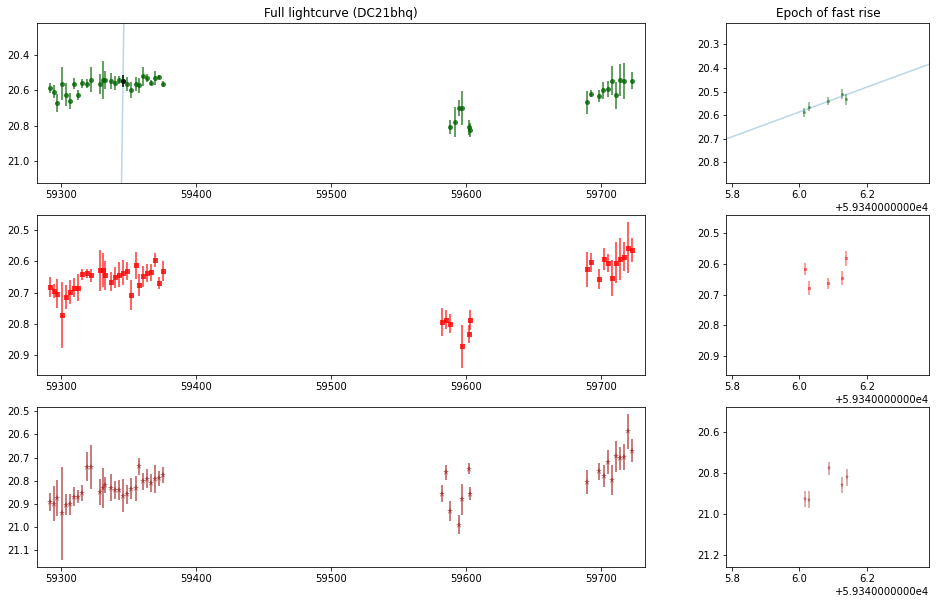

149.619105606356 2.22780728199051
3.93325387007341


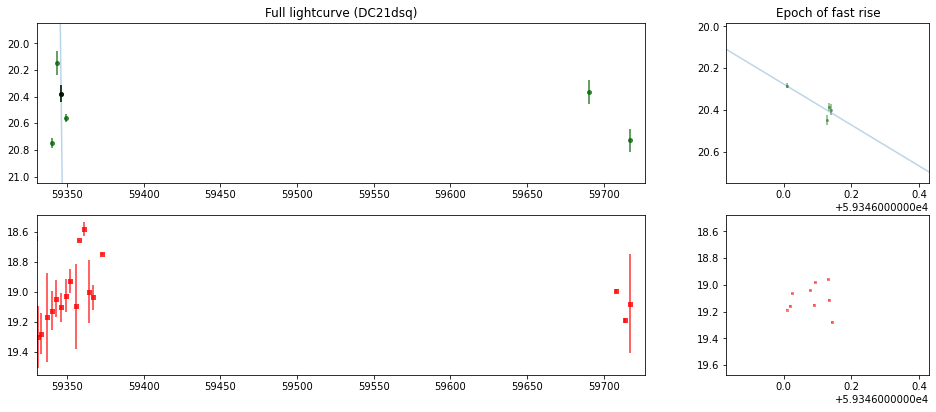

149.924455940336 3.13761780856375
3.2065607173061776


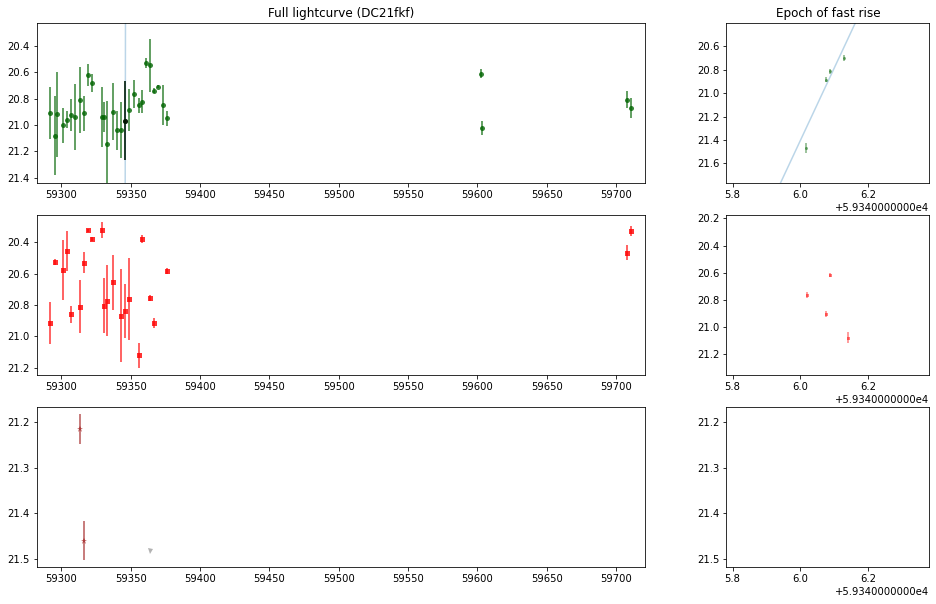

149.268161938194 2.48388243722833
4.289582909104593


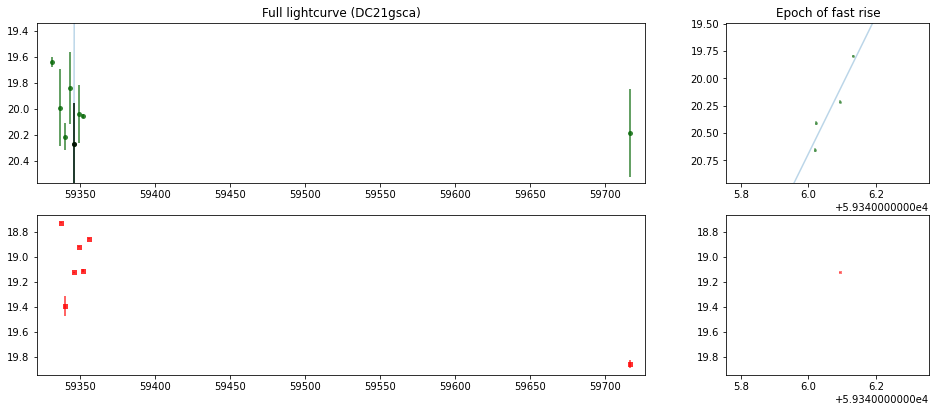

149.936289627144 3.18994924158587
6.421508301758234


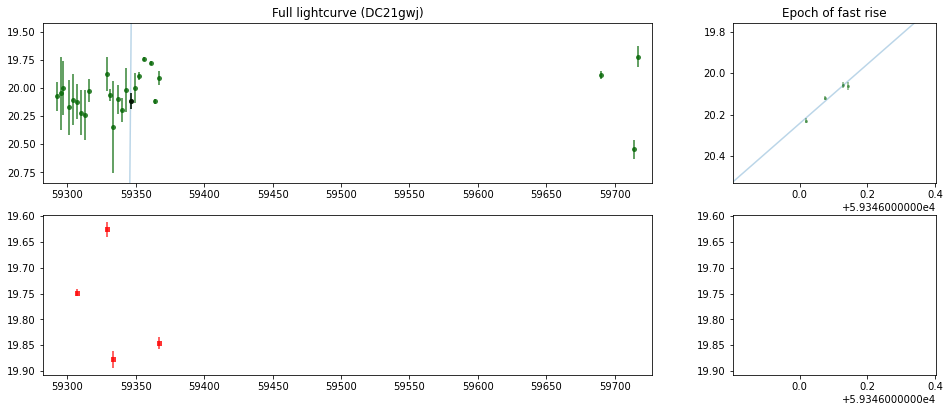

150.659437735959 1.62959743015293
3.619250679047867


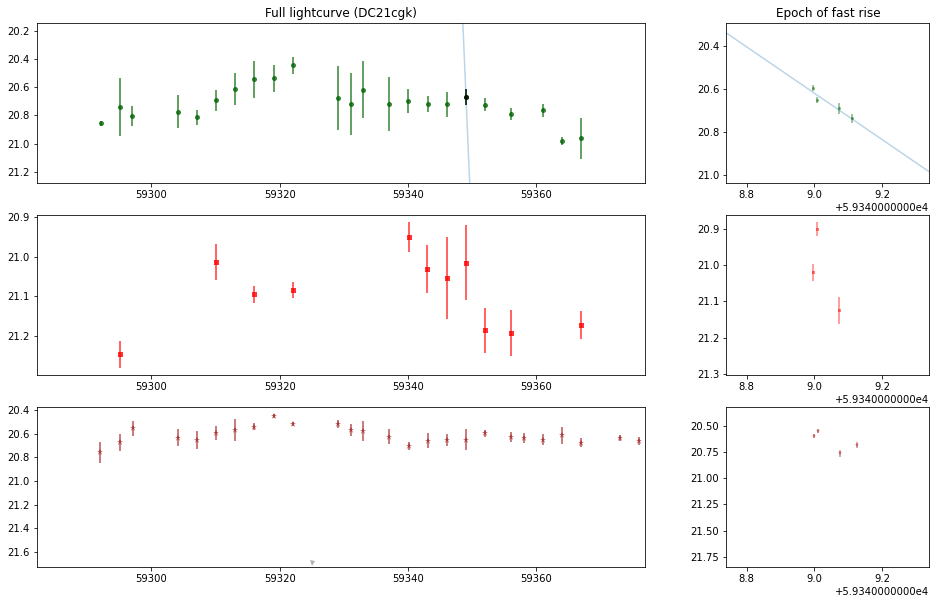

149.24705006546 2.19493471205774
5.735678853964492


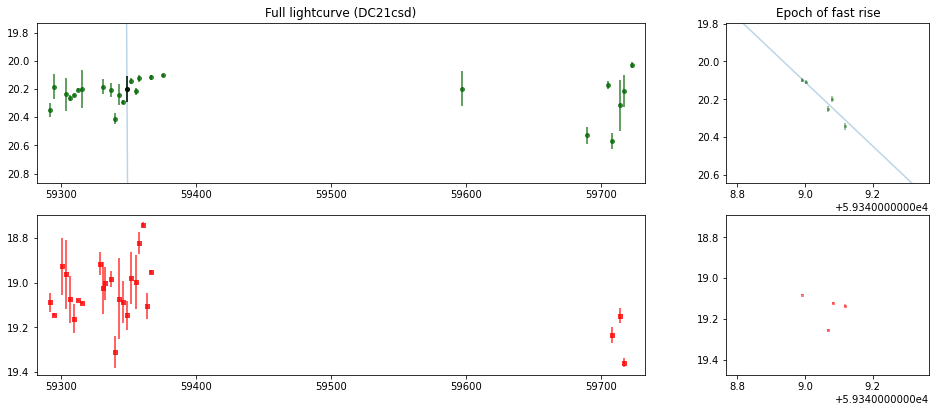

150.050535490839 1.22237545961567
3.144150781067844


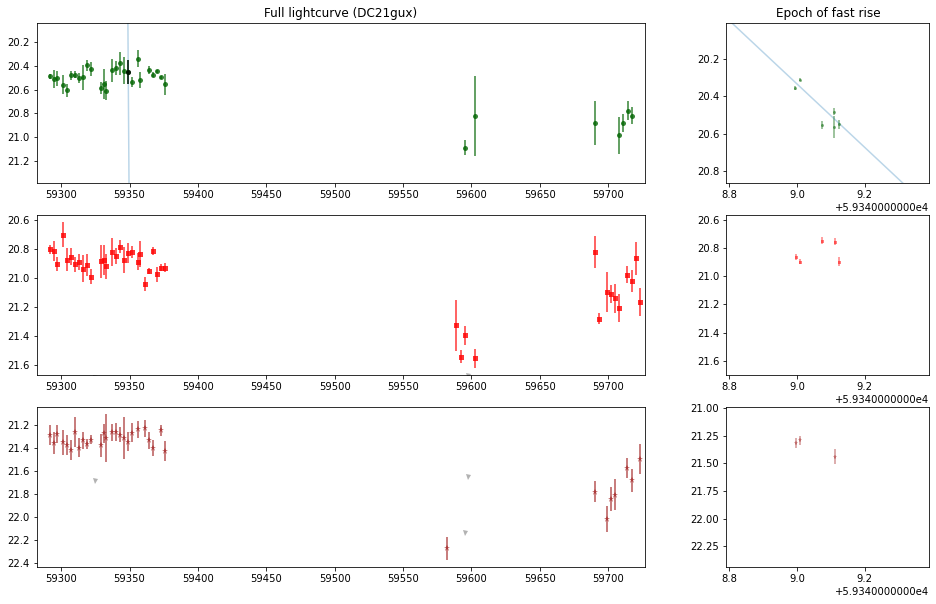

148.986163372069 2.0667174076634
7.9324238225912325


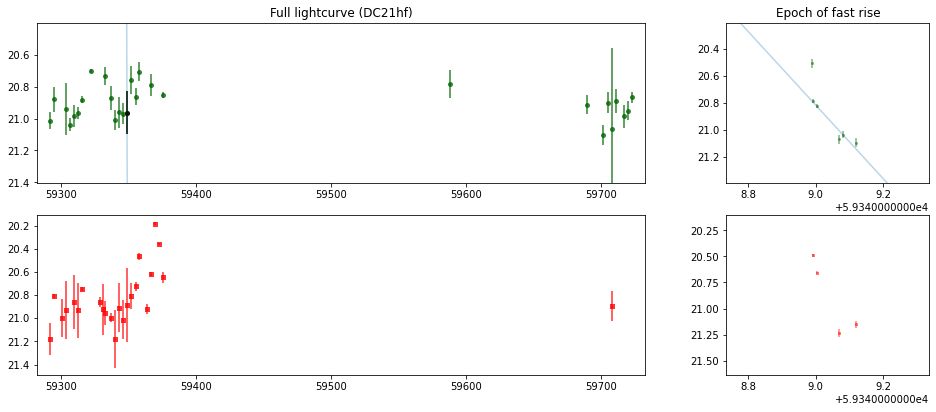

150.018432543545 3.84500240883476
3.145569790244338


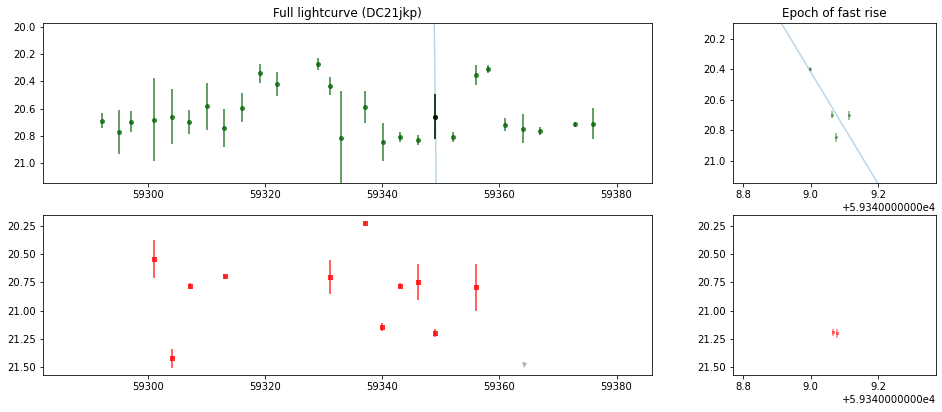

149.314510058965 3.24913373690821
7.280166440012588


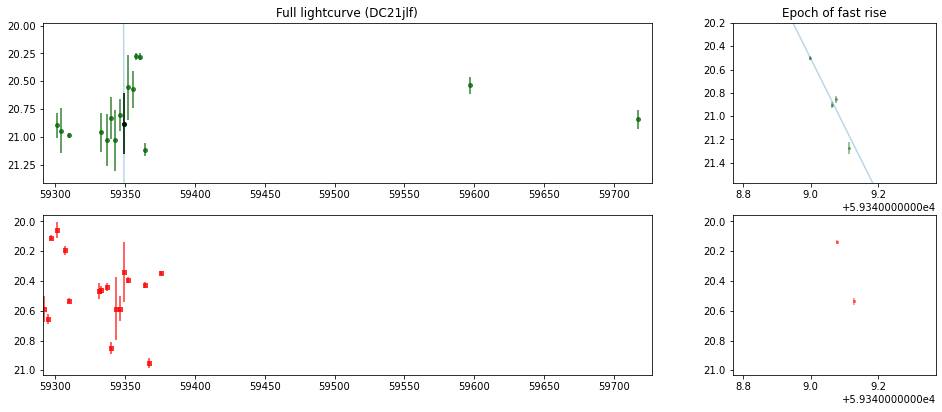

149.518247456276 3.5506893538264
6.495675921929468


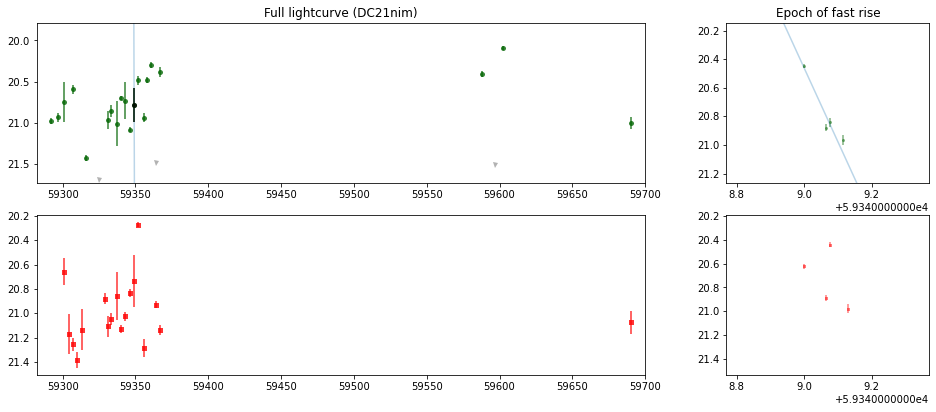

150.191580312645 2.59029831387451
3.4616729200503404


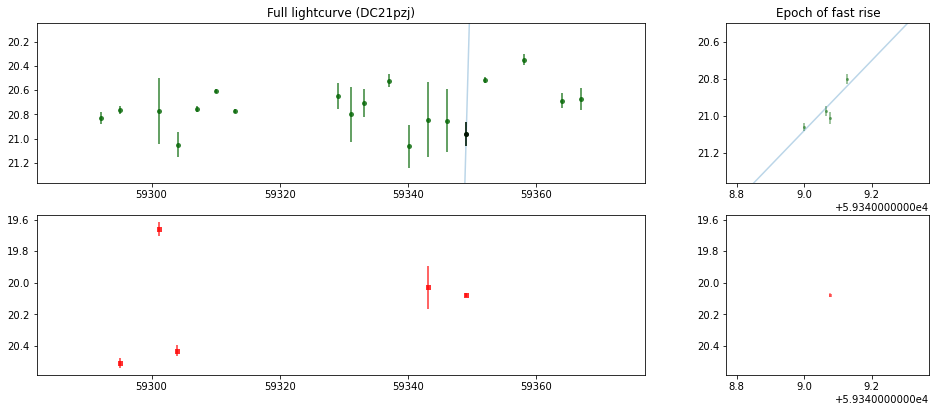

150.288184528885 2.56271155791764
3.378915936468547


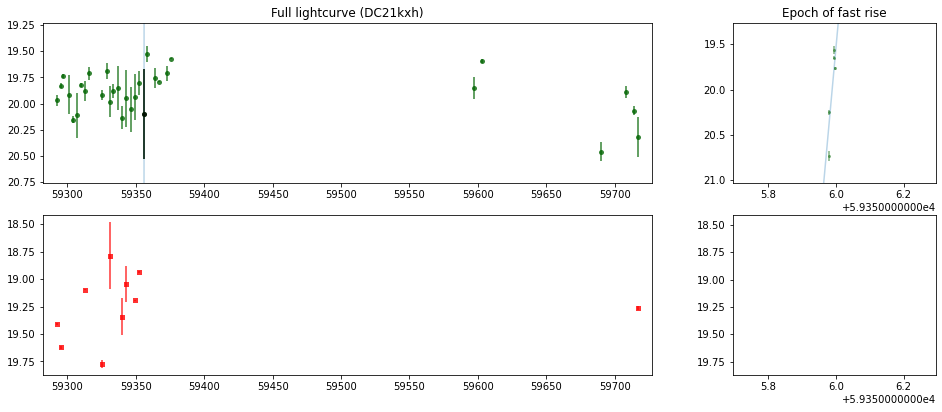

150.288184528885 2.56271155791764
3.5127835969703725


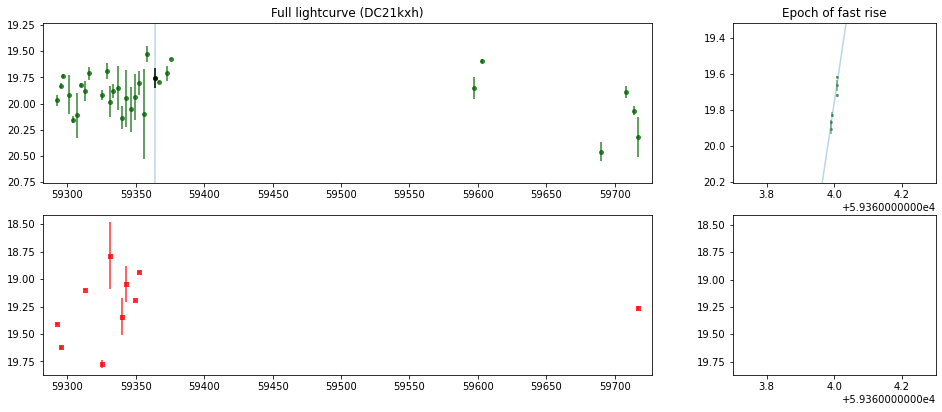

149.628725688213 2.51925096861812
8.770194563206605


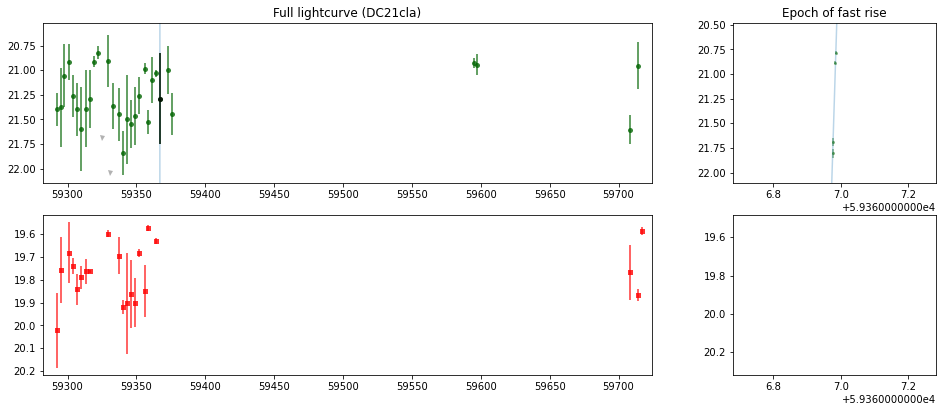

149.66233925016 2.18302600756773
5.321122712532865


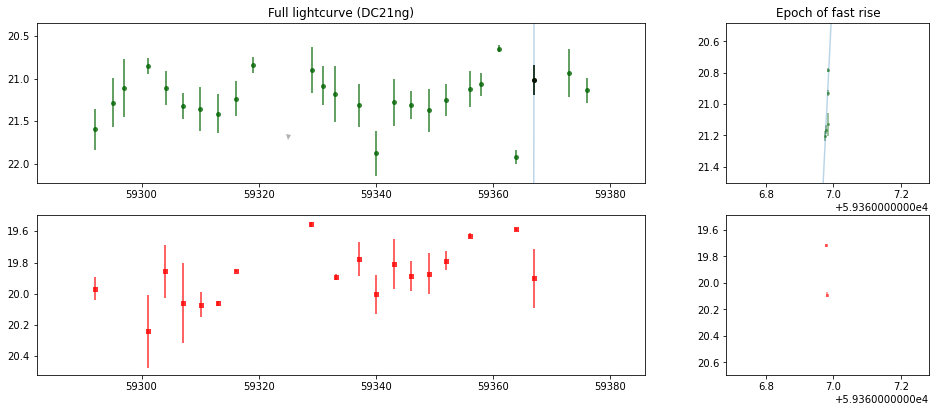

150.057106925386 1.50970194897197
21.627152234039762


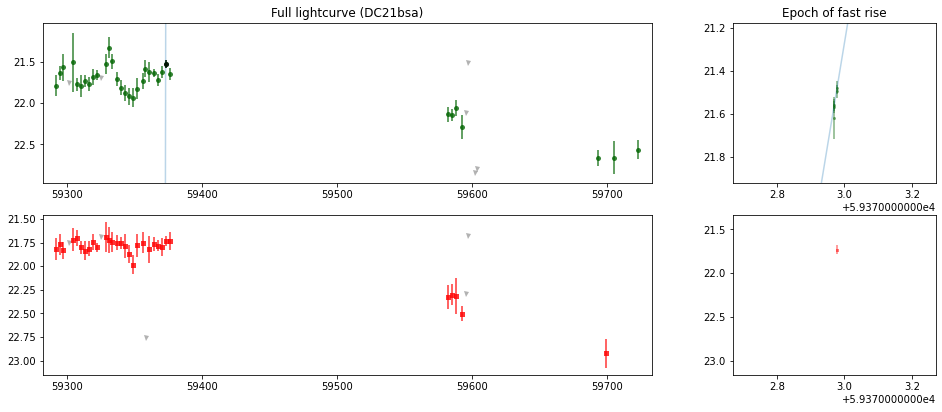

149.700024657821 2.53488332373327
3.103297765898924


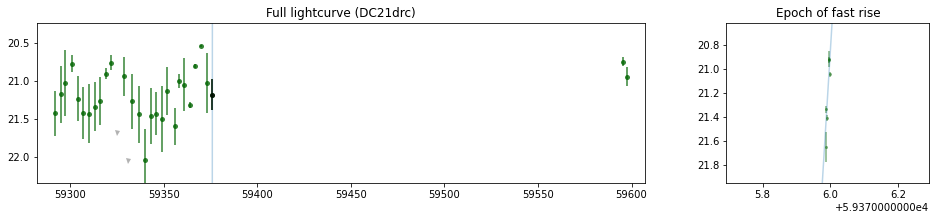

150.790171800924 2.63443604954145
3.5157153580362346


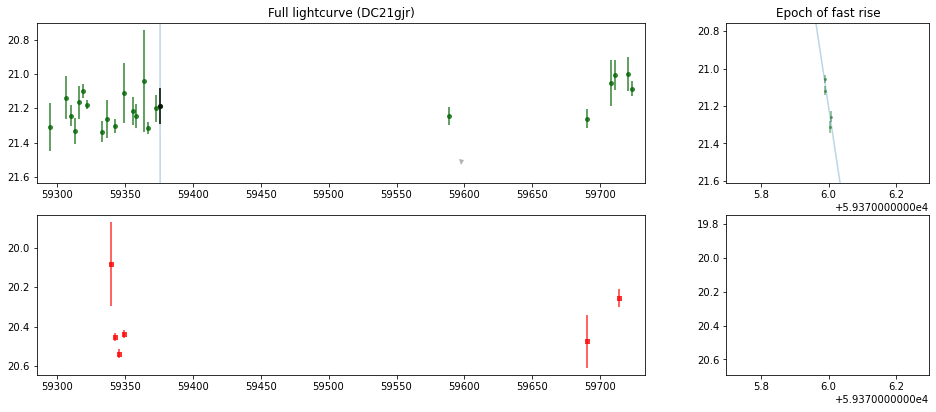

149.58466271997 2.31393171797876
3.4165511071006485


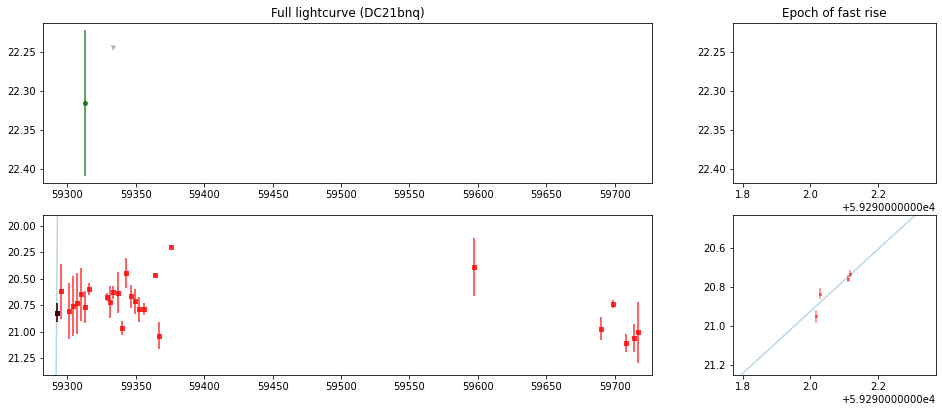

149.229950710453 1.7796672346332
5.545601444680153


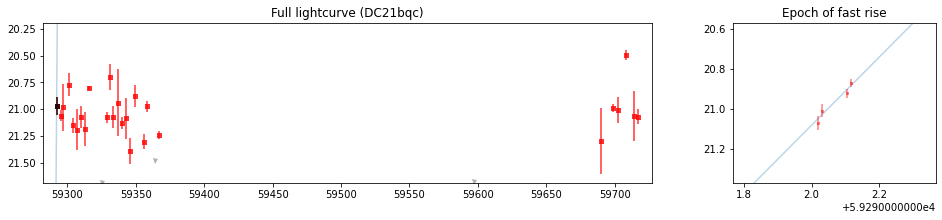

149.047164908586 2.48524963254028
7.218398510336043


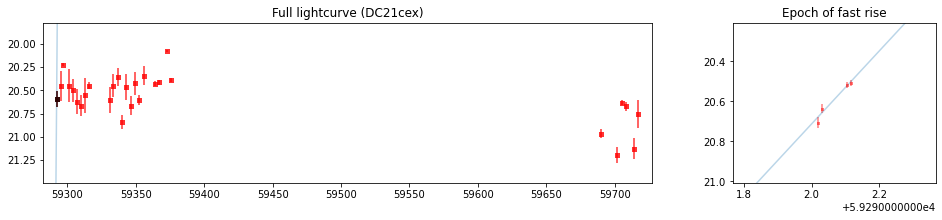

149.930854920166 2.11867988609517
3.094950820618811


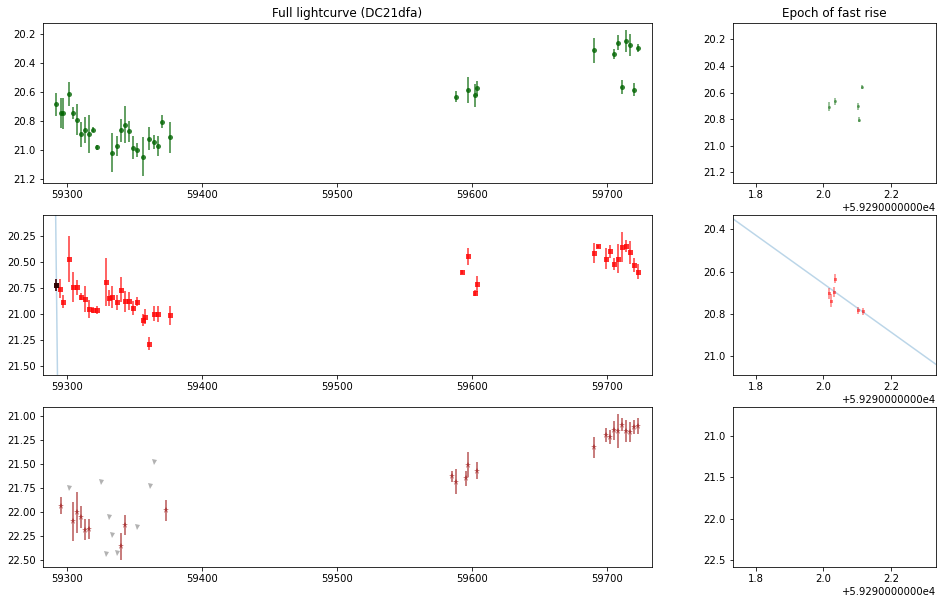

149.462887378955 2.429566594451
3.599629904197934


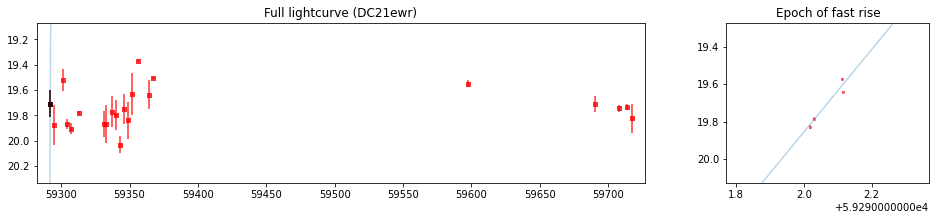

149.176422350135 2.09844907167765
3.6205519933057015


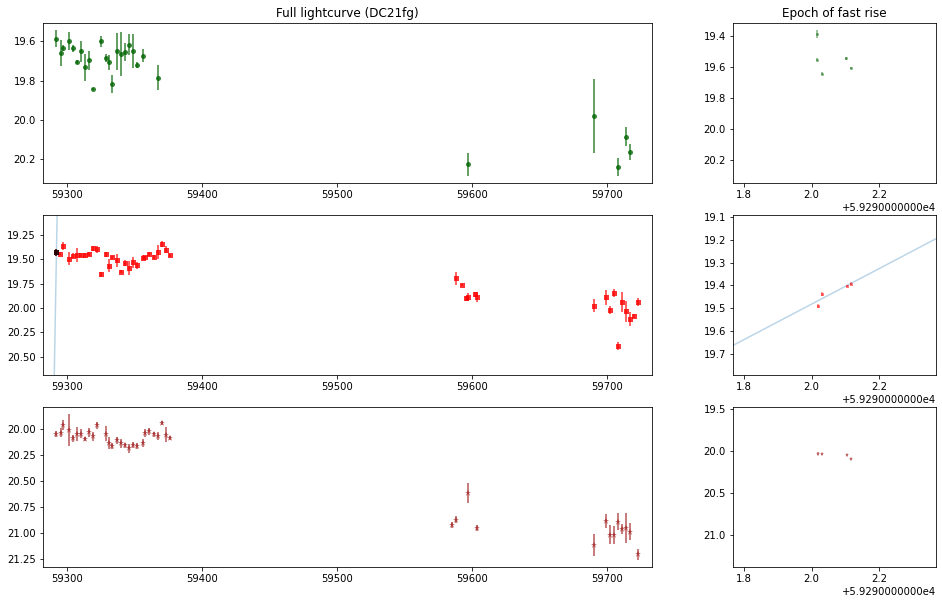

150.090931105454 2.39127107851067
5.051655359702797


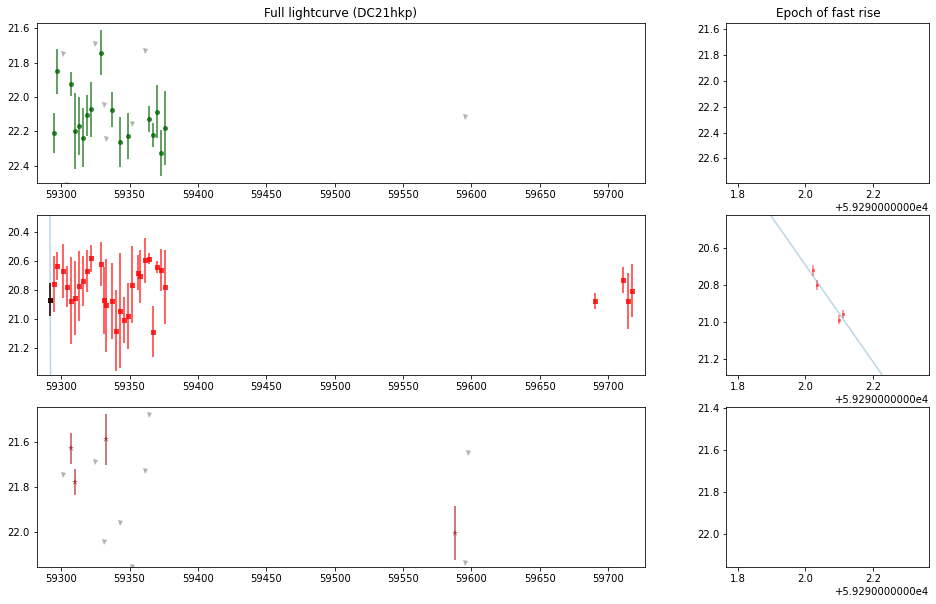

149.447881155617 1.0087906057074
7.536978872690212


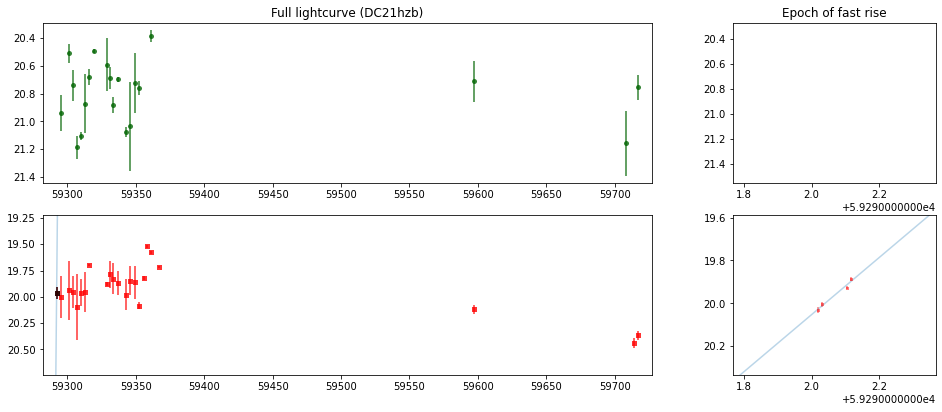

148.849944659379 1.61517840904734
3.4142717552654305


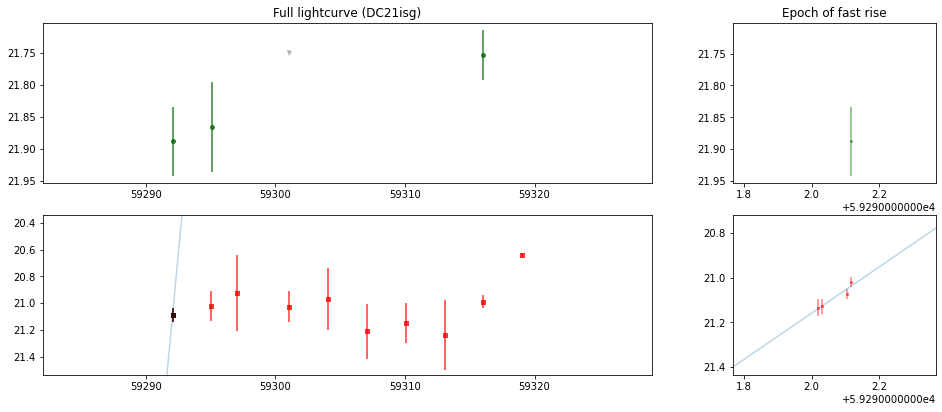

149.363874406663 2.01274344559521
18.2919403483544


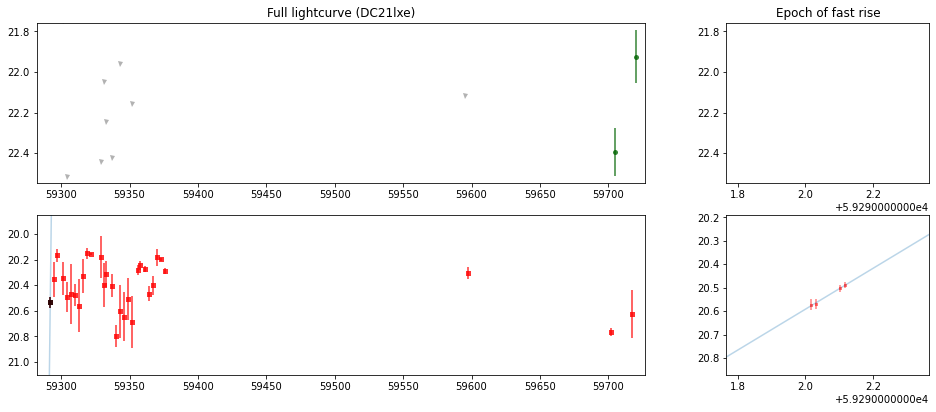

149.302112244292 0.994695448274178
3.6073739357434063


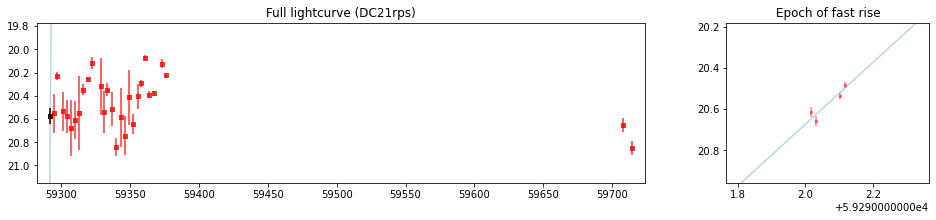

148.818463162892 1.01567353030443
4.750255012783782


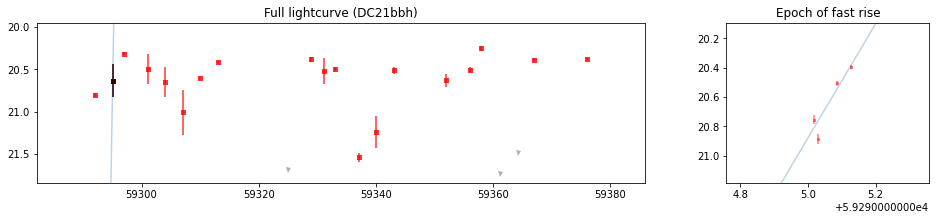

In [15]:
filts = ["g", "r", "i"]
all_fshapes = ['o','s','*']
all_fsizes  = [5, 5, 7]

for i in df[(df["SlopeSig"]>3) & (df["OnlyNight"]==False)][:100].index:
# for i in df[df["Slope"]>0].index:
# for i in df[df["CandID"]=="DC21bkt"].index:
# for i in df[np.isin(df["CandID"],qsos)].index:
# for i in slopedqsos:
    
# for i in range(len(fr[:30])):
    if df["Field"][i] == "COSMOS":
        all_fcolors = ["darkgreen","red","brown"]
        lmtmgs = clmtmgs
    elif df["Field"][i] == "ELAIS": 
        all_fcolors = ["limegreen","darkorange","peru"]
        lmtmgs = elmtmgs
    fig, ax = plt.subplots( 3, 2, figsize=(16,10), sharex='col', sharey=False, gridspec_kw={'width_ratios': [3, 1]} )
    n=0 # which row of the plot to put labels on
    for f in range(len(filts)):
        query = ('SELECT c.id, e.mjd, o.mag, o.magerr, o.ra, o.dec FROM objects o '
                 'JOIN candidates c ON c.id=o.candidate_id '
                 'JOIN subtractions s ON s.id=o.subtraction_id '
                 'JOIN exposures e ON e.id=s.exposure_id '
                 'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=2 '
                 'WHERE c.id=%s '
                 'AND e.filter=%s '
                 'AND rbs.rb > 0.4')
        cursor.execute( query, ( df["CandID"][i], filts[f], ) )
        array = np.array( cursor.fetchall() ).transpose()
        array = rm_dupes(array)
        
        
        array2 = plotlc(df["CandID"][i], cursor, show_plot=False)
        # array2 = np.array(array2)
        ### At left, plot full lightcurve
        if len(array2) != 0:
            # msk = np.where((array2[0][f] > df["Night"][i] - 10) & (array2[0][f] < df["Night"][i] + 10))[0]
            ax[f,0].errorbar( array2[0][f], array2[1][f], yerr=array2[2][f], fmt=all_fshapes[f], ms=all_fsizes[f], alpha=0.8, mew=0, color=all_fcolors[f] )

            msk = ~np.isin(odatesrd, np.round(array2[0][f]))
            ylims = ax[f,0].get_ylim()
            xlims = ax[f,0].get_xlim()
            ax[f,0].set_xlim(xlims[0],xlims[1])
            ax[f,0].set_ylim(ylims[0],ylims[1])
            ax[f,0].plot( odates[msk], lmtmgs[f][msk],'v', ms=5, alpha=0.6, mew=0, color='grey' )
            
            
        # ### at right, zoom in on one epoch
        if len(array) > 0:
            omjds  = array[1].astype(float)
            omags  = array[2].astype(float)
            omerrs = array[3].astype(float)
            ax[f,1].errorbar(omjds, omags, omerrs, fmt=all_fshapes[f], ms=all_fsizes[f]-2, alpha=0.5, mew=0, color=all_fcolors[f])
            ax[f,0].tick_params(labelbottom=True)
            ax[f,1].tick_params(labelbottom=True)
            
            if df["Filter"][i] == filts[f]:
                print(array[4][0], array[5][0])
                print(df["SlopeSig"][i])
                if len(array2[0][f]) != 0:
                    ax[f,0].set_xlim(array2[0][f][0]-10,array2[0][f][-1]+10)
                    ax[f,0].set_ylim(np.min(array2[1][f])-0.3,np.max(array2[1][f])+0.3)
                # (omjds>df["Night"][i]-0.5) & (omjds<df["Night"][i]+0.5)
                mjd = np.median(omjds[(omjds>df["Night"][i]-0.5) & (omjds<df["Night"][i]+0.5)])
                mag = np.median(omags[(omjds>df["Night"][i]-0.5) & (omjds<df["Night"][i]+0.5)])
                minmag = np.min(omags[(omjds>df["Night"][i]-0.5) & (omjds<df["Night"][i]+0.5)])
                maxmag = np.max(omags[(omjds>df["Night"][i]-0.5) & (omjds<df["Night"][i]+0.5)])
                
                xarr = np.linspace(mjd-10, mjd+10, 10)
                ax[f,1].plot(xarr, lin(xarr, df["Slope"][i], df["Intercept"][i]), alpha=0.3)
                ax[f,0].plot(xarr, lin(xarr, df["Slope"][i], df["Intercept"][i]), alpha=0.3)


                ax[0,1].set_xlim(mjd-0.3, mjd+0.3)
                ax[1,1].set_xlim(mjd-0.3, mjd+0.3)
                ax[2,1].set_xlim(mjd-0.3, mjd+0.3)
                
                ax[f,1].set_ylim(minmag-0.3, maxmag+0.3)
                
                frmsk = np.where((array2[0][f] > mjd-0.5) & (array2[0][f] < mjd+0.5))[0][0]
                ax[f,0].errorbar( array2[0][f][frmsk], array2[1][f][frmsk], yerr=array2[2][f][frmsk], fmt=all_fshapes[f], ms=all_fsizes[f], alpha=0.8, mew=0, color="black" )
                
            ax[f,1].invert_yaxis()
            ax[f,0].invert_yaxis()
        else:
            fig.delaxes(ax[f,0])
            fig.delaxes(ax[f,1])
            if f==0:
                n=1
            
    ax[n,0].set_title("Full lightcurve ("+df["CandID"][i]+")")
    ax[n,1].set_title("Epoch of fast rise")
        
    plt.show()

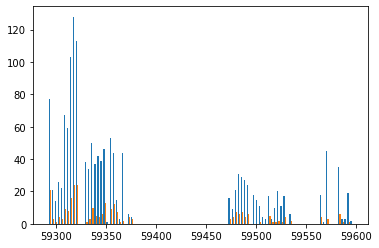

In [218]:
bins = plt.hist((df["Night"],df["Night"][df["SlopeSig"]>2]), bins=100)
# plt.hist(df["Night"][df["SlopeSig"]>numsig], bins=bins)

In [47]:
### Helpful little snippet to make searching candidates in SDSS/TNS searching a bit easier
# engine="TNS"
engine="SDSS"

coordarr = np.empty( len( fr ), dtype=object )
for i in range(len(fr)):
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (fr[i], ) )
    coordarr[i] = cursor.fetchall()[0]


# if engine == "SDSS":
#     for i in coordarr:
#         print(i[0])
#         print(str(i[1]))
#         print(str(i[2]))
# elif engine=="TNS":
#     for i in coordarr:
#         if i[2]>0:
#             print(i[0])
#             print(str(i[1]),"+"+str(i[2]))
#         else:
#             print(i[0])
#             print(str(i[1]),str(i[2]))
coordarr.transpose()
coordarrtxt = np.array([[i[0] for i in coordarr],[i[1] for i in coordarr],[i[2] for i in coordarr]])
np.savetxt("weirdos", coordarrtxt, delimiter=",", fmt='%.18s')

In [18]:
qsos = ['DC21fyx', 'DC21jmx', 'DC21dxm', 'DC21kzt', 'DC21fg', 'DC21fko',
       'DC21kzt', 'DC21blqd', 'DC21jmx', 'DC21pcn', 'DC21syx', 'DC21dru',
       'DC21kzt', 'DC21pul', 'DC21bhq', 'DC21dqjw', 'DC21imi', 'DC21jvu',
       'DC21rpw', 'DC21fco', 'DC21bhq', 'DC21edp', 'DC21ftm', 'DC21ppu',
       'DC21ppu', 'DC21fg', 'DC21fhu', 'DC21bpva', 'DC21chx', 'DC21jmx',
       'DC21fg', 'DC21eaw', 'DC21fll', 'DC21qos', 'DC21fpe', 'DC21eaw',
       'DC21il', 'DC21eaw', 'DC21ftb', 'DC21ypd', 'DC21pul', 'DC21fco',
       'DC21syx', 'DC21pul', 'DC21fhe', 'DC21edww', 'DC21exu', 'DC21fyx',
       'DC21yn', 'DC21klq', 'DC21bhq', 'DC21fko', 'DC21bjvj', 'DC21cpt',
       'DC21dukb', 'DC21jac', 'DC21bjvj', 'DC21fhu', 'DC21bwhls',
       'DC21fhu', 'DC21bwdzy', 'DC21exu', 'DC21mk', 'DC21bae', 'DC21mk',
       'DC21bae', 'DC21bae', 'DC21bae', 'DC21mk']
# qsos = ['DC21bwx', 'DC21dnu', 'DC21jfs', 'DC21kxh']
# for i in np.unique(qsos):
#     plotlc(i,cursor)
# plotlc("DC21bkt",cursor)

In [164]:
clas = ['DC21bg',
 'DC21bhq',
 'DC21bsa',
 'DC21bwx',
 'DC21cpt',
 'DC21dnu',
 'DC21fg',
 'DC21fyx',
 'DC21gin',
 'DC21gux',
 'DC21il',
 'DC21jfs',
 'DC21jln',
 'DC21jmx',
 'DC21klfi',
 'DC21kxh',
 'DC21mk',
 'DC21mtc',
 'DC21pul']
allpkmag  = []
claspkmag = []
for i in df[df["SlopeSig"]>numsig].index:
    query = ('SELECT c.id, o.mag FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE c.id=%s '
             'AND e.filter=%s '
             'AND rbs.rb > 0.4')
    cursor.execute( query, ( df["CandID"][i], df["Filter"][i], ) )
    array = np.array( cursor.fetchall() ).transpose()
    allpkmag.append(np.min(array[1].astype(float)))
    if df["CandID"][i] in clas:
        claspkmag.append(np.min(array[1].astype(float)))

In [54]:
plt.hist(allpkmag)
plt.hist(claspkmag);

NameError: name 'allpkmag' is not defined

#### Old version of fn/on stuff

In [241]:
# fn = np.ones( len( fr ), dtype=object )
# on = np.ones( len( fr ), dtype=object )
# for i in range(len(fr)):
#     # maxmag[i] = []
#     fn[i] = []
#     on[i] = []
#     for fil in ["g","r","i"]:
#         query = ("SELECT o.mag, e.mjd FROM objects o "
#                  "JOIN subtractions s ON s.id=o.subtraction_id "
#                  "JOIN exposures e on s.exposure_id = e.id "
#                  "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 "
#                  "WHERE rbs.rb > 0.4 "
#                  "AND e.filter = %s "
#                  "AND (e.proposalid = '2021A-0113' "
#                  "OR e.proposalid = '2021B-0149') "
#                  "AND o.candidate_id = %s "
#                  "ORDER BY e.mjd "
#                  "LIMIT 10000000")
#         cursor.execute( query, ( fil, fr[i], ) )
#         tempres = np.array( cursor.fetchall(), dtype=float ).transpose()
#         if len(tempres) == 0:
#             # maxmag[i].append(0)
#             fn[i].append(False)
#             on[i].append(False)
#         else:
#             # maxmag[i].append(np.min(tempres[0]))
#             lastnight = float(tempres[1][-1])
#             firstnight = float(tempres[1][0])
#             if firstnight < frdates[i][0]:
#                 fn[i].append(False)
#                 on[i].append(False)
#             else:
#                 fn[i].append(True)
#                 if lastnight > frdates[i][1]:
#                     on[i].append(False)
#                 else:
#                     on[i].append(True)

In [25]:
# df = pd.DataFrame(index = range(len(fr)), columns = ["CandID", "Field", "Filter", "Night", "DelMag", "PeakMag", "FirstNight", "OnlyNight", "Slope", "Intercept", "MedErr"])

# for i in range(len(fr)):
#     df["CandID"][i] = fr[i]
#     if i < sum(filidx[:3]):
#         df["Field"][i] = "COSMOS"
#     else: 
#         df["Field"][i] = "ELAIS"
#     df["Night"][i] = frdates[i][0]+0.5
#     df["Slope"][i] = fitpararr[i][0]
#     df["Intercept"][i] = fitpararr[i][1]
#     df["DelMag"][i] = amps[i]
#     df["PeakMag"][i] = maxmags[i]
#     df["MedErr"][i] = medmgerrs[i]
#     if i < filidx[0]:
#         df["Filter"][i] = "g"
#         df["FirstNight"][i] = fn[i][0]
#         df["OnlyNight"][i] = on[i][0]
#     elif (i >= filidx[0]) & (i < sum(filidx[:2])):
#         df["Filter"][i] = "r"
#         df["FirstNight"][i] = fn[i][1]
#         df["OnlyNight"][i] = on[i][1]
#     elif (i >= sum(filidx[:2])) & (i < sum(filidx[:3])):
#         df["Filter"][i] = "i"
#         df["FirstNight"][i] = fn[i][2]
#         df["OnlyNight"][i] = on[i][2]
#     elif (i >= sum(filidx[:3])) & (i < sum(filidx[:4])):
#         df["Filter"][i] = "g"
#         df["FirstNight"][i] = fn[i][0]
#         df["OnlyNight"][i] = on[i][0]
#     elif (i >= sum(filidx[:4])) & (i < sum(filidx[:5])):
#         df["Filter"][i] = "r"
#         df["FirstNight"][i] = fn[i][1]
#         df["OnlyNight"][i] = on[i][1]
#     elif (i >= sum(filidx[:5])): #& (i < sum(filidx[:6])):
#         df["Filter"][i] = "i"
#         df["FirstNight"][i] = fn[i][2]
#         df["OnlyNight"][i] = on[i][2]
        
# ### This takes care of duplicates that arise from having observations closer together than usual
# df = df.drop_duplicates(subset=["CandID", "Field", "Filter", "DelMag", "PeakMag"])
# try:
#     df = df.reset_index(drop=True)
# except ValueError:
#     pass
# fr = df["CandID"]
# frdates = [[df["Night"][i]-0.5,df["Night"][i]+0.5] for i in range(len(fr))]